# Estimating a regional field
Here we will present the 4 methods we provide for estimating the regional component of gravity misfit.

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2
import logging

import numpy as np
import pandas as pd
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import plotting, regional, synthetic, uncertainty, utils

# set up logging to see what's going on
logging.basicConfig(level=logging.INFO)

# Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the crystalline basement. The gravity effect from the Moho will represent the **regional** which we are aiming to isolate. We will forward model the gravity effects of both layers, and add some noise, to create an observed gravity dataset. We will then use a series of point where we know the basement topography to create a starting model, forward calculate its gravity effect, and remove it from the observed gravity to get a gravity misfit. We will then demonstrate the range of techniques implemented within *Invert4Geom* for isolated the regional component of this gravity misfit.

In [2]:
# get topography data
grid = synthetic.load_bishop_model(coarsen_factor=20)

# extract grid spacing and region
spacing, buffer_region, _, _, _ = polar_utils.get_grid_info(
    grid.basement_topo, print_info=True
)

# get topography data
basement_topo = grid.basement_topo
moho_topo = grid.moho_topo

# create an inside region to reduce gravity edge effects
region = vd.pad_region(buffer_region, -spacing * 5)
region

grid spacing: 4000.0 m
grid region: (3900.0, 379900.0, 142900.0, 538900.0)
grid zmin: -9349.98535156
grid zmax: -276.429992676
grid registration: g


(23900.0, 359900.0, 162900.0, 518900.0)

## Prism layers

Create prism layers from the Moho and basement surfaces.

true zref: -6129.2626799258505m


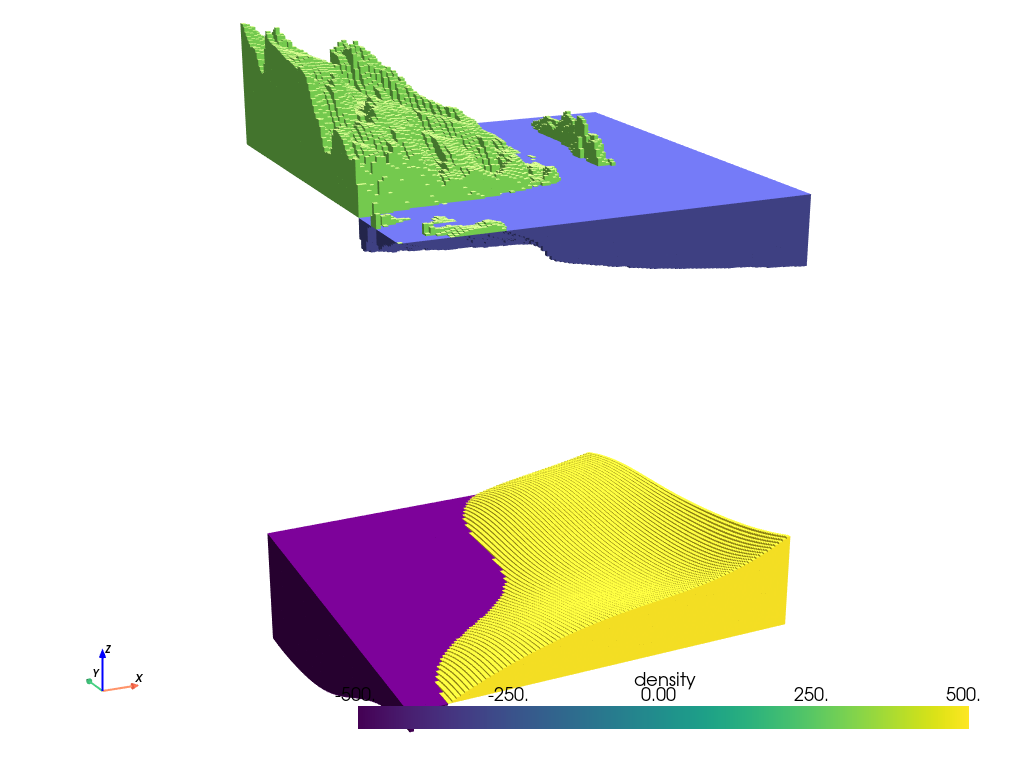

In [3]:
# the density contrast is between basement (~2800 kg/m3) and sediment (~2500 kg/m3)
basement_density_contrast = 2800 - 2500

# prisms are created between the mean topography value and the height of the topography
basement_zref = basement_topo.values.mean()
print(f"true zref: {basement_zref}m")

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    basement_topo >= basement_zref,
    basement_density_contrast,
    -basement_density_contrast,
)

# create layer of prisms
basement_prisms = utils.grids_to_prisms(
    basement_topo,
    basement_zref,
    density=density_grid,
)

# the density contrast is between mantle (~3300 kg/m3) and basement rock (~2700 kg/m3)
moho_density_contrast = 3300 - 2800

# prisms are created between the mean topography value and the height of the topography
moho_zref = moho_topo.values.mean()

# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(
    moho_topo >= moho_zref, moho_density_contrast, -moho_density_contrast
)

# create layer of prisms
moho_prisms = utils.grids_to_prisms(
    moho_topo,
    moho_zref,
    density=density_grid,
)

plotting.show_prism_layers(
    [basement_prisms, moho_prisms],
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Forward gravity of prism layers

Calculate the gravity effect of each of these prism layers

In [4]:
# make pandas dataframe of locations to calculate gravity
# this represents the station locations of a gravity survey
# create lists of coordinates
coords = vd.grid_coordinates(
    region=region,
    spacing=spacing,
    pixel_register=False,
    extra_coords=1000,  # survey elevation
)

# grid the coordinates
observations = vd.make_xarray_grid(
    (coords[0], coords[1]),
    data=coords[2],
    data_names="upward",
    dims=("northing", "easting"),
).upward

grav_df = vd.grid_to_table(observations)

# forward gravity of basement prisms
grav_df["basement_grav"] = basement_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
# forward gravity of moho prisms
grav_df["moho_grav"] = moho_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)
grav_df.describe()

  0%|          | 0/7650 [00:00<?, ?it/s]

  0%|          | 0/7650 [00:00<?, ?it/s]

northing        easting  upward  basement_grav    moho_grav
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000
mean   340900.000000  191900.000000  1000.0       0.302784     0.854261
std    103923.425856   98149.168359     0.0      23.600390    27.678047
min    162900.000000   23900.000000  1000.0     -33.022243   -62.307508
25%    250900.000000  107900.000000  1000.0     -18.374009   -17.930276
50%    340900.000000  191900.000000  1000.0      -4.926081     9.032927
75%    430900.000000  275900.000000  1000.0      21.427205    23.713696
max    518900.000000  359900.000000  1000.0      58.127097    39.552763

In [5]:
# add offset to the moho gravity
grav_df["moho_grav"] += 100

grav_df["grav"] = grav_df.basement_grav + grav_df.moho_grav
grav_df.describe()

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  
count  7650.000000  
mean    101.157045  
std       9.701881  
min      75.622259  
25%      96.219224  
50%     102.149393  
75%     106.786022  
max     126.324788

In [6]:
# contaminate gravity with 2 mGal of random noise
grav_df["gravity_anomaly"], stddev = synthetic.contaminate(
    grav_df.grav,
    stddev=2,
    percent=False,
    seed=0,
)
grav_df["uncert"] = stddev

# grid the contaminated gravity
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

INFO:invert4geom:Standard deviation used for noise: [2.0]


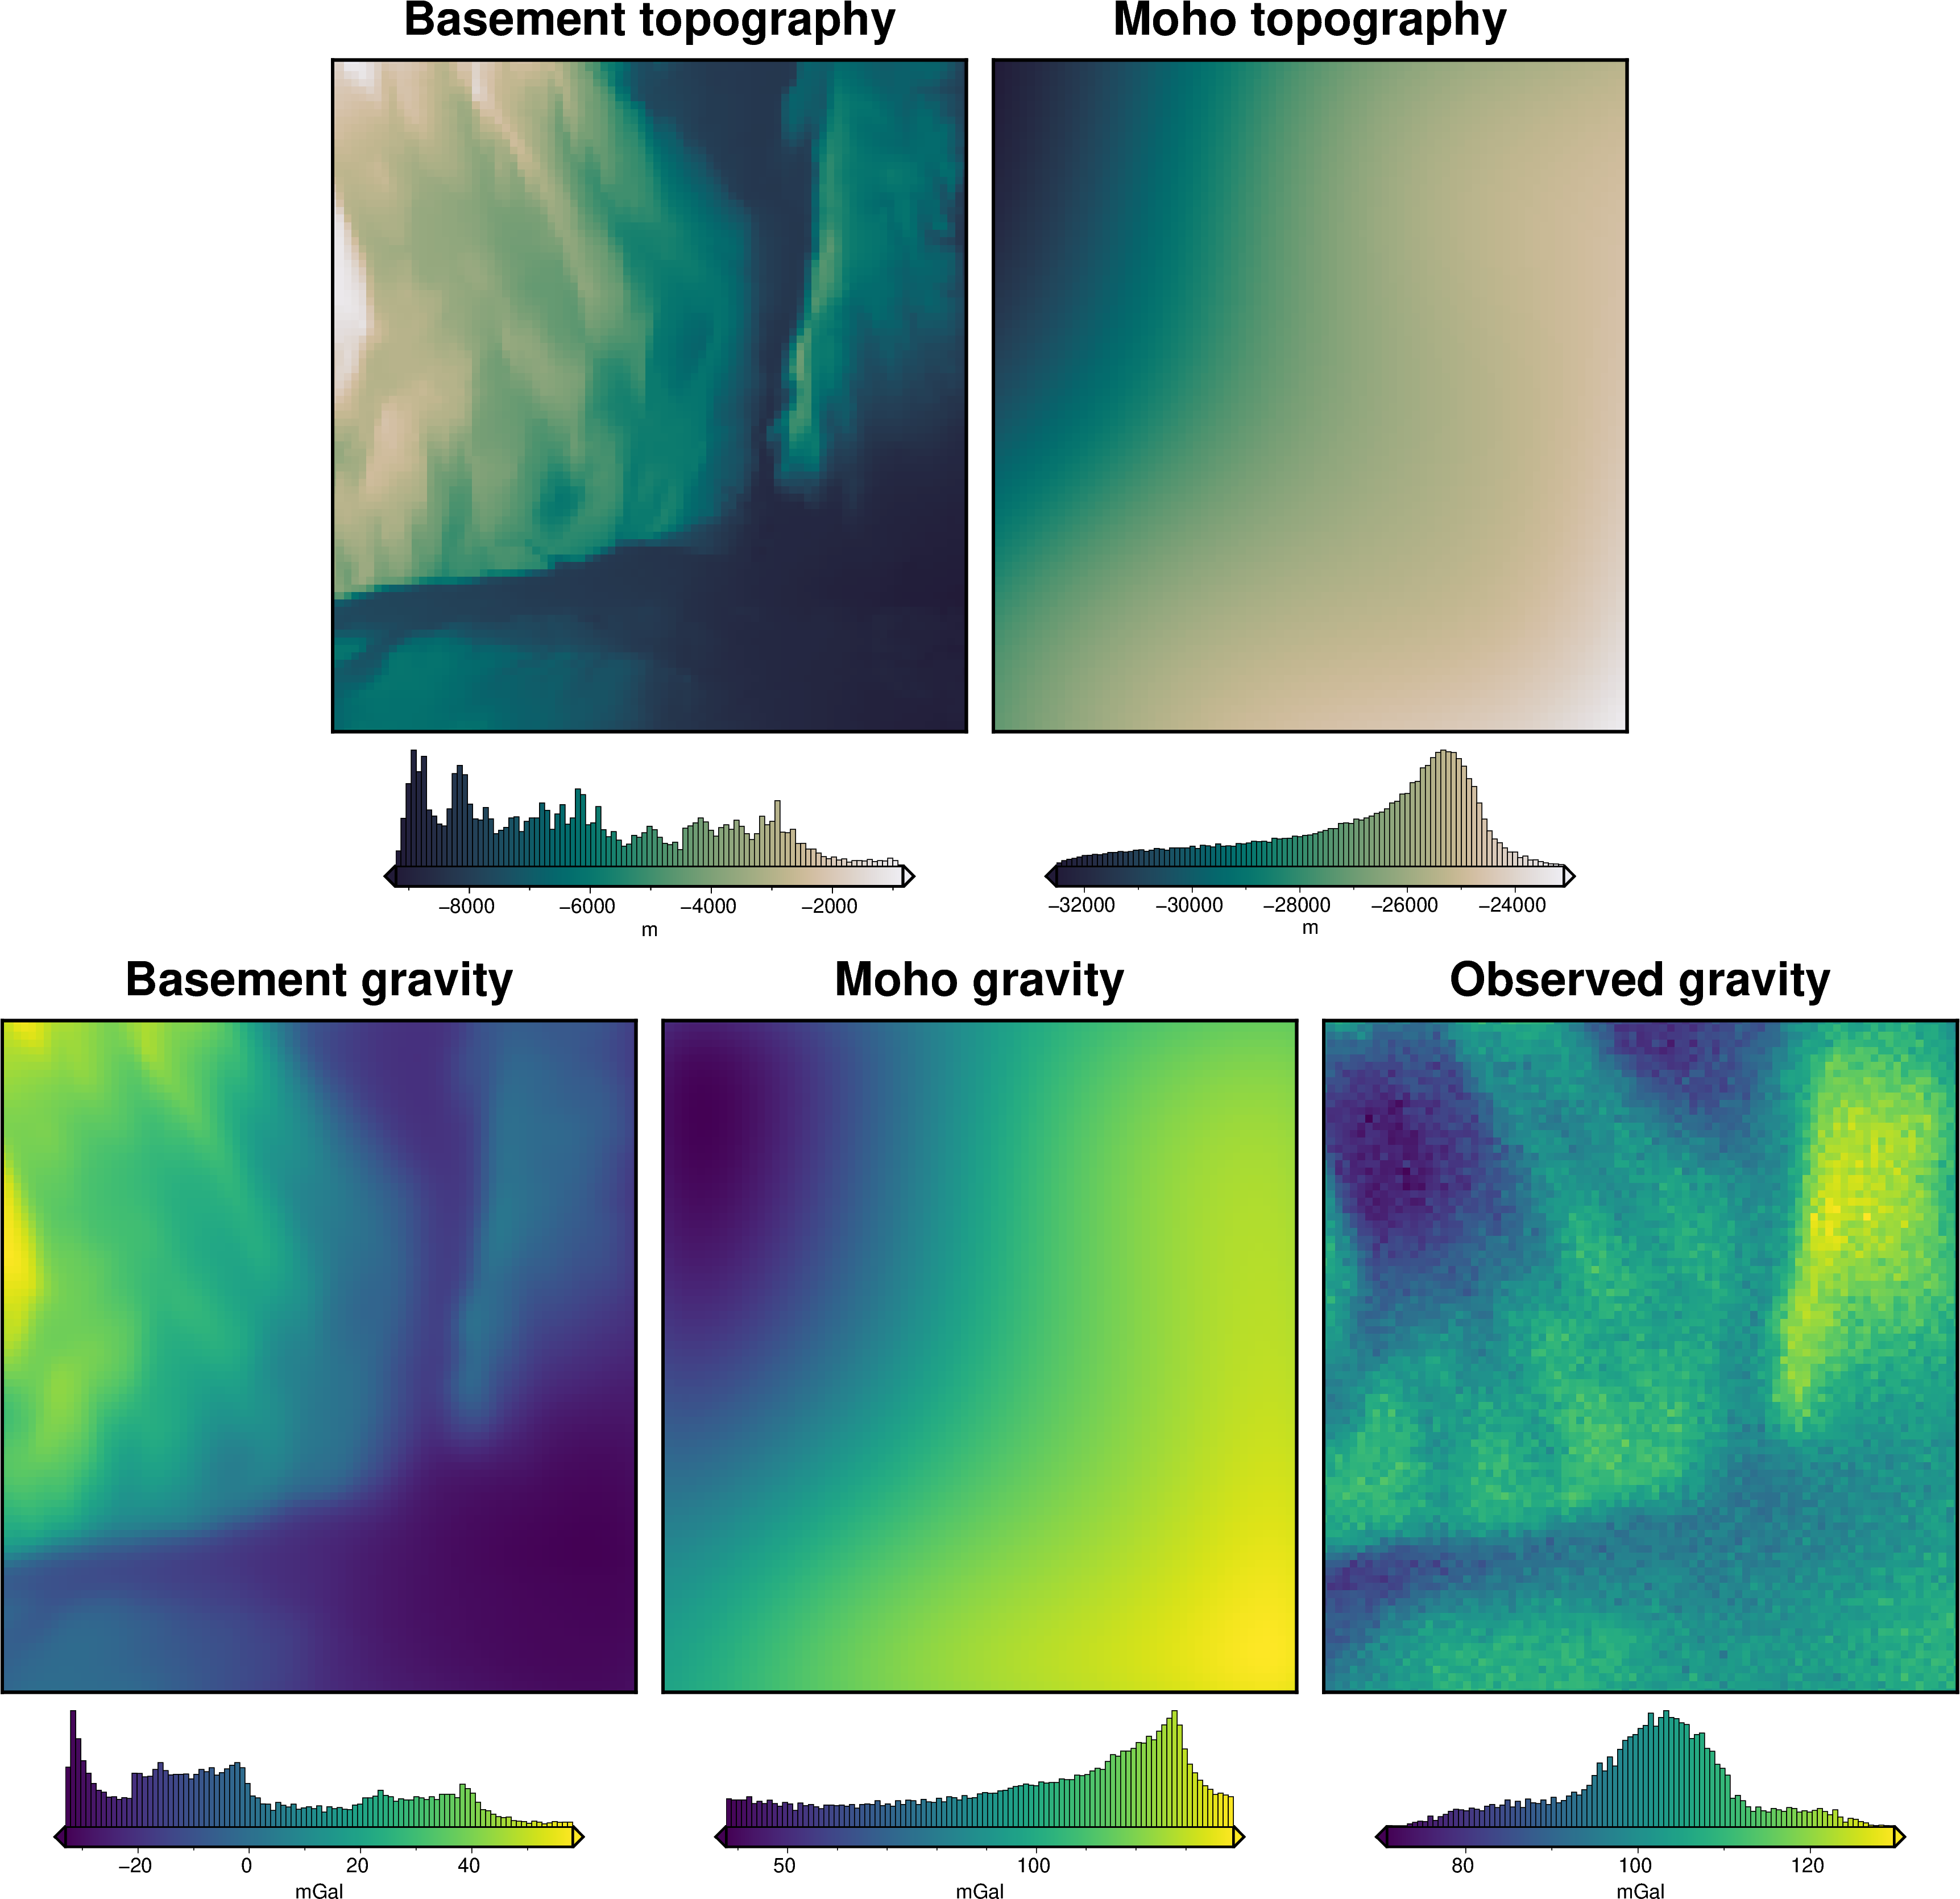

In [7]:
fig = maps.plot_grd(
    basement_topo,
    region=region,
    fig_height=10,
    title="Basement topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    moho_topo,
    region=region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho topography",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.basement_grav,
    fig=fig,
    origin_shift="both_shift",
    xshift_amount=-1.5,
    yshift_amount=-1.1,
    fig_height=10,
    title="Basement gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Moho gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig = maps.plot_grd(
    grav_grid.gravity_anomaly,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Observed gravity",
    cmap="viridis",
    cbar_label="mGal",
    hist=True,
)

fig.show()

# Create "a-priori" basement measurements
These points represent locations where we know the basement elevation, for example from drill holes, seismic surveys, or outcropping basement.

In [8]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    basement_topo,
    "true_upward",
    coord_names=("easting", "northing"),
)

constraint_points["upward"] = constraint_points.true_upward

# re-sample depths with uncertainty to emulate measurement errors
# set each points uncertainty equal to 2% of depth
uncert = np.abs(0.02 * constraint_points.upward)
constraint_points.loc[constraint_points.index, "uncert"] = uncert

constraint_points = uncertainty.randomly_sample_data(
    seed=0,
    data_df=constraint_points,
    data_col="upward",
    uncert_col="uncert",
)

# create weights column
constraint_points["weight"] = 1 / (constraint_points.uncert**2)

constraint_points.head()

easting       northing  true_upward       upward      uncert  \
0   93942.740553  165086.148419 -6166.691339 -6151.184549  123.333827   
1  185744.836752  437747.618234 -5230.910817 -5244.731393  104.618216   
2  165200.779866  503888.251841 -4551.466895 -4493.169645   91.029338   
3  312585.151503  412789.886738 -6178.090981 -6165.129332  123.561820   
4   81410.282014  268837.863004 -4562.000830 -4610.875312   91.240017   

     weight  
0  0.000066  
1  0.000091  
2  0.000121  
3  0.000065  
4  0.000120

# Create starting basement model

Here we interpolate the *a-priori* point measurements to create a starting model of basement topography. We then use this to create a starting prism model.

In [9]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=[*list(np.logspace(-60, 0, 100)), None],
    weights=constraint_points.weight,
)

INFO:invert4geom:Best SplineCV score: 0.40003191692663587
INFO:invert4geom:Best damping: 1e-60


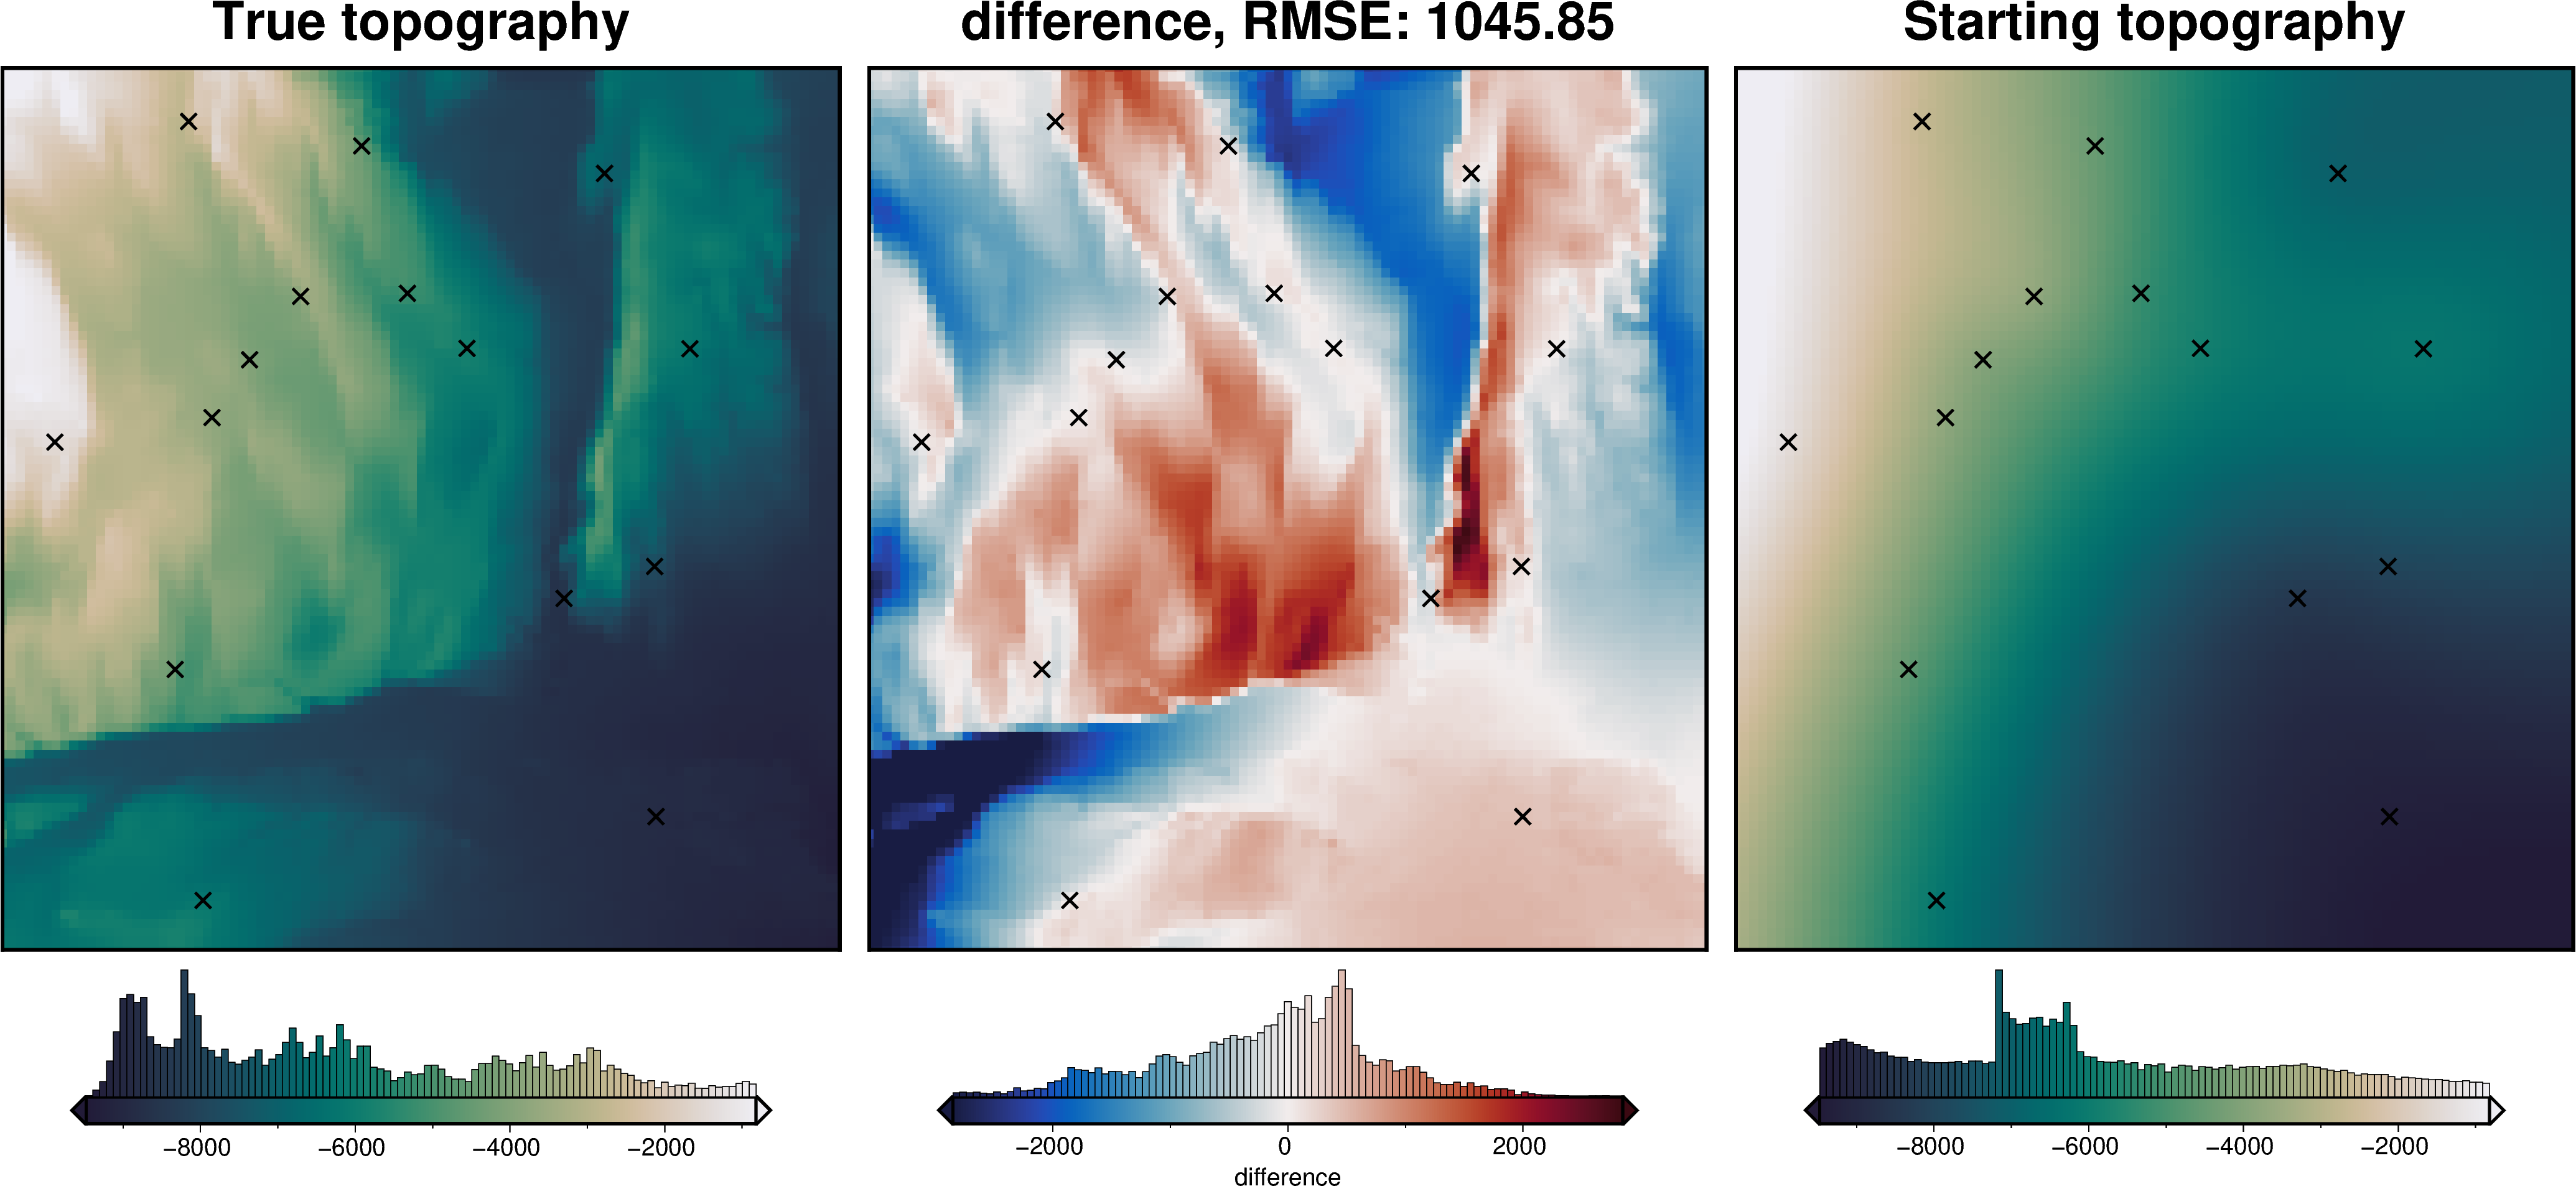

In [10]:
_ = polar_utils.grd_compare(
    basement_topo,
    starting_topography,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [11]:
zref = basement_zref
density_contrast = basement_density_contrast

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

# Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

### Forward gravity of starting prism layer

In [12]:
# calculate forward gravity of starting prism layer
grav_df["starting_gravity"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate the true residual misfit
grav_df["true_res"] = (
    grav_df.gravity_anomaly - grav_df.starting_gravity - grav_df.moho_grav
)

grav_df.describe()

  0%|          | 0/7650 [00:00<?, ?it/s]

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000  
mean    101.157045       101.157045     2.0          1.548275    -1.245492  
std       9.701881         9.918000     0.0         24.921606     9.332421  
min      75.622259        70.865584     2.0        -36.407174   -39.690986  
25%      96.219224        96.092694     2.0        -17.405060    -6.457196  
50%     102.149393       102.057121     2.0         -3.039717    -0.024313  
75%     106.786022       107.005035     2.0         19.819674     4.762689  
max     126.324788       129.731888     2.0         59.686931    23.112321

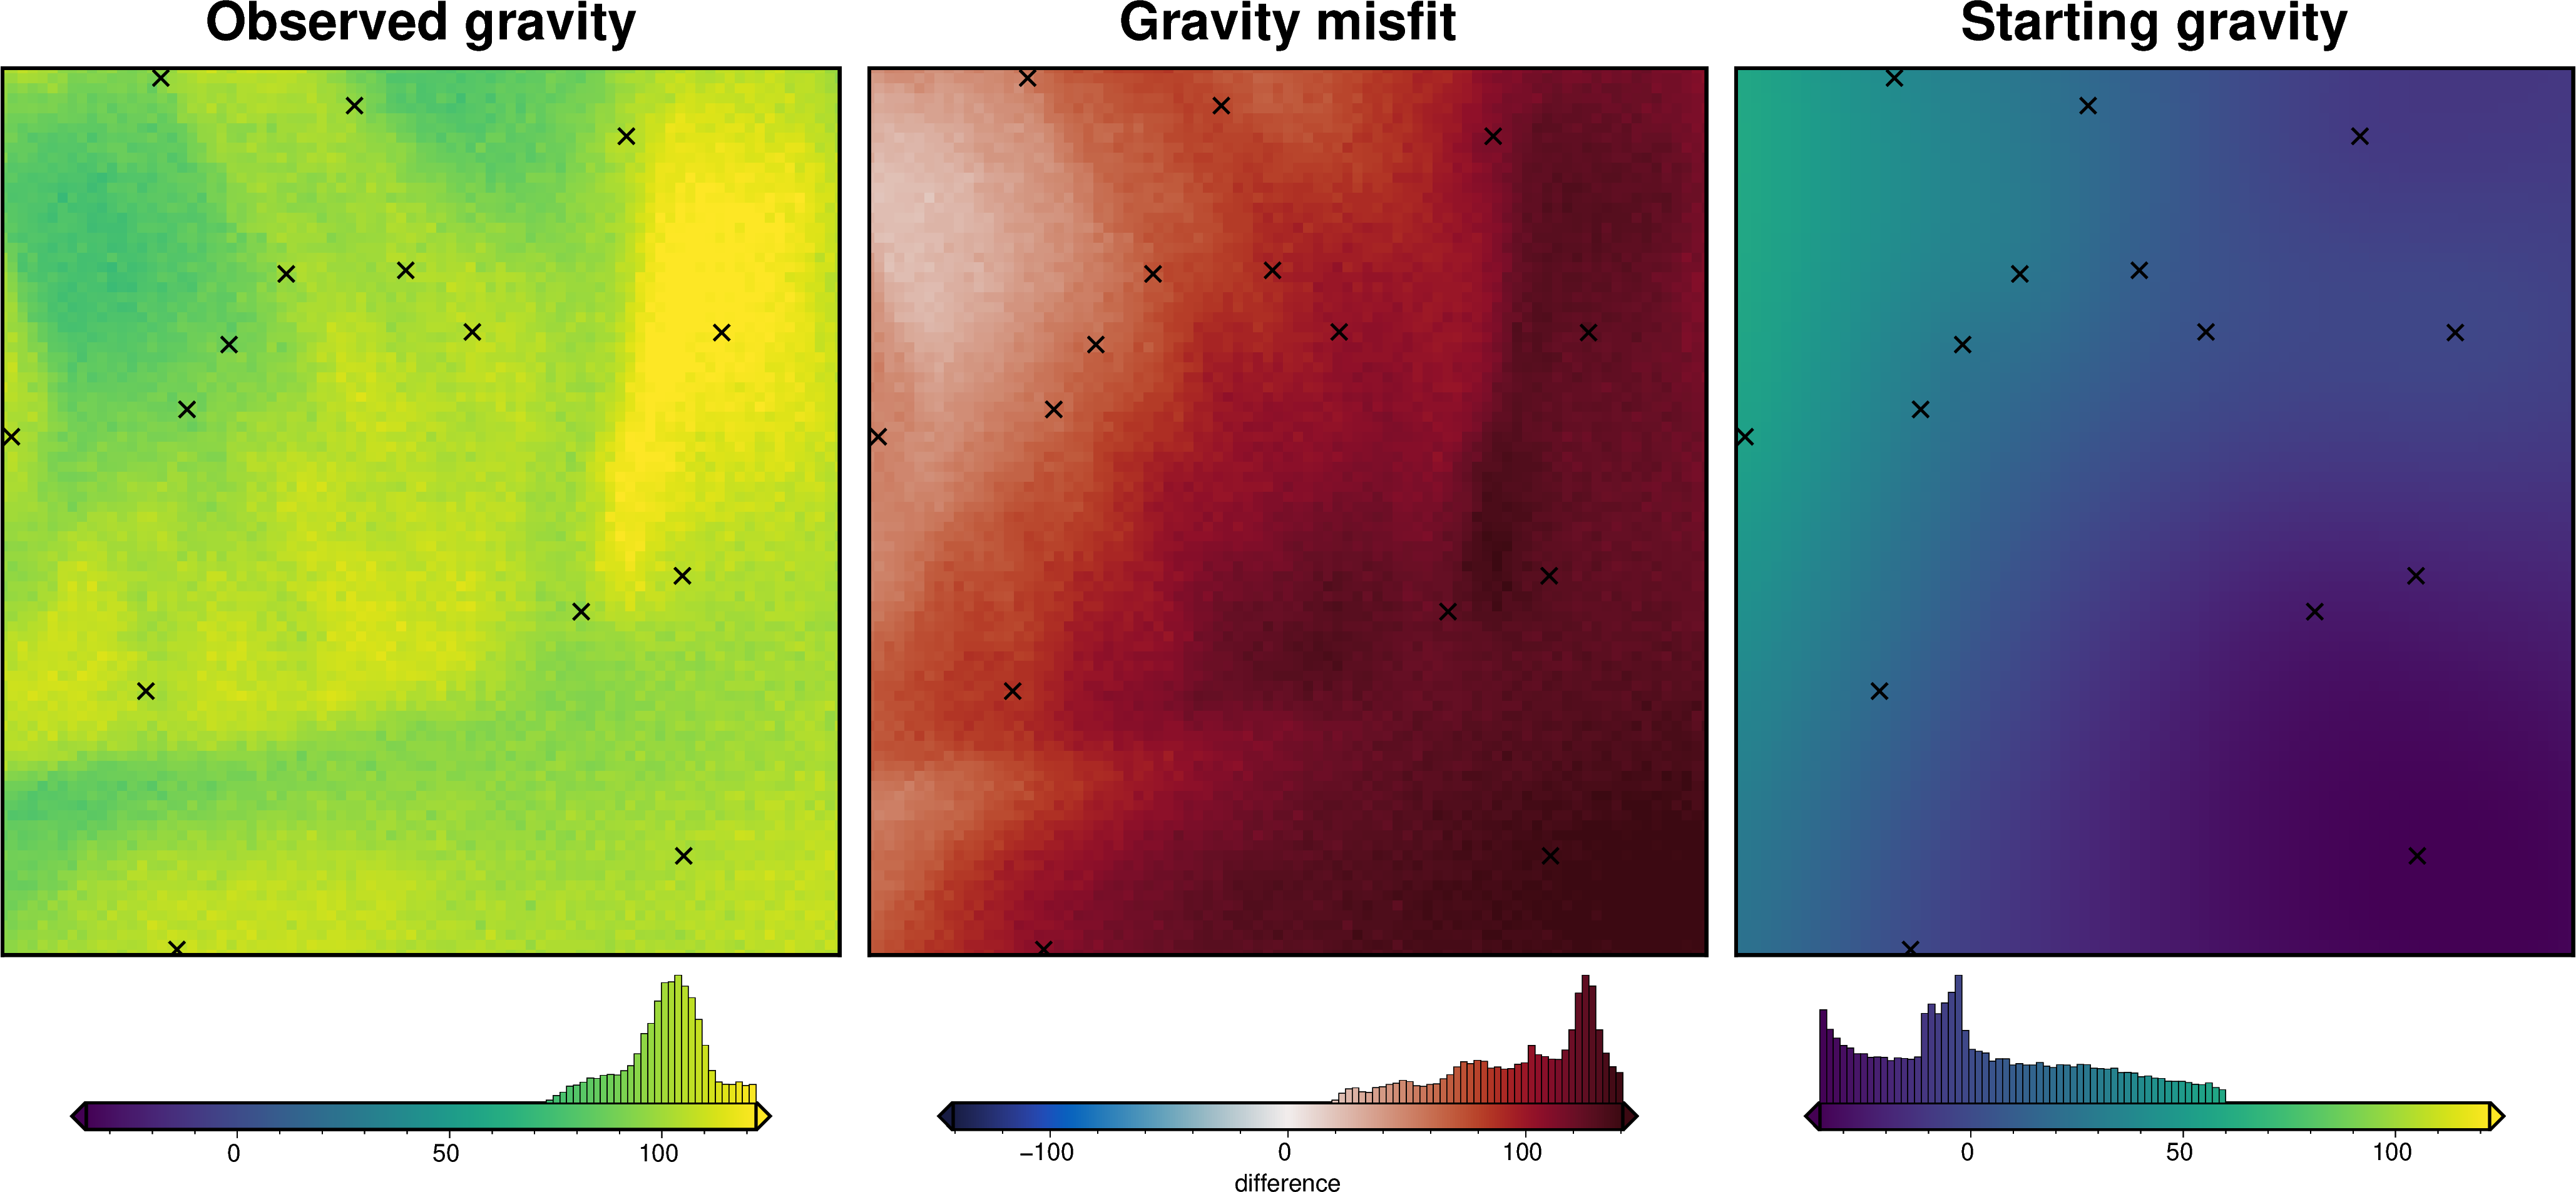

In [13]:
# grid the results
grav_grid = grav_df.set_index(["northing", "easting"]).to_xarray()

_ = polar_utils.grd_compare(
    grav_grid.gravity_anomaly,
    grav_grid.starting_gravity,
    plot=True,
    grid1_name="Observed gravity",
    grid2_name="Starting gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="Gravity misfit",
    rmse_in_title=False,
    grounding_line=False,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

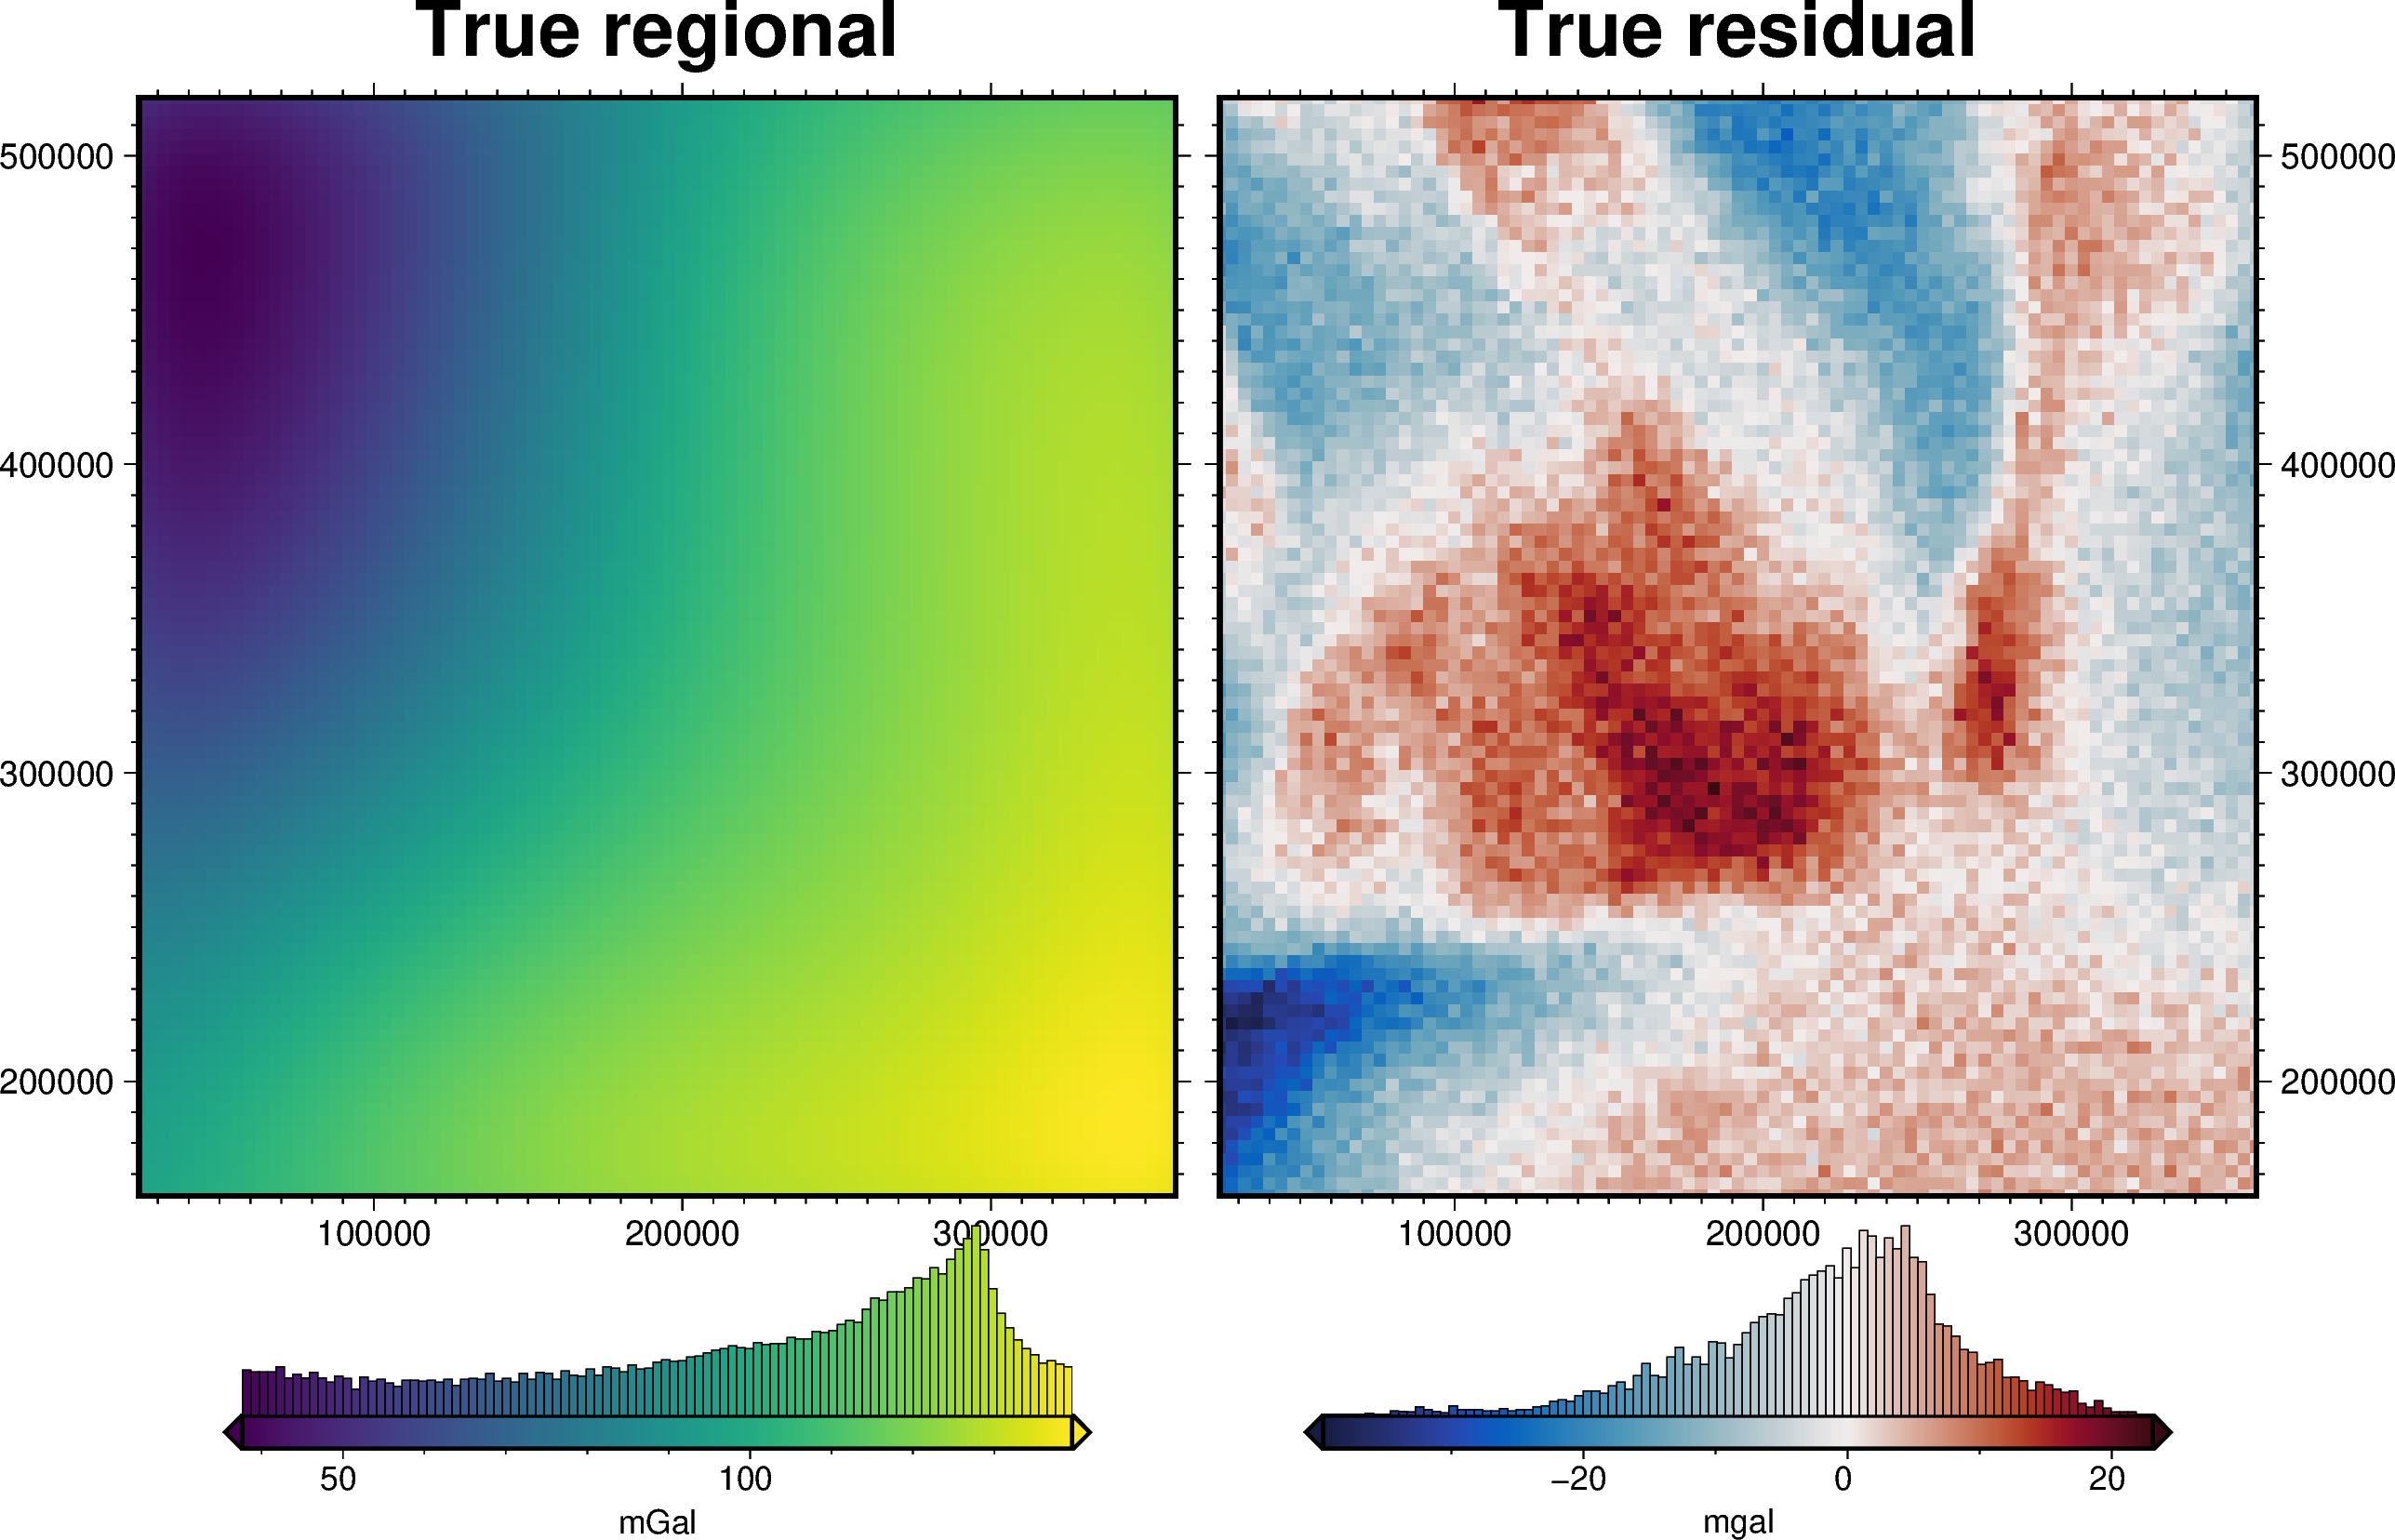

In [14]:
fig = maps.plot_grd(
    grav_grid.moho_grav,
    fig_height=10,
    title="True regional",
    cbar_label="mGal",
    hist=True,
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.true_res,
    fig=fig,
    cmap="balance+h0",
    origin_shift="xshift",
    fig_height=10,
    title="True residual",
    cbar_label="mgal",
    hist=True,
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig.show()

# True-Estimated regional plotting function

In [15]:
def regional_comparison(df, regional_column):
    # grid the results
    grav_grid = df.set_index(["northing", "easting"]).to_xarray()

    # compare with true regional
    _ = polar_utils.grd_compare(
        grav_grid.moho_grav,
        grav_grid[regional_column],
        robust=True,
        plot=True,
        grid1_name="True regional field",
        grid2_name="Estimated regional field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )
    # compare with true residual
    _ = polar_utils.grd_compare(
        grav_grid.true_res,
        grav_grid.res,
        cmap="balance+h0",
        robust=True,
        plot=True,
        grid1_name="True residual field",
        grid2_name="Estimated residual field",
        hist=True,
        inset=False,
        verbose="q",
        title="difference",
        grounding_line=False,
        points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
        points_style="x.3c",
    )

# Save data so other notebooks can use it later


In [16]:
# save gravity dataframe
grav_df.to_csv("tmp/regional_sep_grav_df.csv")

# save constraint points
constraint_points.to_csv("tmp/regional_sep_constraint_points.csv")

# merge and save grids
ds = xr.merge(
    [
        basement_topo.rename("basement"),
        moho_topo.rename("moho"),
        starting_topography.rename("starting"),
    ]
)
ds.to_netcdf("tmp/regional_sep_grids.nc")

starting_prisms.to_netcdf("tmp/regional_sep_starting_prisms.nc")

## Regional estimation methods

Now that we have a gravity misfit (difference between the true observed gravity and the forward calculated gravity from our knowledge of the topography), we can try and separate out the portion of the misfit not related to our lack of understanding of the topography. This is the **regional misfit** and in this case is resulting from our lower layer of prisms.

There are 4 main techniques: a **constant** value for the regional field, **filtering** the misfit to get the regional, fitting a polynomial **trend** to the misfit to get the regional, calculating the long-wavelength component of the misfit using the **equivalent sources** method, and finding a regional field by using point of known elevation for the layer of interest (**constraint point minimization**).

In [17]:
grav_df.describe()

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000  
mean    101.157045       101.157045     2.0          1.548275    -1.245492  
std       9.701881         9.918000     0.0         24.921606     9.332421  
min      75.622259        70.865584     2.0        -36.407174   -39.690986  
25%      96.219224        96.092694     2.0        -17.405060    -6.457196  
50%     102.149393       102.057121     2.0         -3.039717    -0.024313  
75%     106.786022       107.005035     2.0         19.819674     4.762689  
max     126.324788       129.731888     2.0         59.686931    23.112321

### Constant value

#### 1) Constant value equal to average value of gravity misfit at constraint points

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 91.19338822398358 mGal


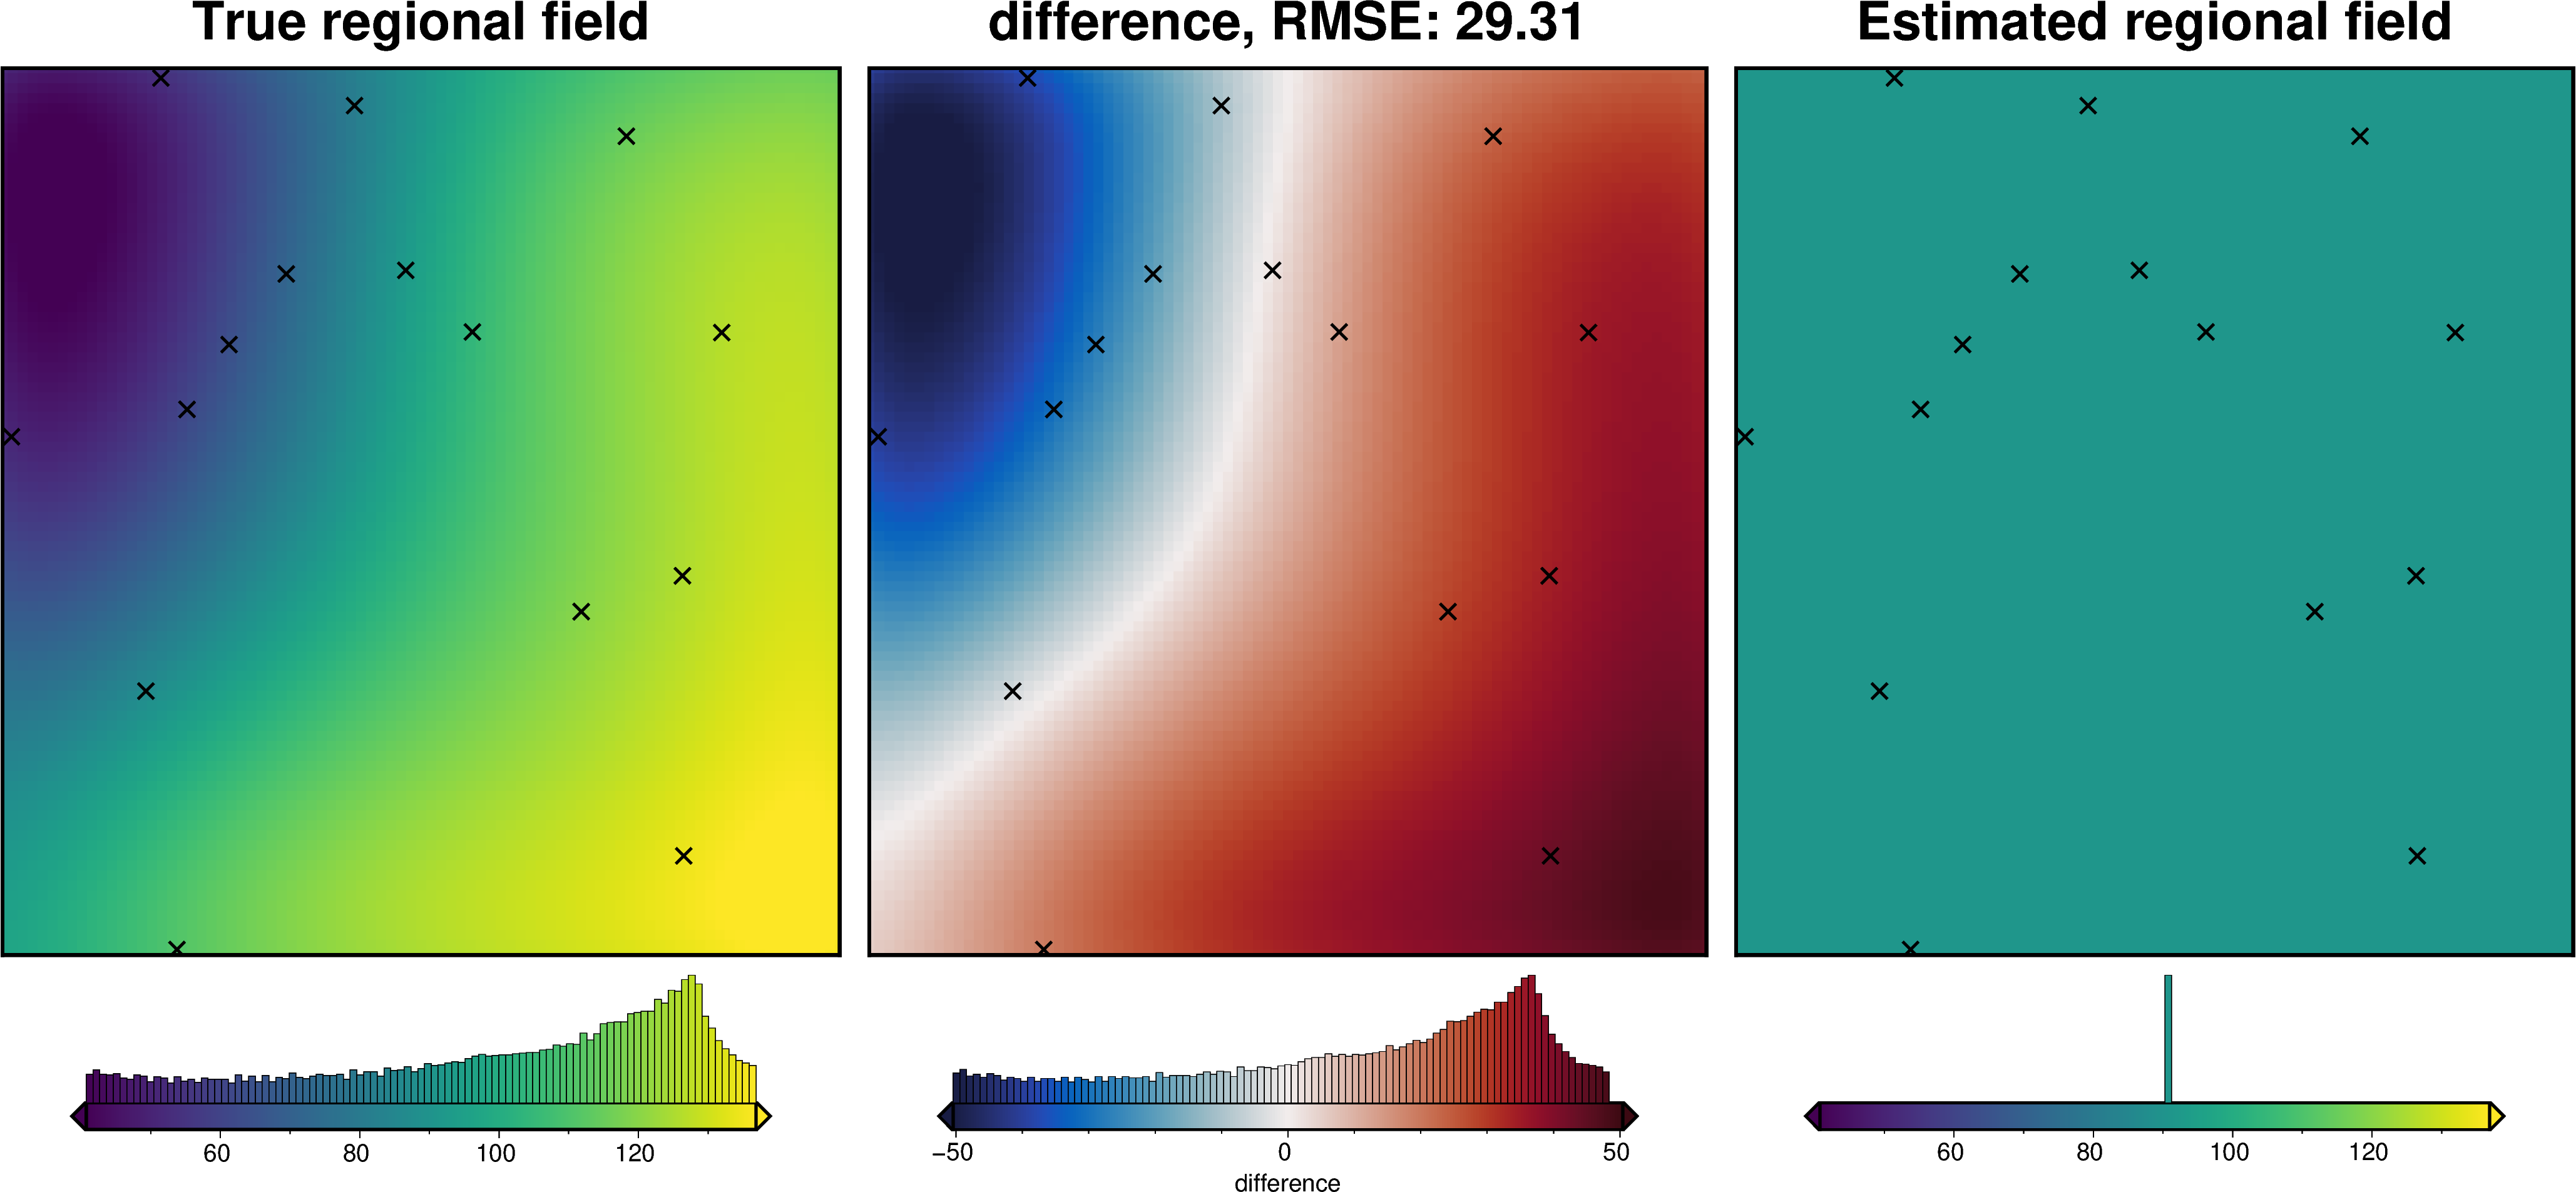

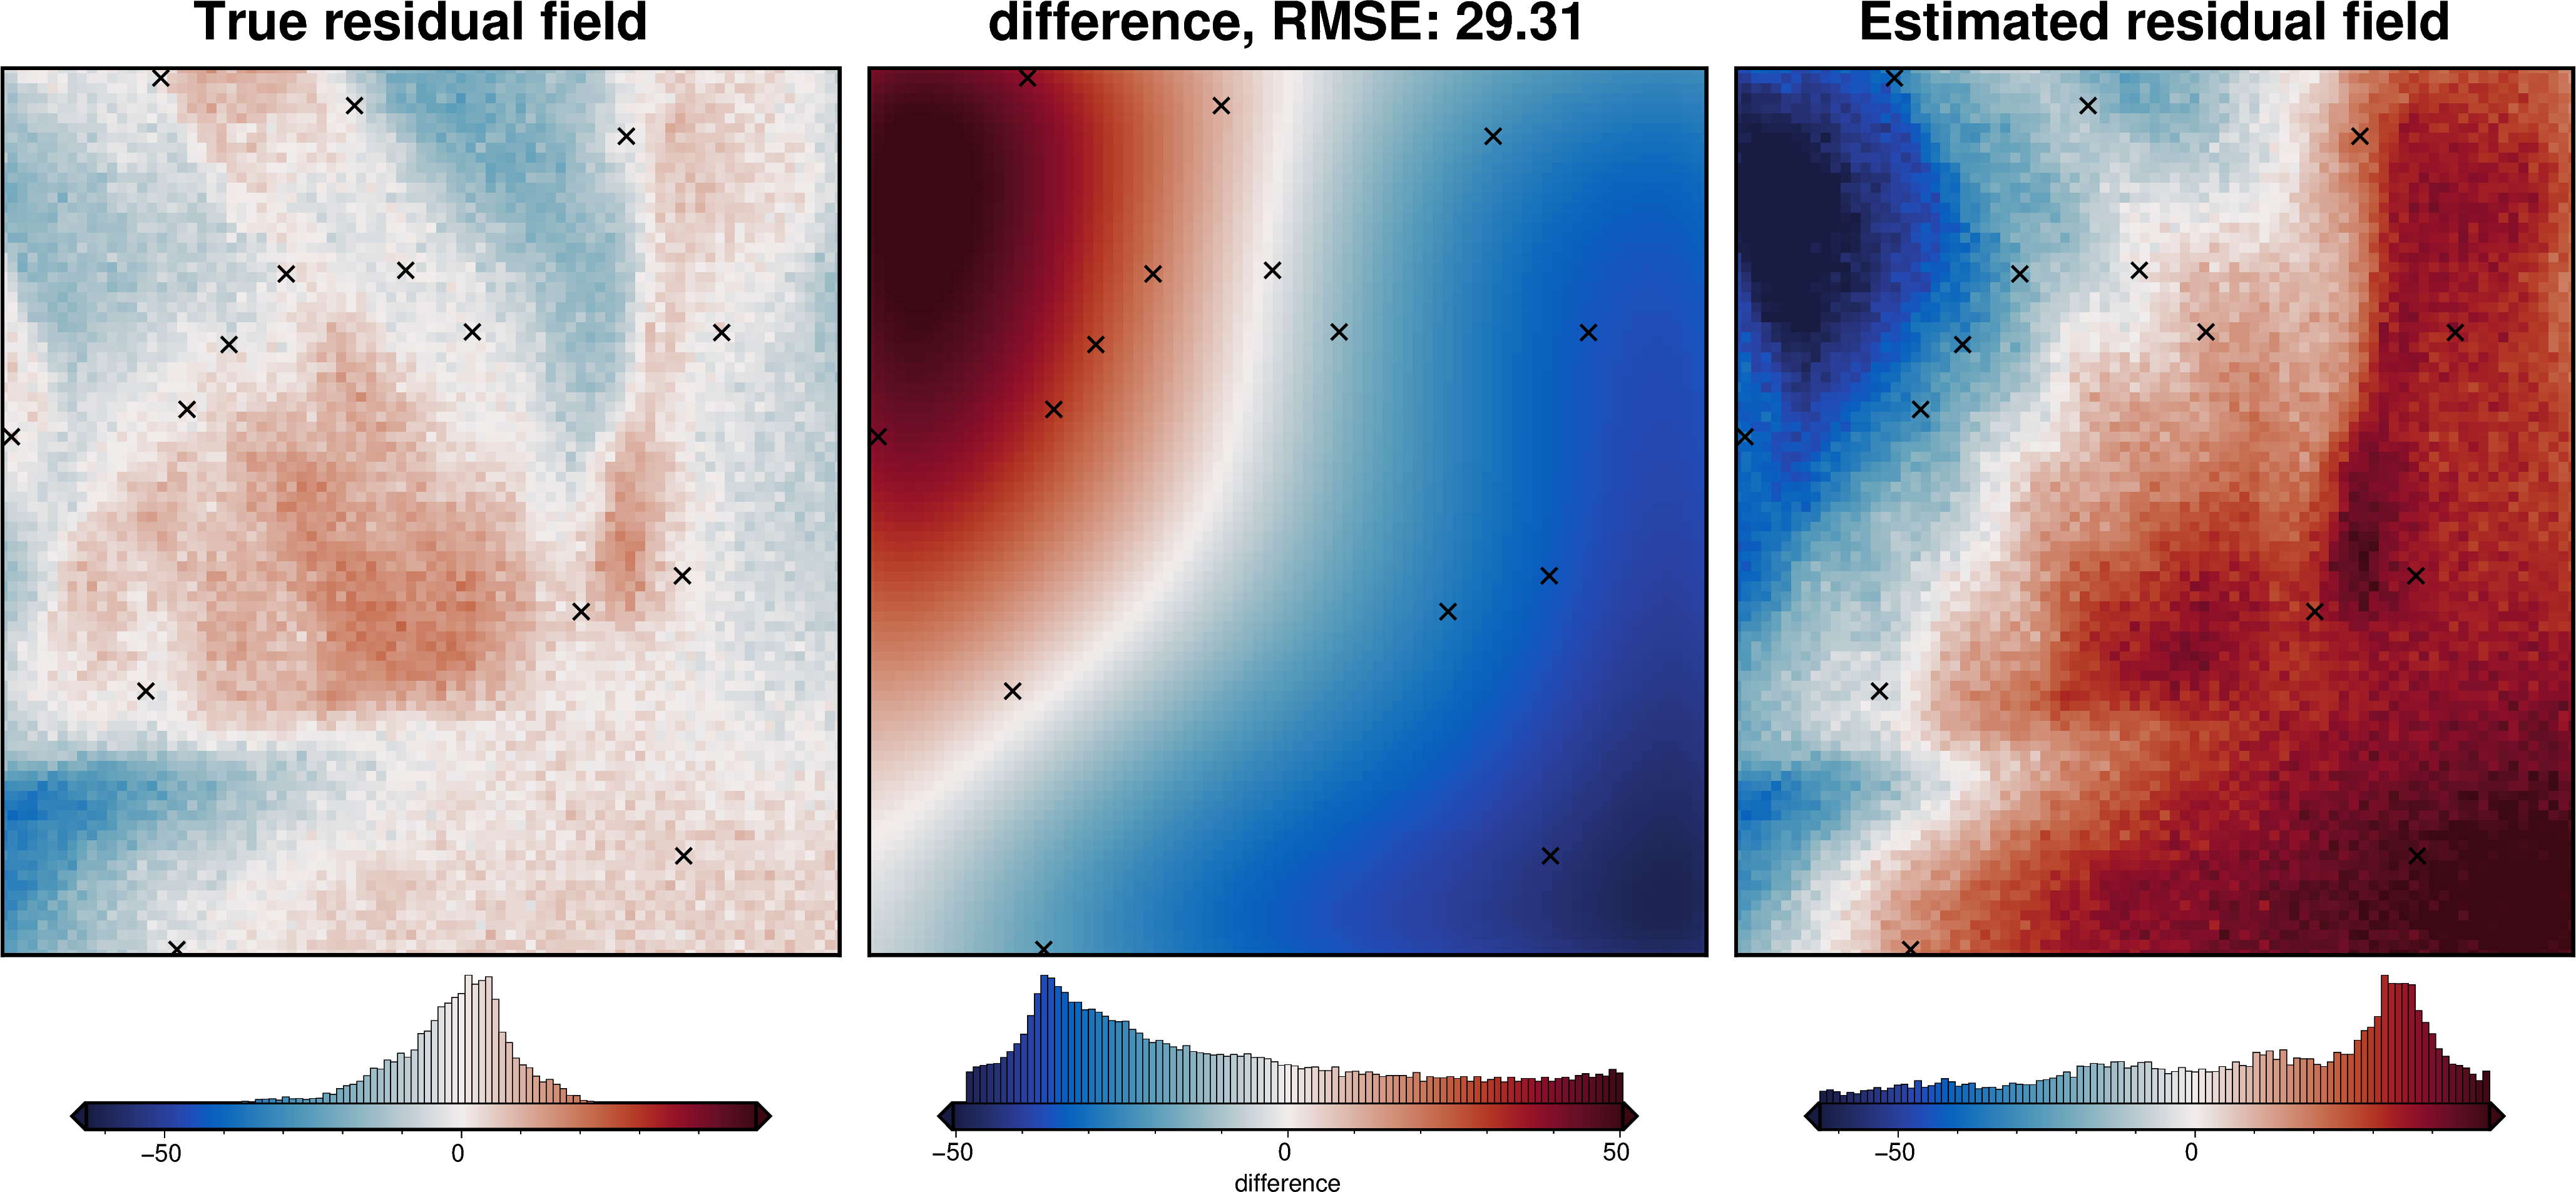

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

            misfit           reg          res  constant_reg  constant_res  
count  7650.000000  7.650000e+03  7650.000000  7.650000e+03   7650.000000  
mean     99.608770  9.119339e+01     8.415382  9.119339e+01      8.415382  
std      30.575680  1.421178e-14    30.575680  1.421178e-14     30.575680  
min      17.957513  9.119339e+01   -73.235875  9.119339e+01    -73.235875  
25%      78.148025  9.119339e+01   -13.045363  9.119339e+01    -13.045363  
50%     107.148801  9.119339e+01    15.955413  9.119339e+01     15.955413  
75%     124.908087  9.119339e+01    33.714699  9.119339e+01     33.714699  
max     148.082017  9.119339e+01    56.888629  9.119339e+01     56.888629

In [18]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constraints_df=constraint_points,
)
grav_df["constant_reg"] = grav_df.reg
grav_df["constant_res"] = grav_df.res

regional_comparison(grav_df, "constant_reg")

grav_df.describe()

#### 2) apply a custom constant value

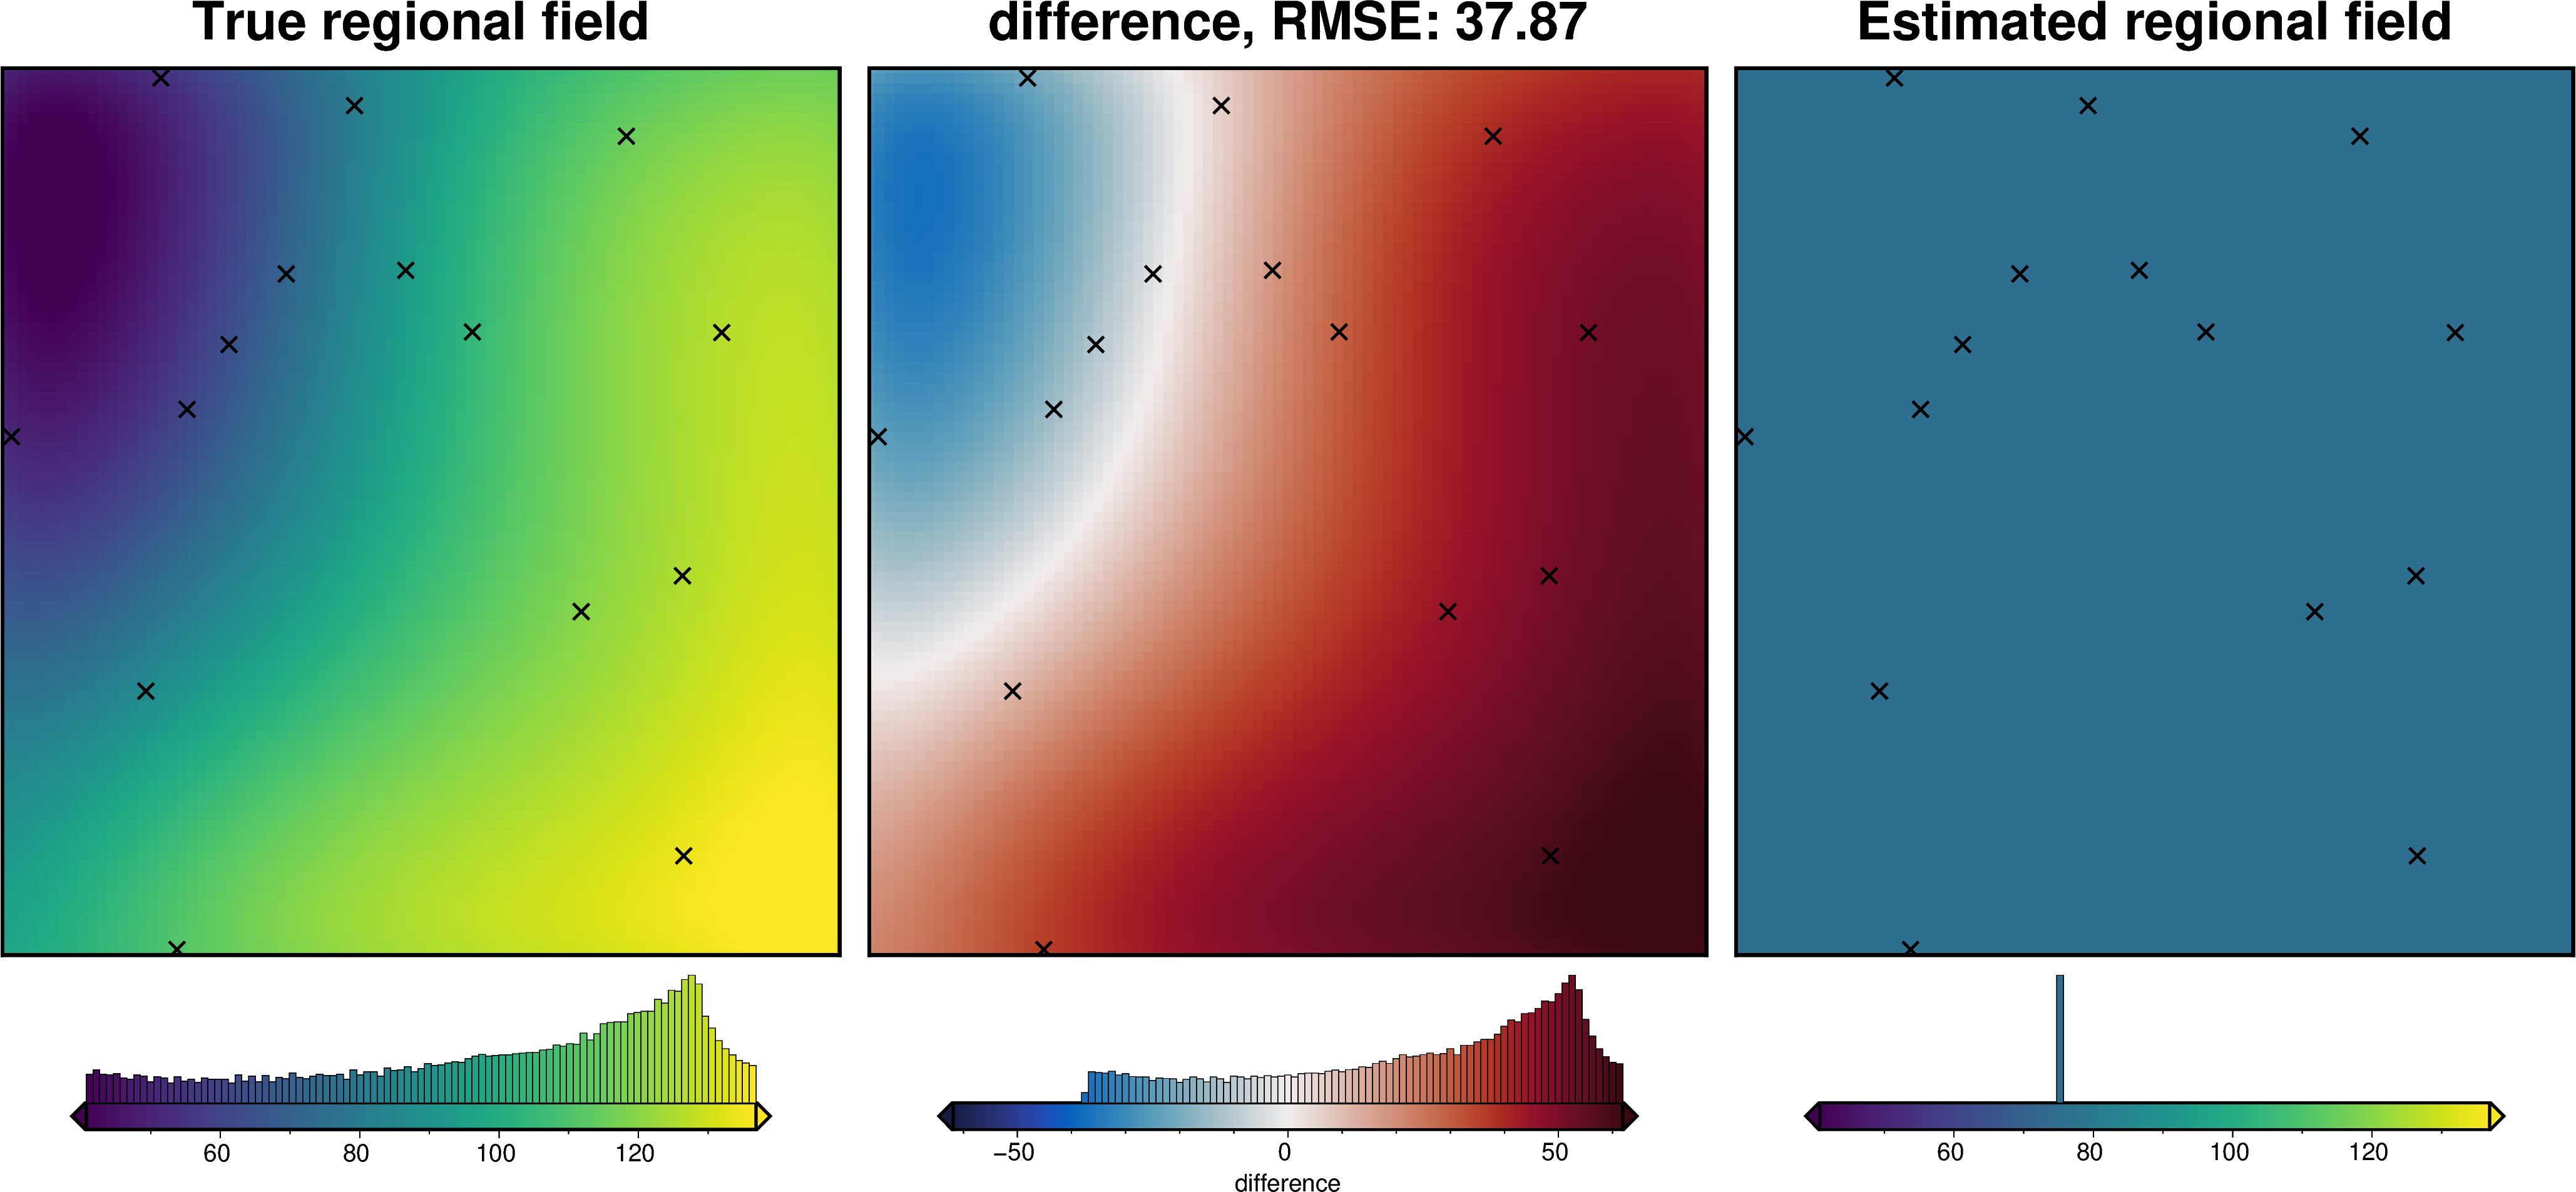

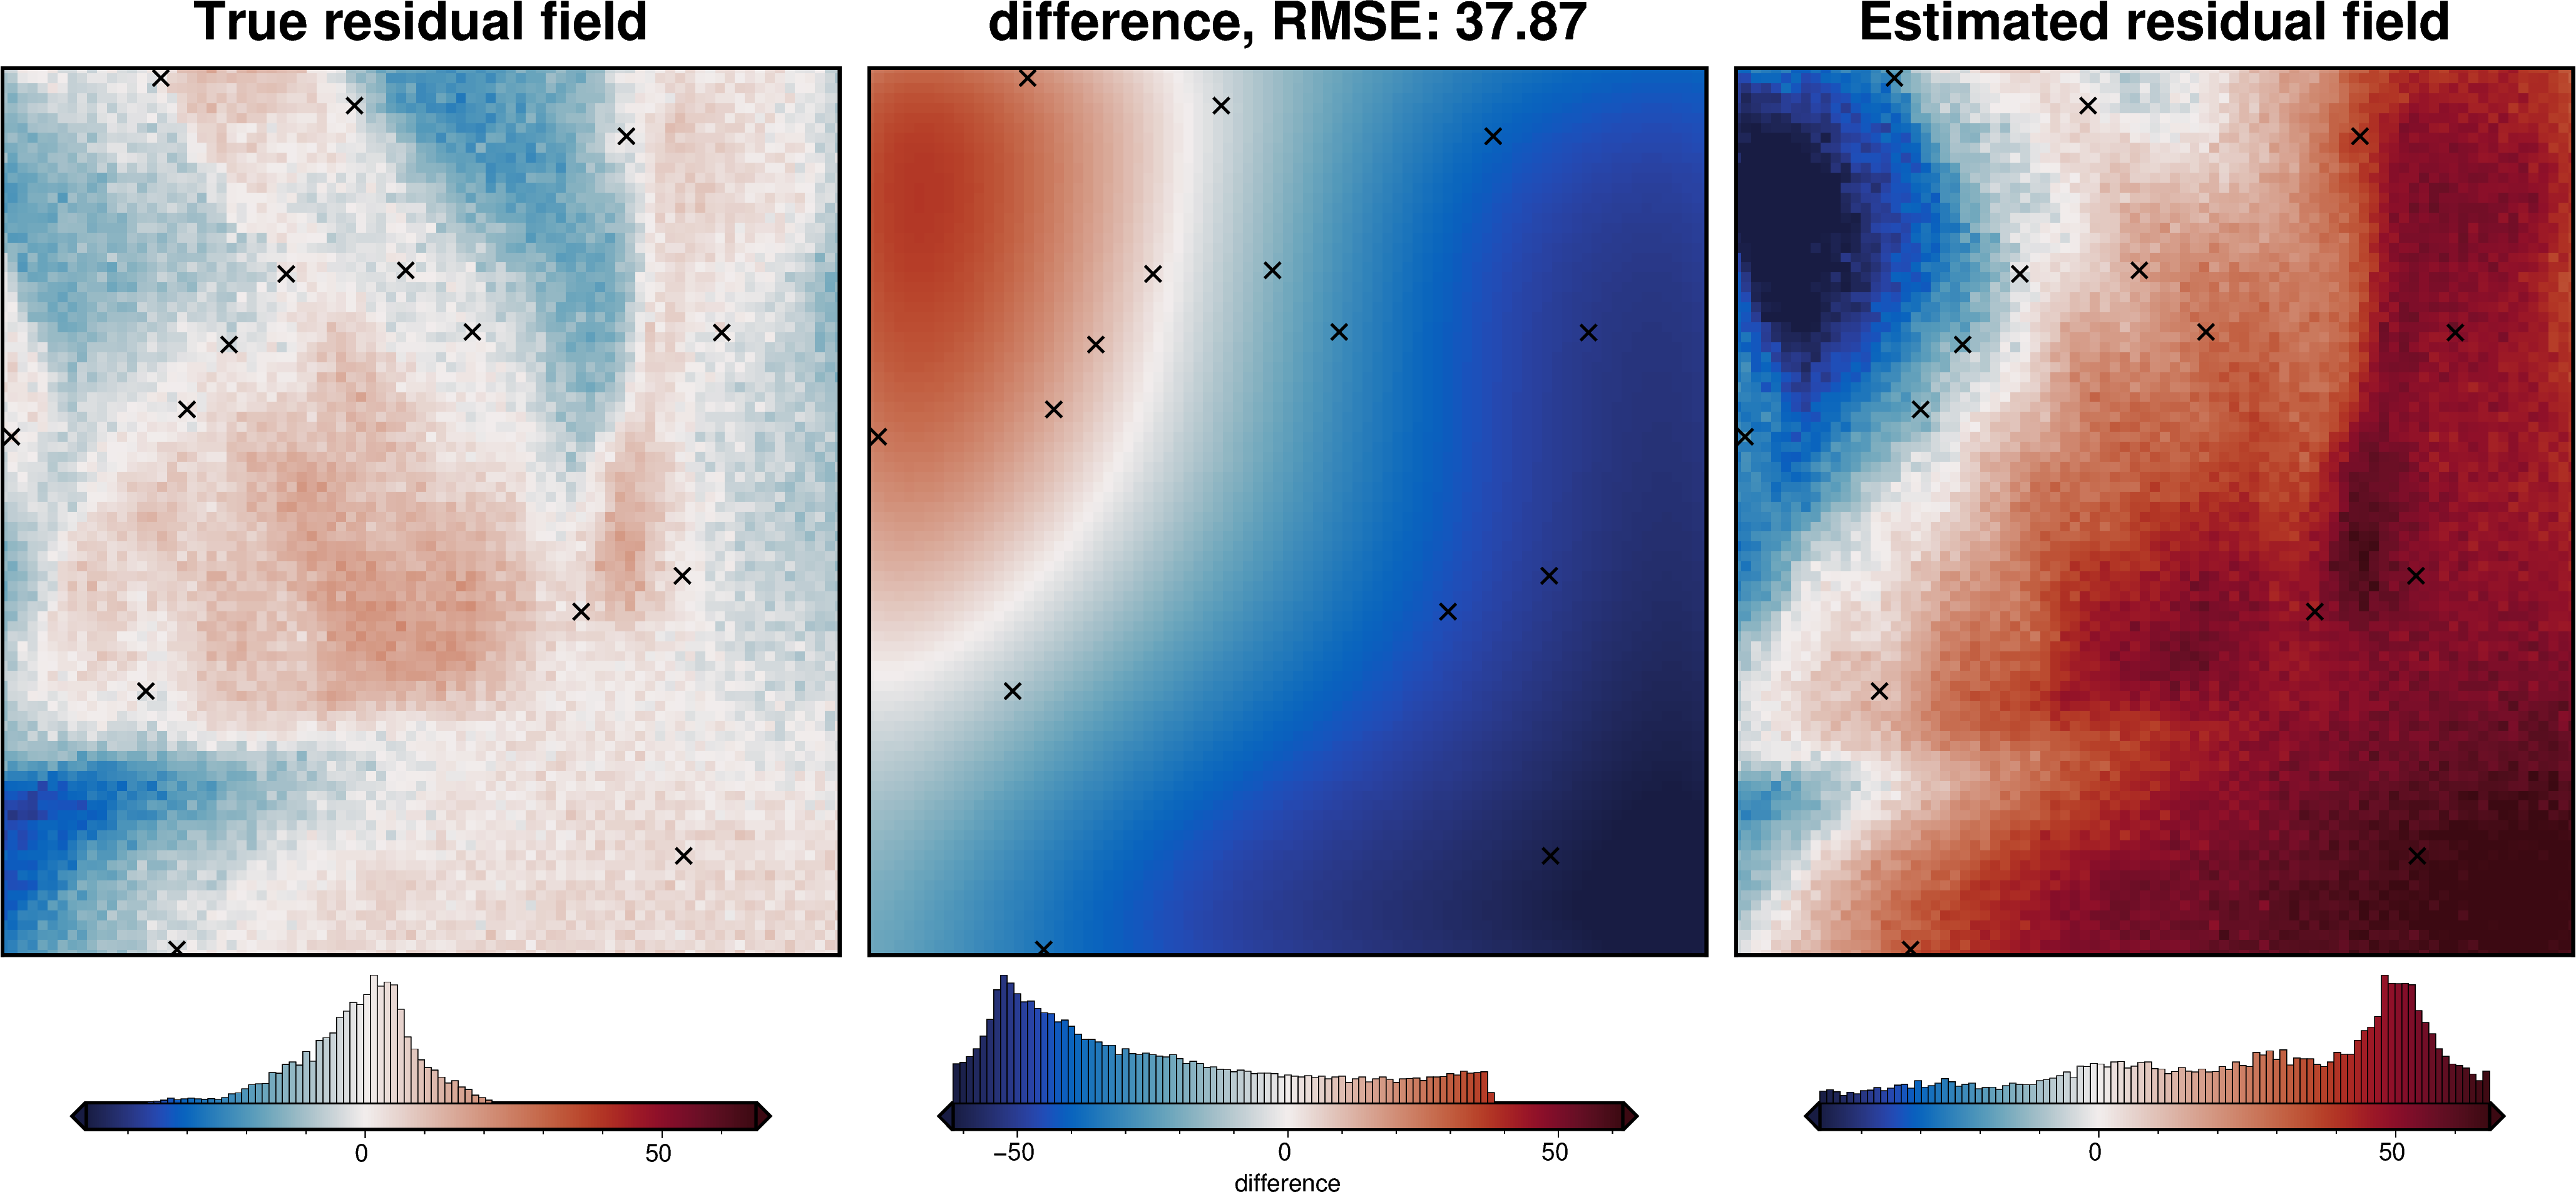

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

            misfit     reg          res  constant_reg  constant_res  \
count  7650.000000  7650.0  7650.000000  7.650000e+03   7650.000000   
mean     99.608770    75.0    24.608770  9.119339e+01      8.415382   
std      30.575680     0.0    30.575680  1.421178e-14     30.575680   
min      17.957513    75.0   -57.042487  9.119339e+01    -73.235875   
25%      78.148025    75.0     3.148025  9.119339e+01    -13.045363   
50%     107.148801    75.0    32.148801  9.119339e+01     15.955413   
75%     124.908087    75.0    49.908087  9.119339e+01     33.714699   
max     148.082017    75.0    73.082017  9.119339e+01     56.888629   

       constant_custom_reg  constant_custom_res  
count               7650.0          7650.000000  
mean                  75.0            24.608770  
std                    0.0            30.575680  
min                   75.0           -57.042487  
25%                   75.0             3.148025  
50%                   75.0            32.148801  
75%                   75.0            49.908087  
max                   75.0            73.082017

In [19]:
# estimate regional with the custom constant value
grav_df = regional.regional_constant(
    grav_df=grav_df,
    constant=75,
)
grav_df["constant_custom_reg"] = grav_df.reg
grav_df["constant_custom_res"] = grav_df.res

regional_comparison(grav_df, "constant_custom_reg")

grav_df.describe()

### Filter

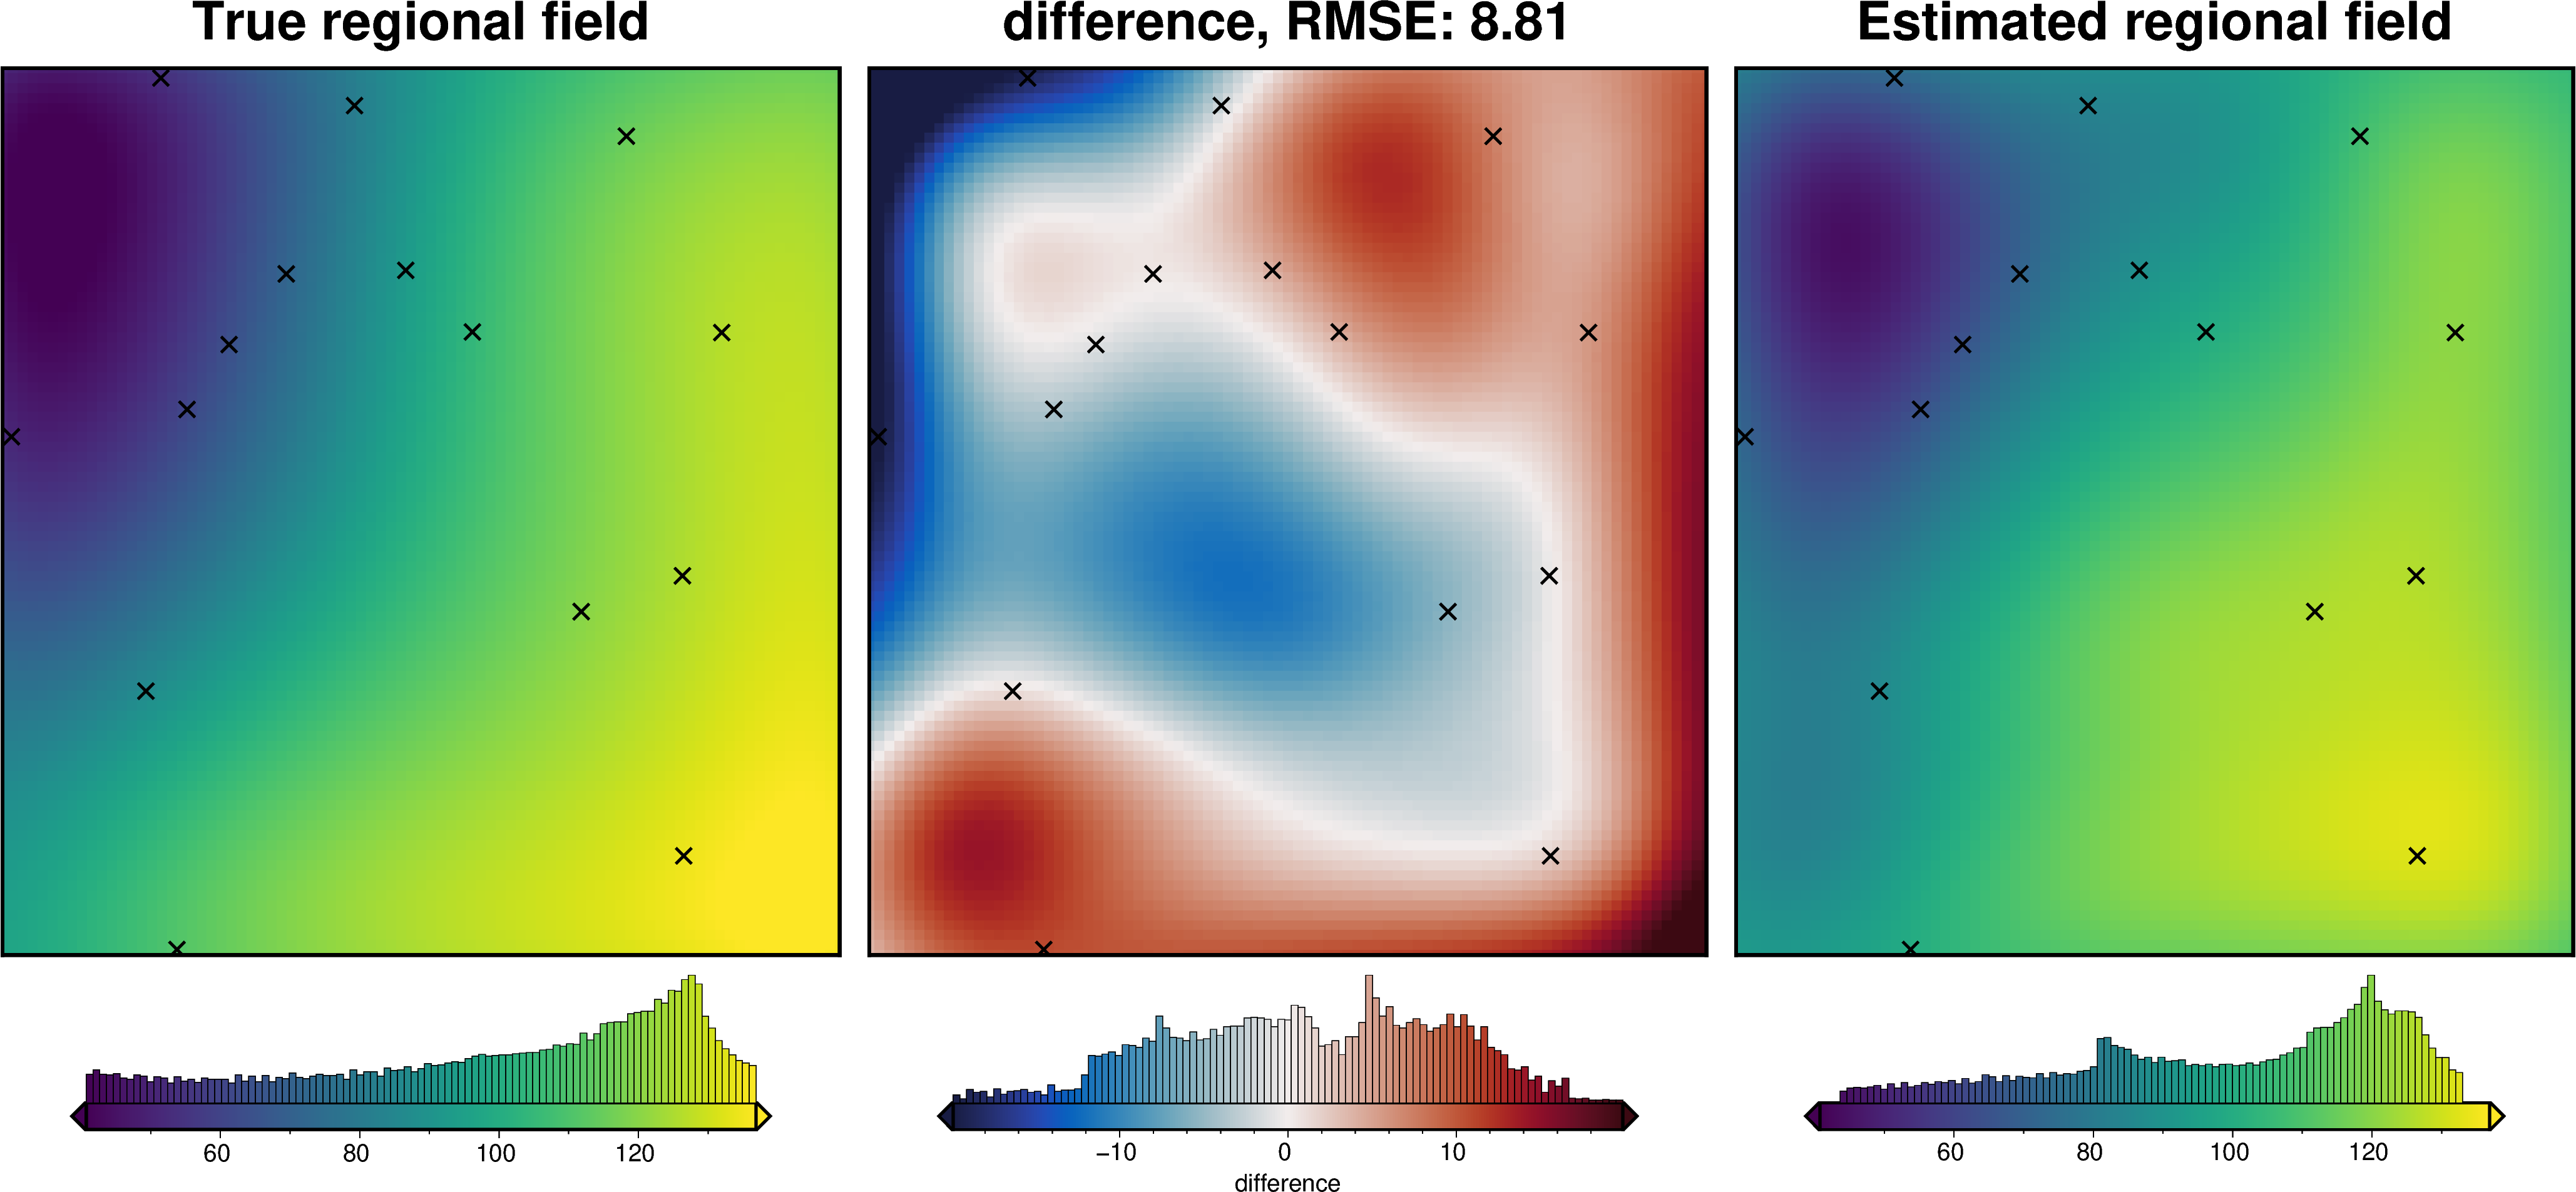

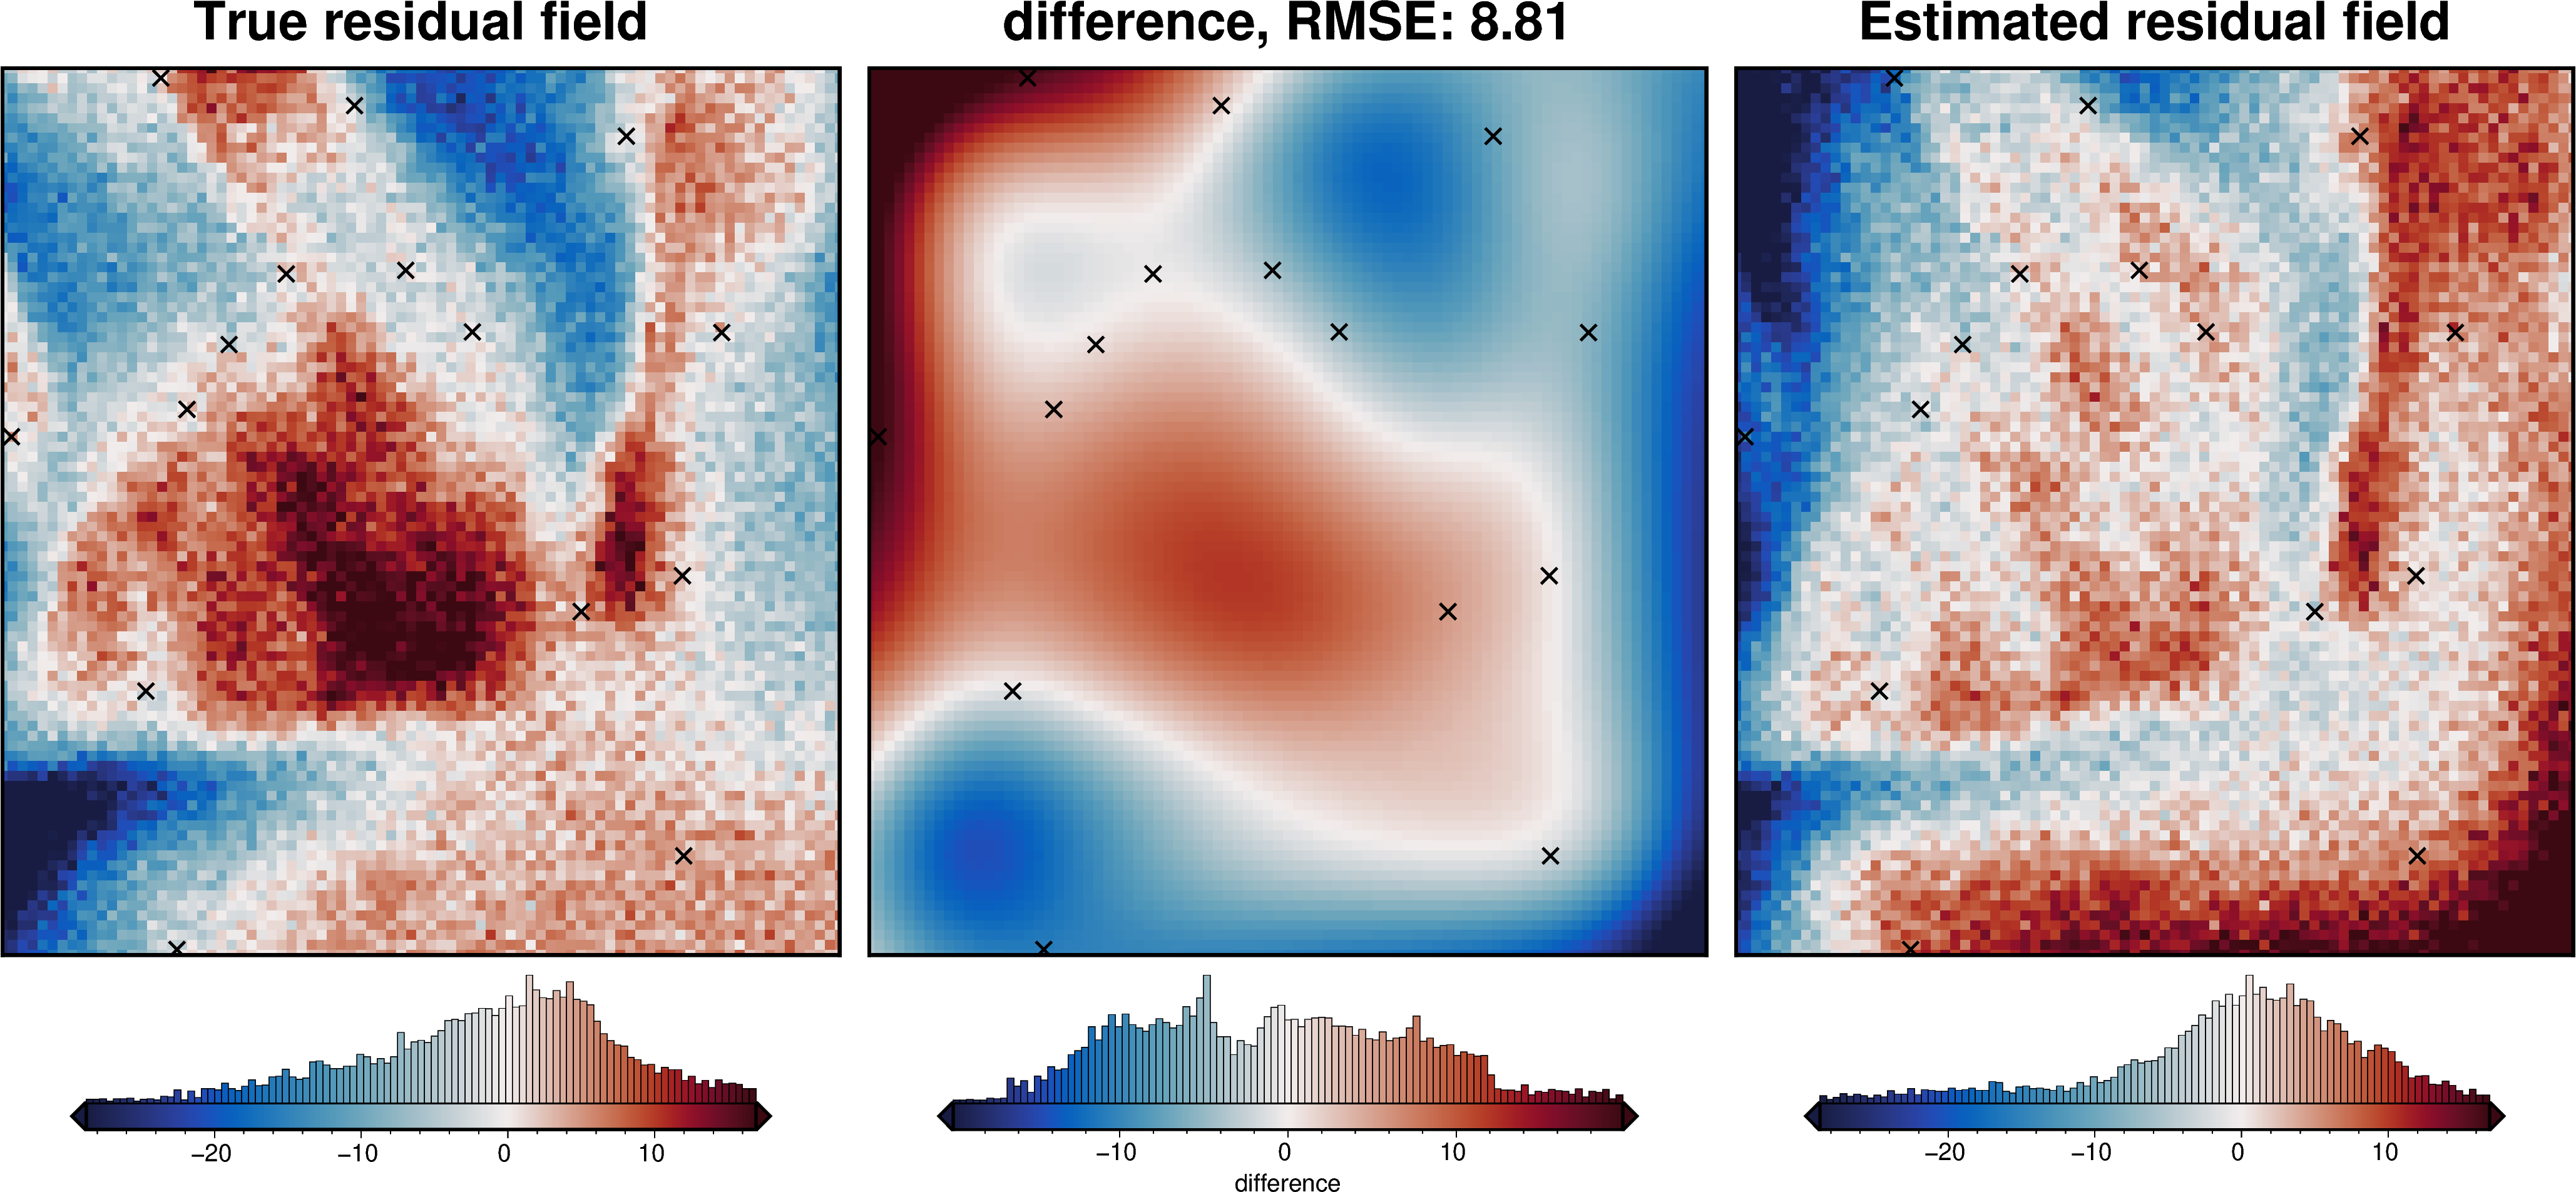

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

            misfit          res  constant_reg  constant_res  \
count  7650.000000  7650.000000  7.650000e+03   7650.000000   
mean     99.608770    -0.616946  9.119339e+01      8.415382   
std      30.575680    10.193347  1.421178e-14     30.575680   
min      17.957513   -44.345125  9.119339e+01    -73.235875   
25%      78.148025    -4.395330  9.119339e+01    -13.045363   
50%     107.148801     0.805637  9.119339e+01     15.955413   
75%     124.908087     5.439712  9.119339e+01     33.714699   
max     148.082017    31.284771  9.119339e+01     56.888629   

       constant_custom_reg  constant_custom_res          reg   filter_reg  \
count               7650.0          7650.000000  7650.000000  7650.000000   
mean                  75.0            24.608770   100.225716   100.225716   
std                    0.0            30.575680    23.000784    23.000784   
min                   75.0           -57.042487    43.873104    43.873104   
25%                   75.0             3.148025    83.131474    83.131474   
50%                   75.0            32.148801   106.624451   106.624451   
75%                   75.0            49.908087   119.661959   119.661959   
max                   75.0            73.082017   132.913055   132.913055   

        filter_res  
count  7650.000000  
mean     -0.616946  
std      10.193347  
min     -44.345125  
25%      -4.395330  
50%       0.805637  
75%       5.439712  
max      31.284771

In [20]:
# estimate regional with a 200km low pass filter
grav_df = regional.regional_filter(
    grav_df=grav_df,
    filter_width=200e3,
)
grav_df["filter_reg"] = grav_df.reg
grav_df["filter_res"] = grav_df.res

regional_comparison(grav_df, "filter_reg")

grav_df.describe()

### Trend

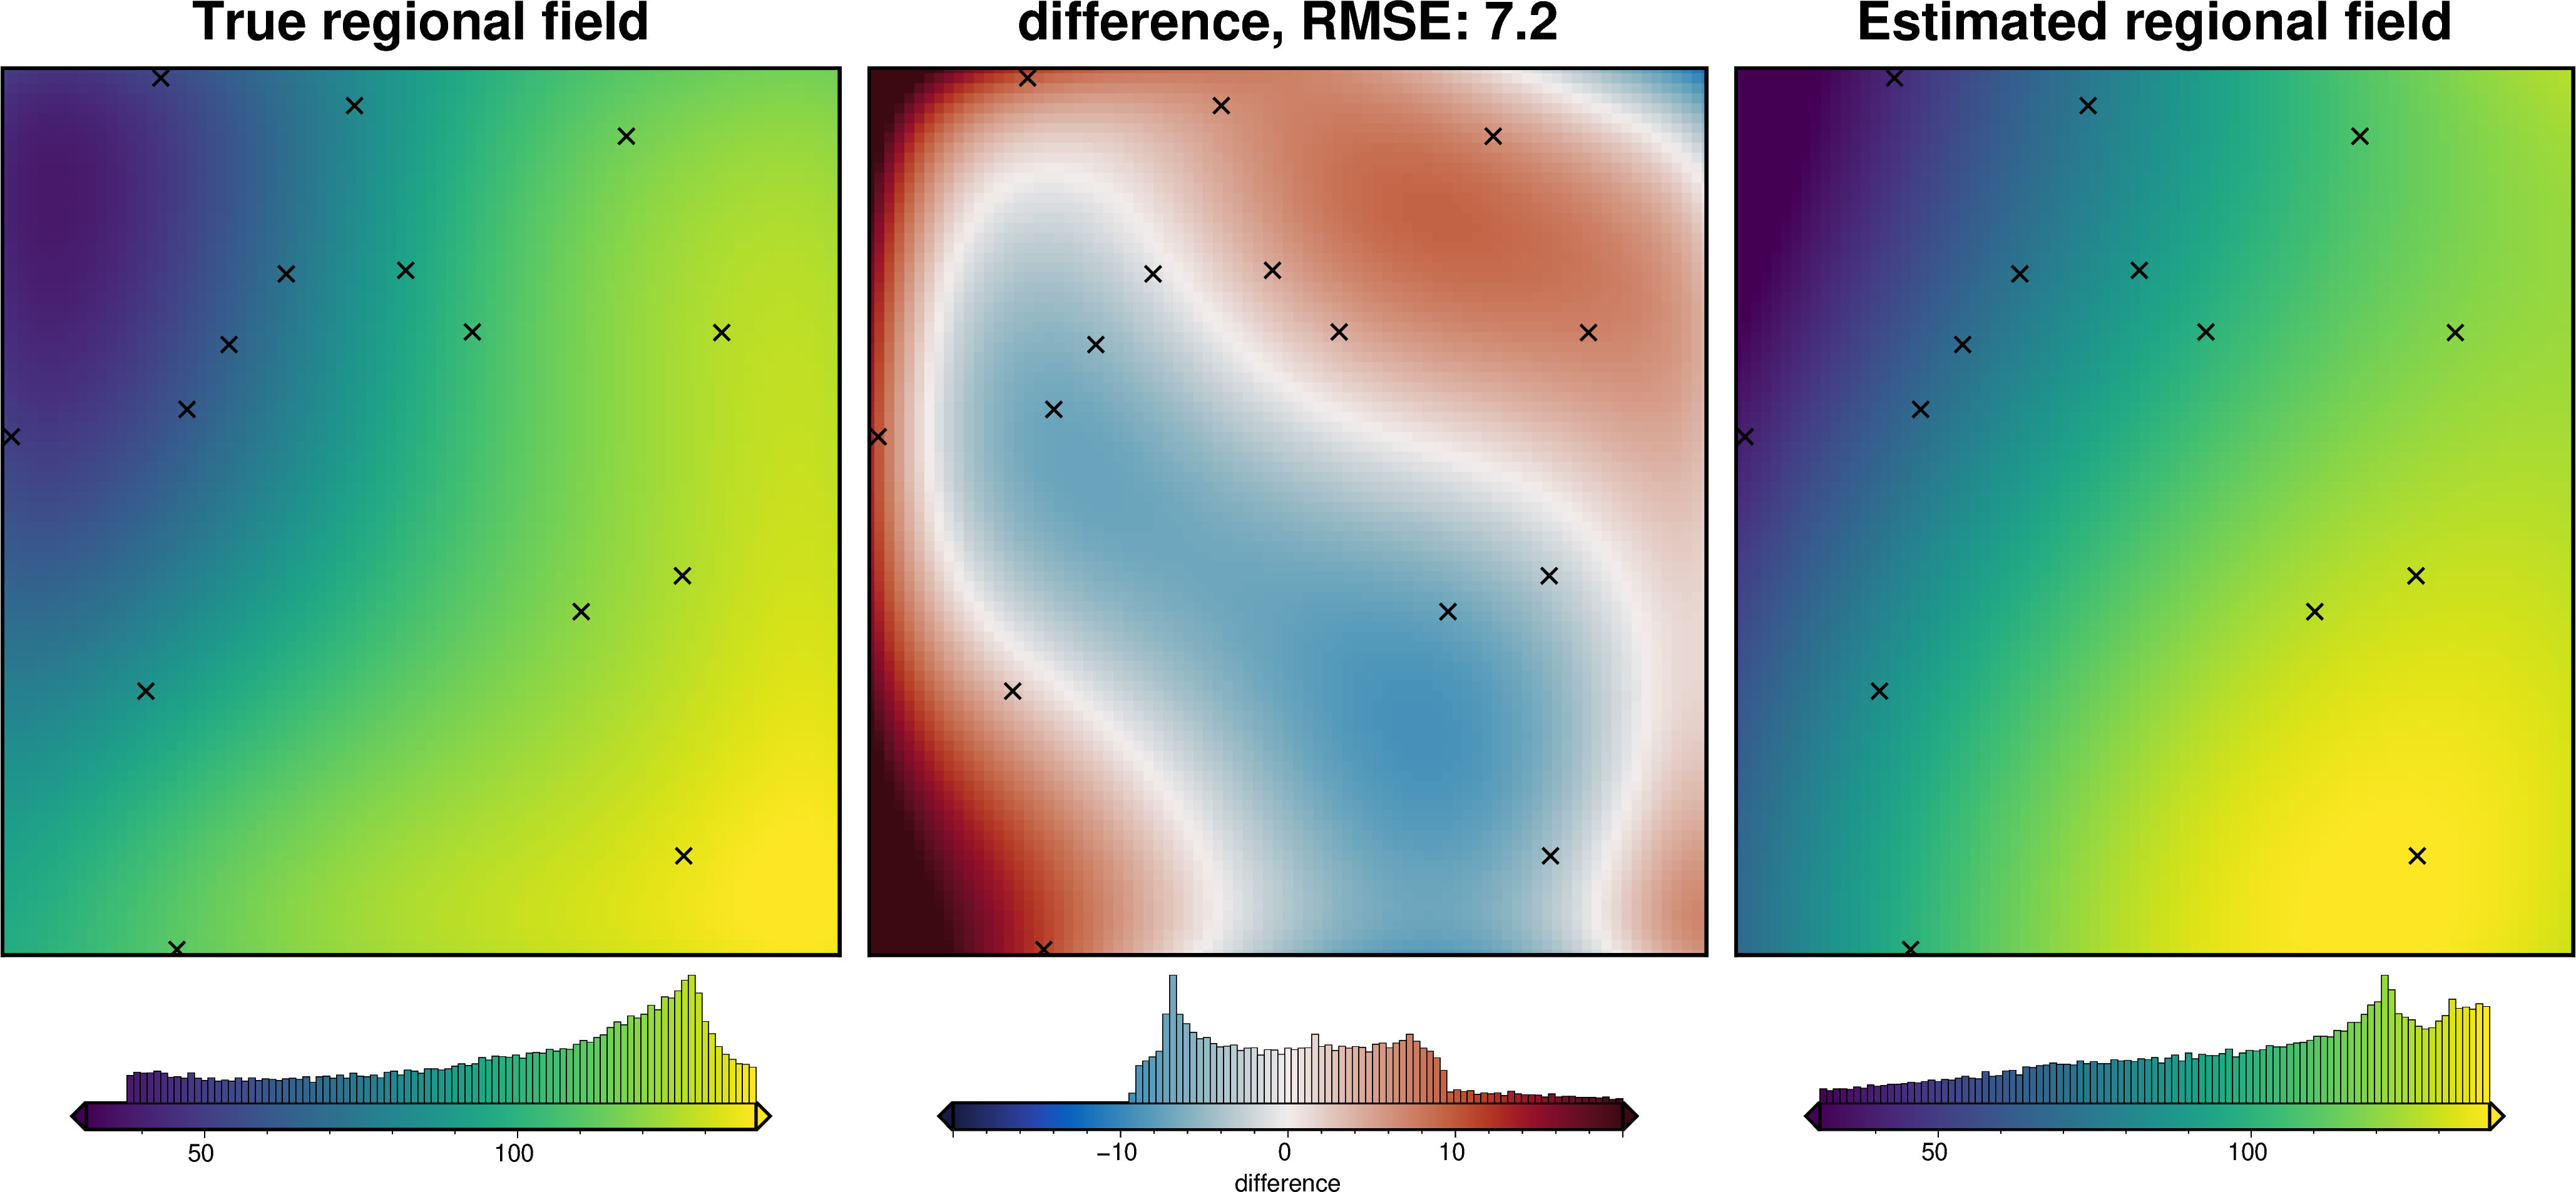

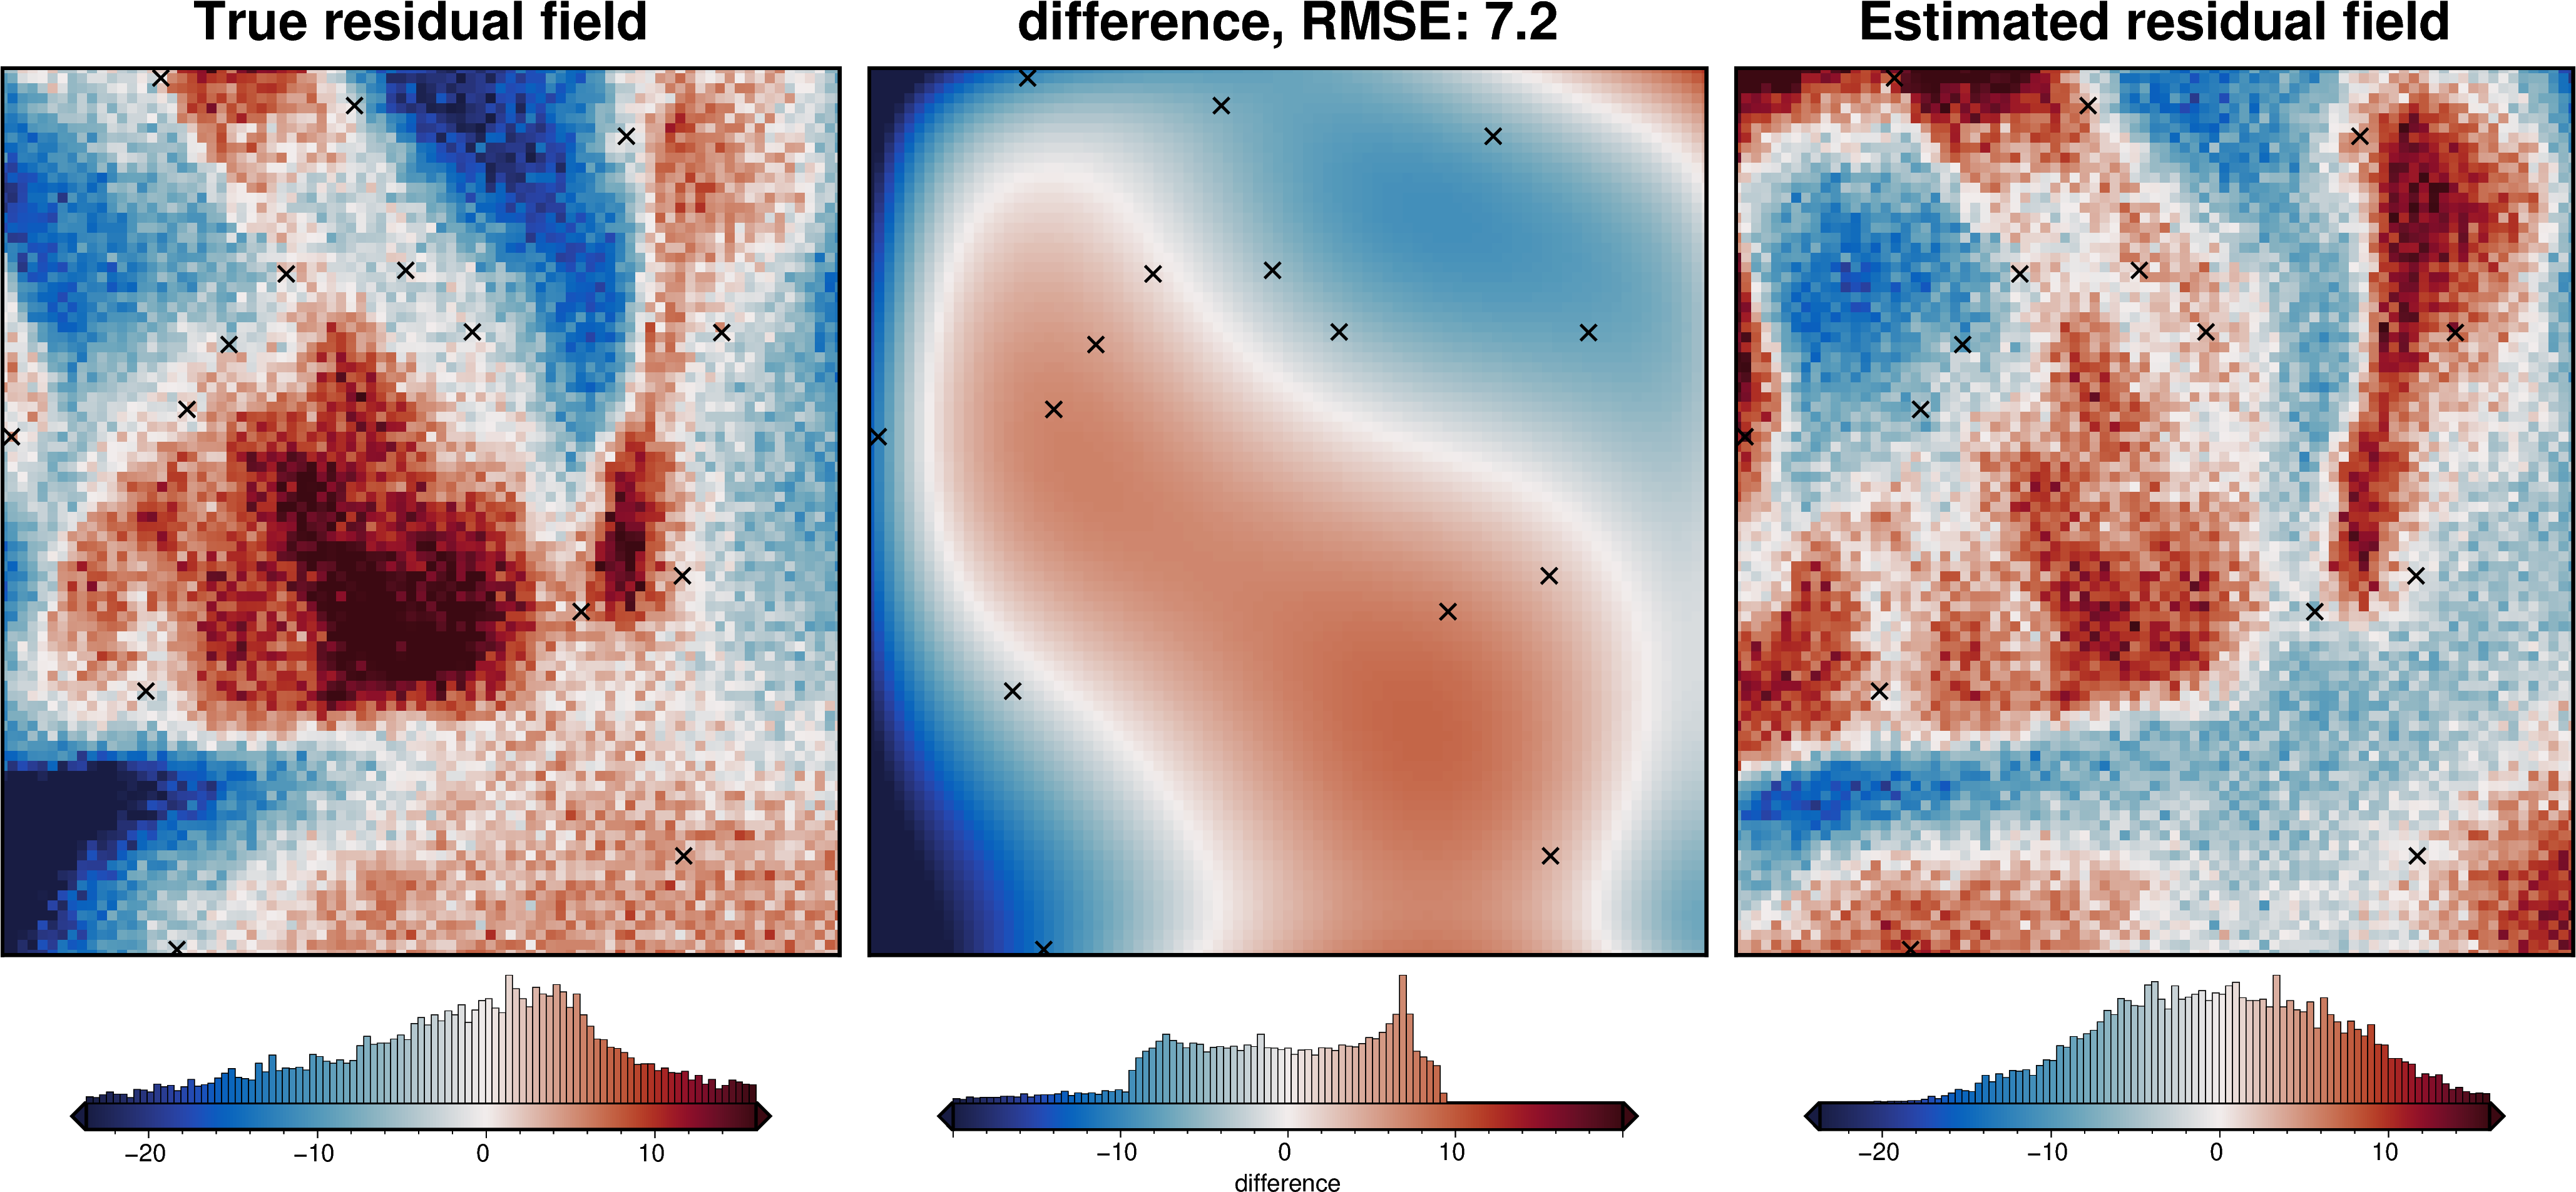

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...           res  constant_reg  constant_res  constant_custom_reg  \
count  ...  7.650000e+03  7.650000e+03   7650.000000               7650.0   
mean   ... -6.545984e-13  9.119339e+01      8.415382                 75.0   
std    ...  7.004693e+00  1.421178e-14     30.575680                  0.0   
min    ... -2.015281e+01  9.119339e+01    -73.235875                 75.0   
25%    ... -5.088947e+00  9.119339e+01    -13.045363                 75.0   
50%    ... -3.260685e-02  9.119339e+01     15.955413                 75.0   
75%    ...  5.121365e+00  9.119339e+01     33.714699                 75.0   
max    ...  3.065063e+01  9.119339e+01     56.888629                 75.0   

       constant_custom_res          reg   filter_reg   filter_res  \
count          7650.000000  7650.000000  7650.000000  7650.000000   
mean             24.608770    99.608770   100.225716    -0.616946   
std              30.575680    29.762501    23.000784    10.193347   
min             -57.042487    16.436345    43.873104   -44.345125   
25%               3.148025    78.406023    83.131474    -4.395330   
50%              32.148801   106.921763   106.624451     0.805637   
75%              49.908087   123.768888   119.661959     5.439712   
max              73.082017   138.956974   132.913055    31.284771   

         trend_reg     trend_res  
count  7650.000000  7.650000e+03  
mean     99.608770 -6.545984e-13  
std      29.762501  7.004693e+00  
min      16.436345 -2.015281e+01  
25%      78.406023 -5.088947e+00  
50%     106.921763 -3.260685e-02  
75%     123.768888  5.121365e+00  
max     138.956974  3.065063e+01  

[8 rows x 21 columns]

In [21]:
# estimate regional with fitting a 3rd order trend
grav_df = regional.regional_trend(
    grav_df=grav_df,
    trend=3,
)
grav_df["trend_reg"] = grav_df.reg
grav_df["trend_res"] = grav_df.res

regional_comparison(grav_df, "trend_reg")

grav_df.describe()

### Equivalent Sources

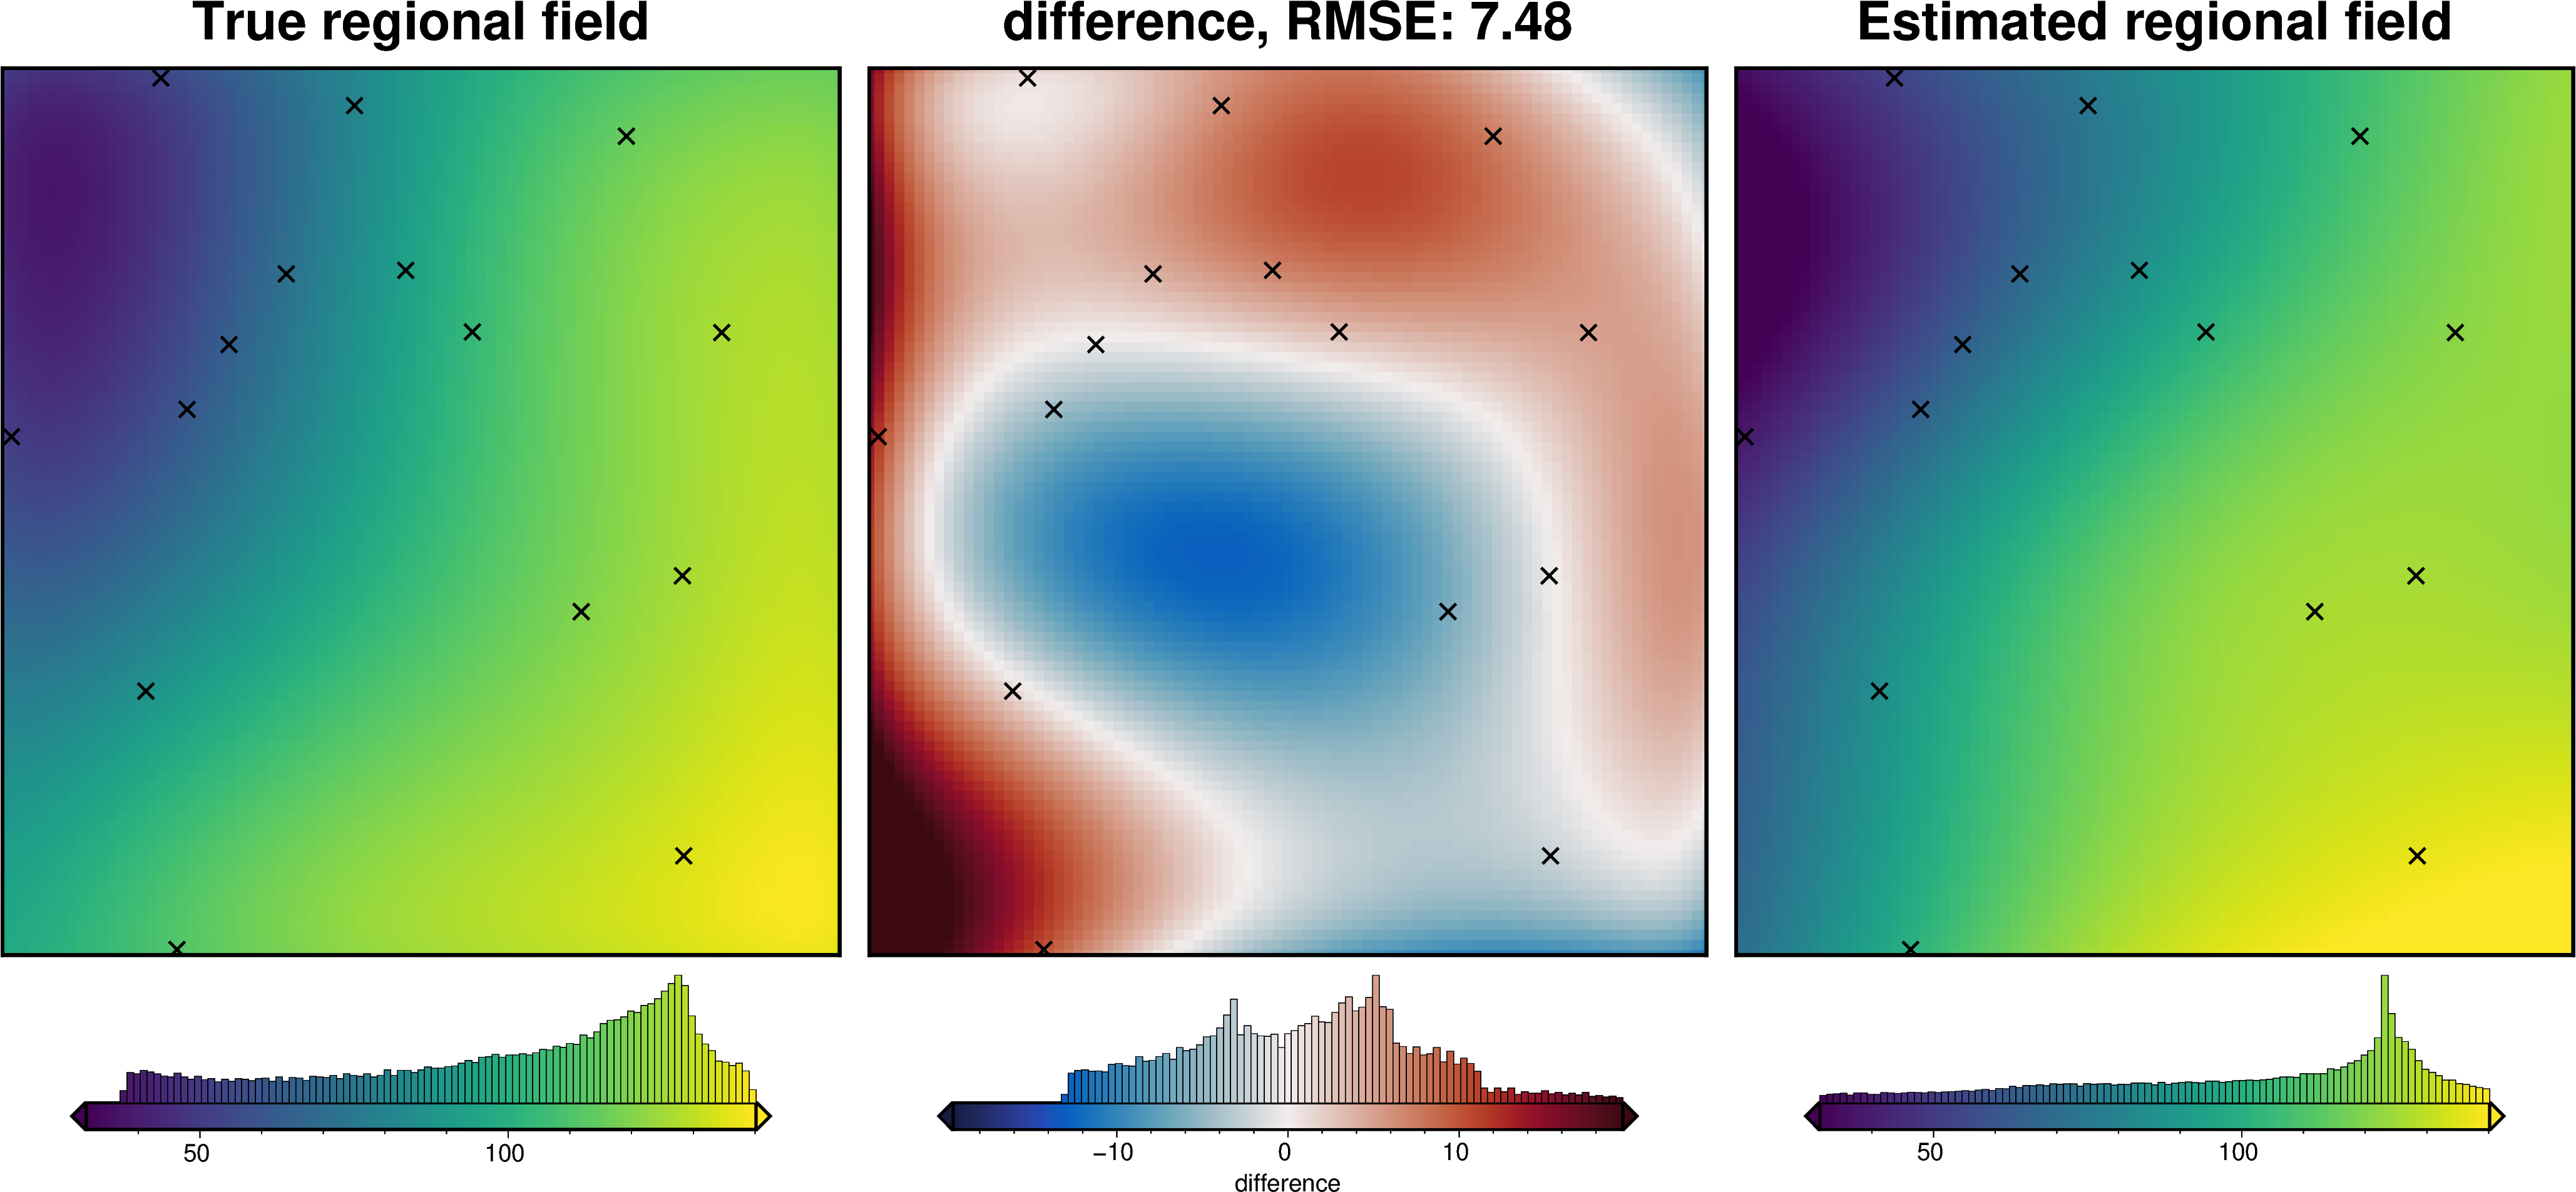

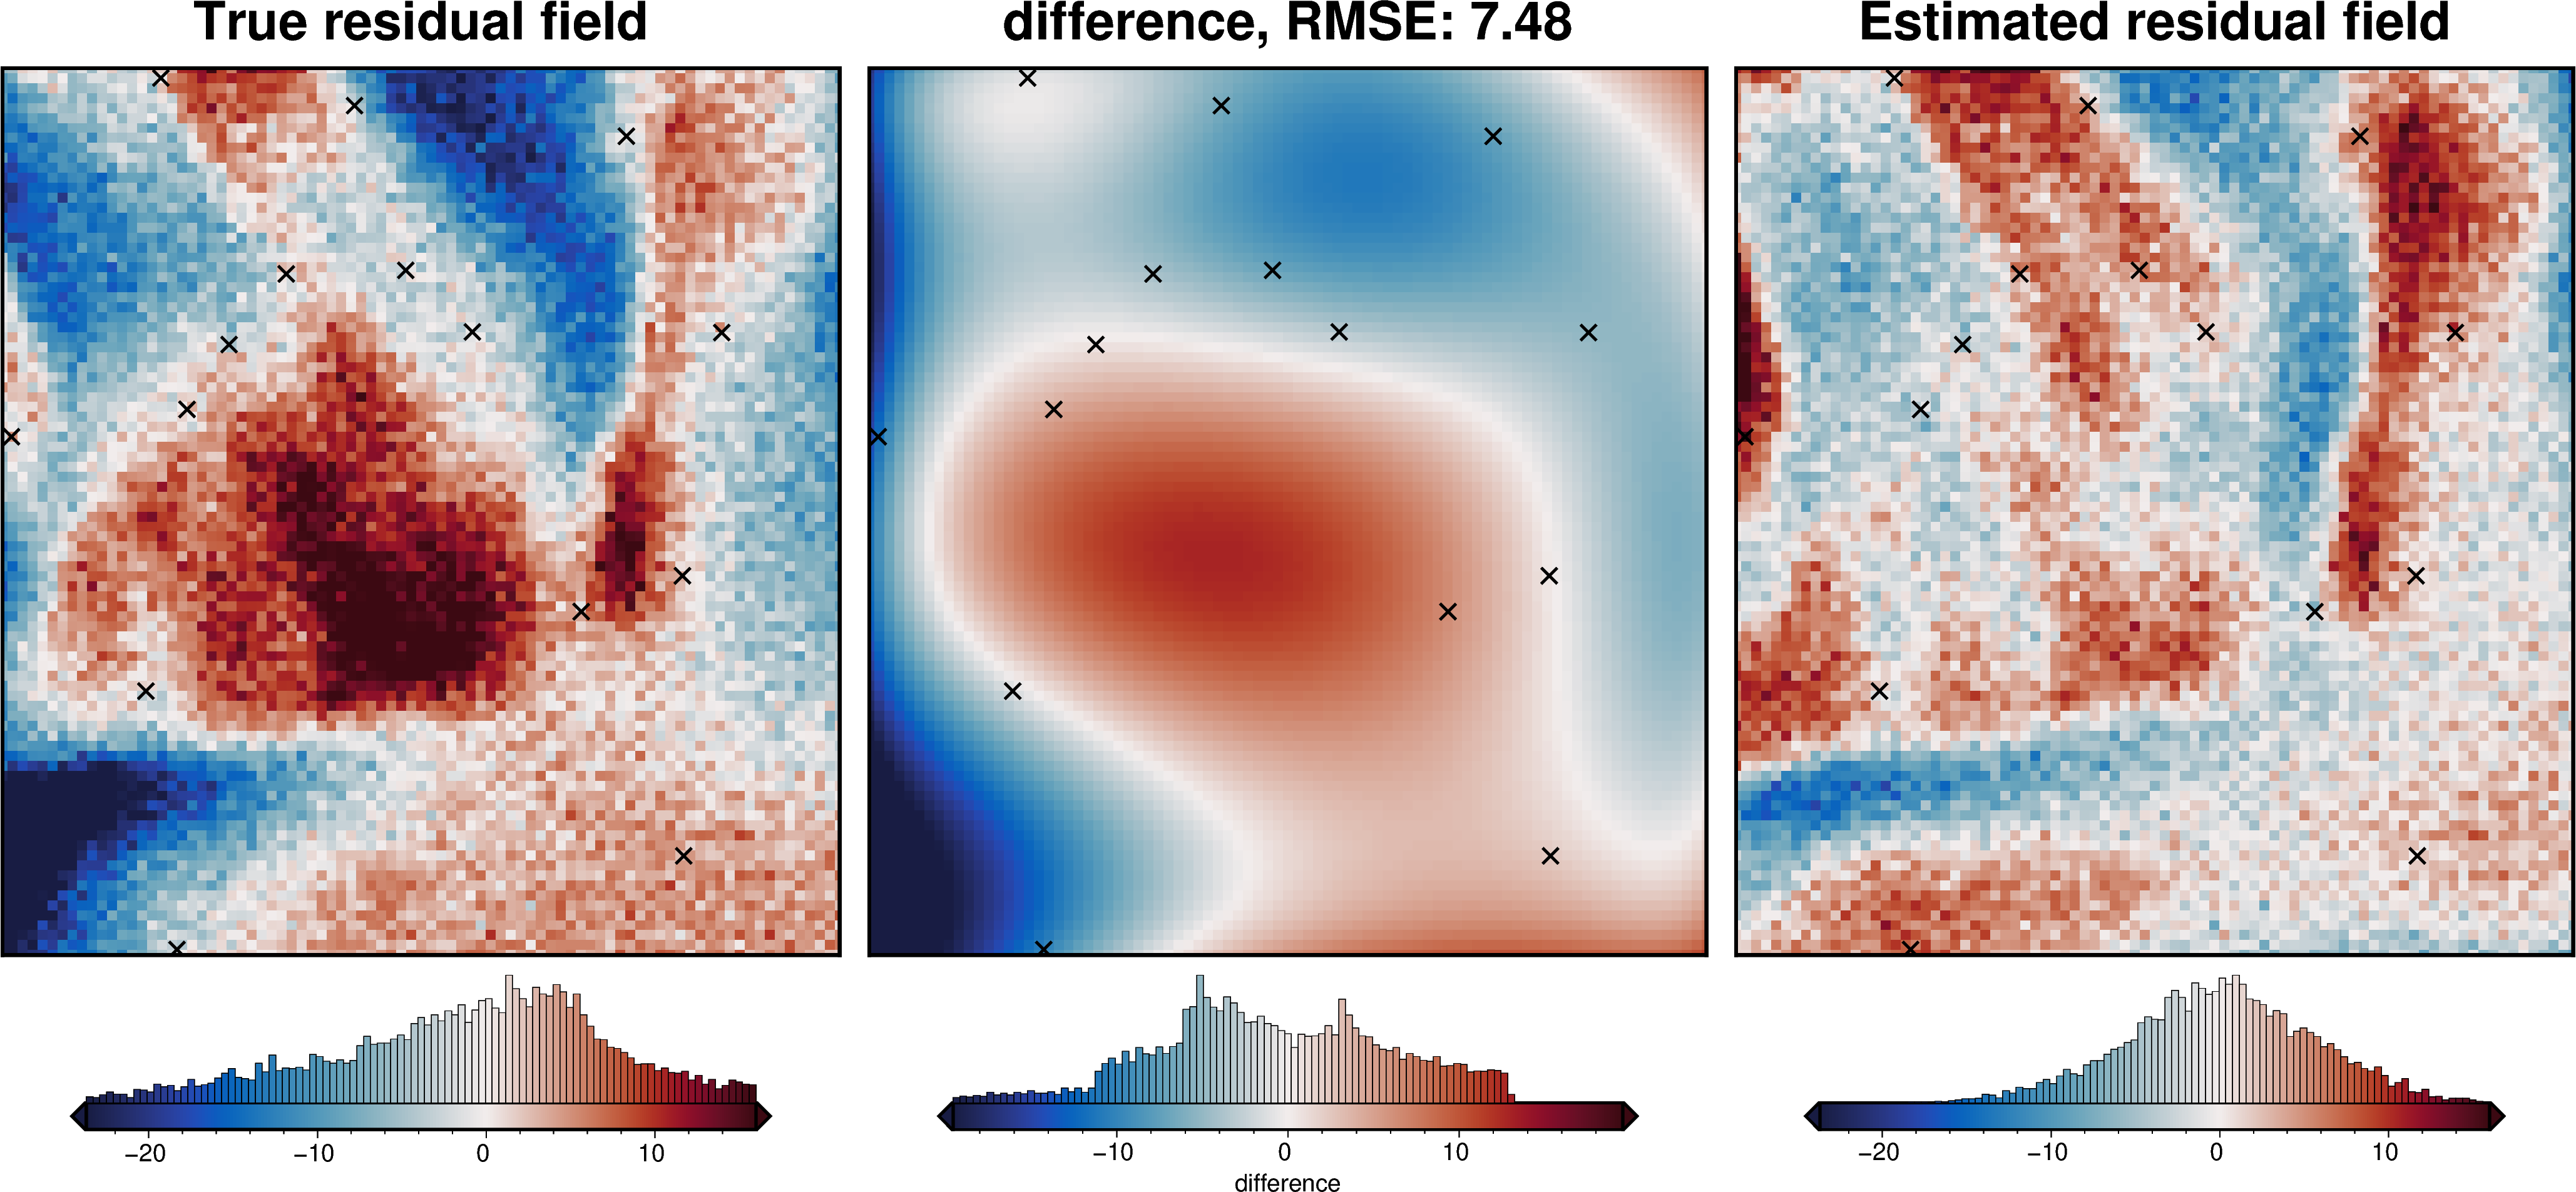

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...  constant_res  constant_custom_reg  constant_custom_res  \
count  ...   7650.000000               7650.0          7650.000000   
mean   ...      8.415382                 75.0            24.608770   
std    ...     30.575680                  0.0            30.575680   
min    ...    -73.235875                 75.0           -57.042487   
25%    ...    -13.045363                 75.0             3.148025   
50%    ...     15.955413                 75.0            32.148801   
75%    ...     33.714699                 75.0            49.908087   
max    ...     56.888629                 75.0            73.082017   

               reg   filter_reg   filter_res    trend_reg     trend_res  \
count  7650.000000  7650.000000  7650.000000  7650.000000  7.650000e+03   
mean     99.529962   100.225716    -0.616946    99.608770 -6.545984e-13   
std      29.881479    23.000784    10.193347    29.762501  7.004693e+00   
min      22.421873    43.873104   -44.345125    16.436345 -2.015281e+01   
25%      77.712625    83.131474    -4.395330    78.406023 -5.088947e+00   
50%     108.692923   106.624451     0.805637   106.921763 -3.260685e-02   
75%     123.542196   119.661959     5.439712   123.768888  5.121365e+00   
max     146.602455   132.913055    31.284771   138.956974  3.065063e+01   

       eq_sources_reg  eq_sources_res  
count     7650.000000     7650.000000  
mean        99.529962        0.078808  
std         29.881479        5.607372  
min         22.421873      -18.291572  
25%         77.712625       -3.555232  
50%        108.692923        0.084635  
75%        123.542196        3.731290  
max        146.602455       22.278320  

[8 rows x 23 columns]

In [22]:
# estimate regional with equivalent sources. This estimates the longwavlength component
# by either
# 1) using deep sources (`depth` parameter)
# 2) upwards continuing the fitted data (`grav_obs_height` parameter)
# 3) apply damping to the fitting (`damping` parameter)
grav_df = regional.regional_eq_sources(
    grav_df=grav_df,
    depth=300e3,
    damping=0.1,
    grav_obs_height=1.5e3,
    block_size=spacing * 10,
)
grav_df["eq_sources_reg"] = grav_df.reg
grav_df["eq_sources_res"] = grav_df.res

regional_comparison(grav_df, "eq_sources_reg")

grav_df.describe()

### Constraint point minimization

#### gridding with PyGMT and tension factors

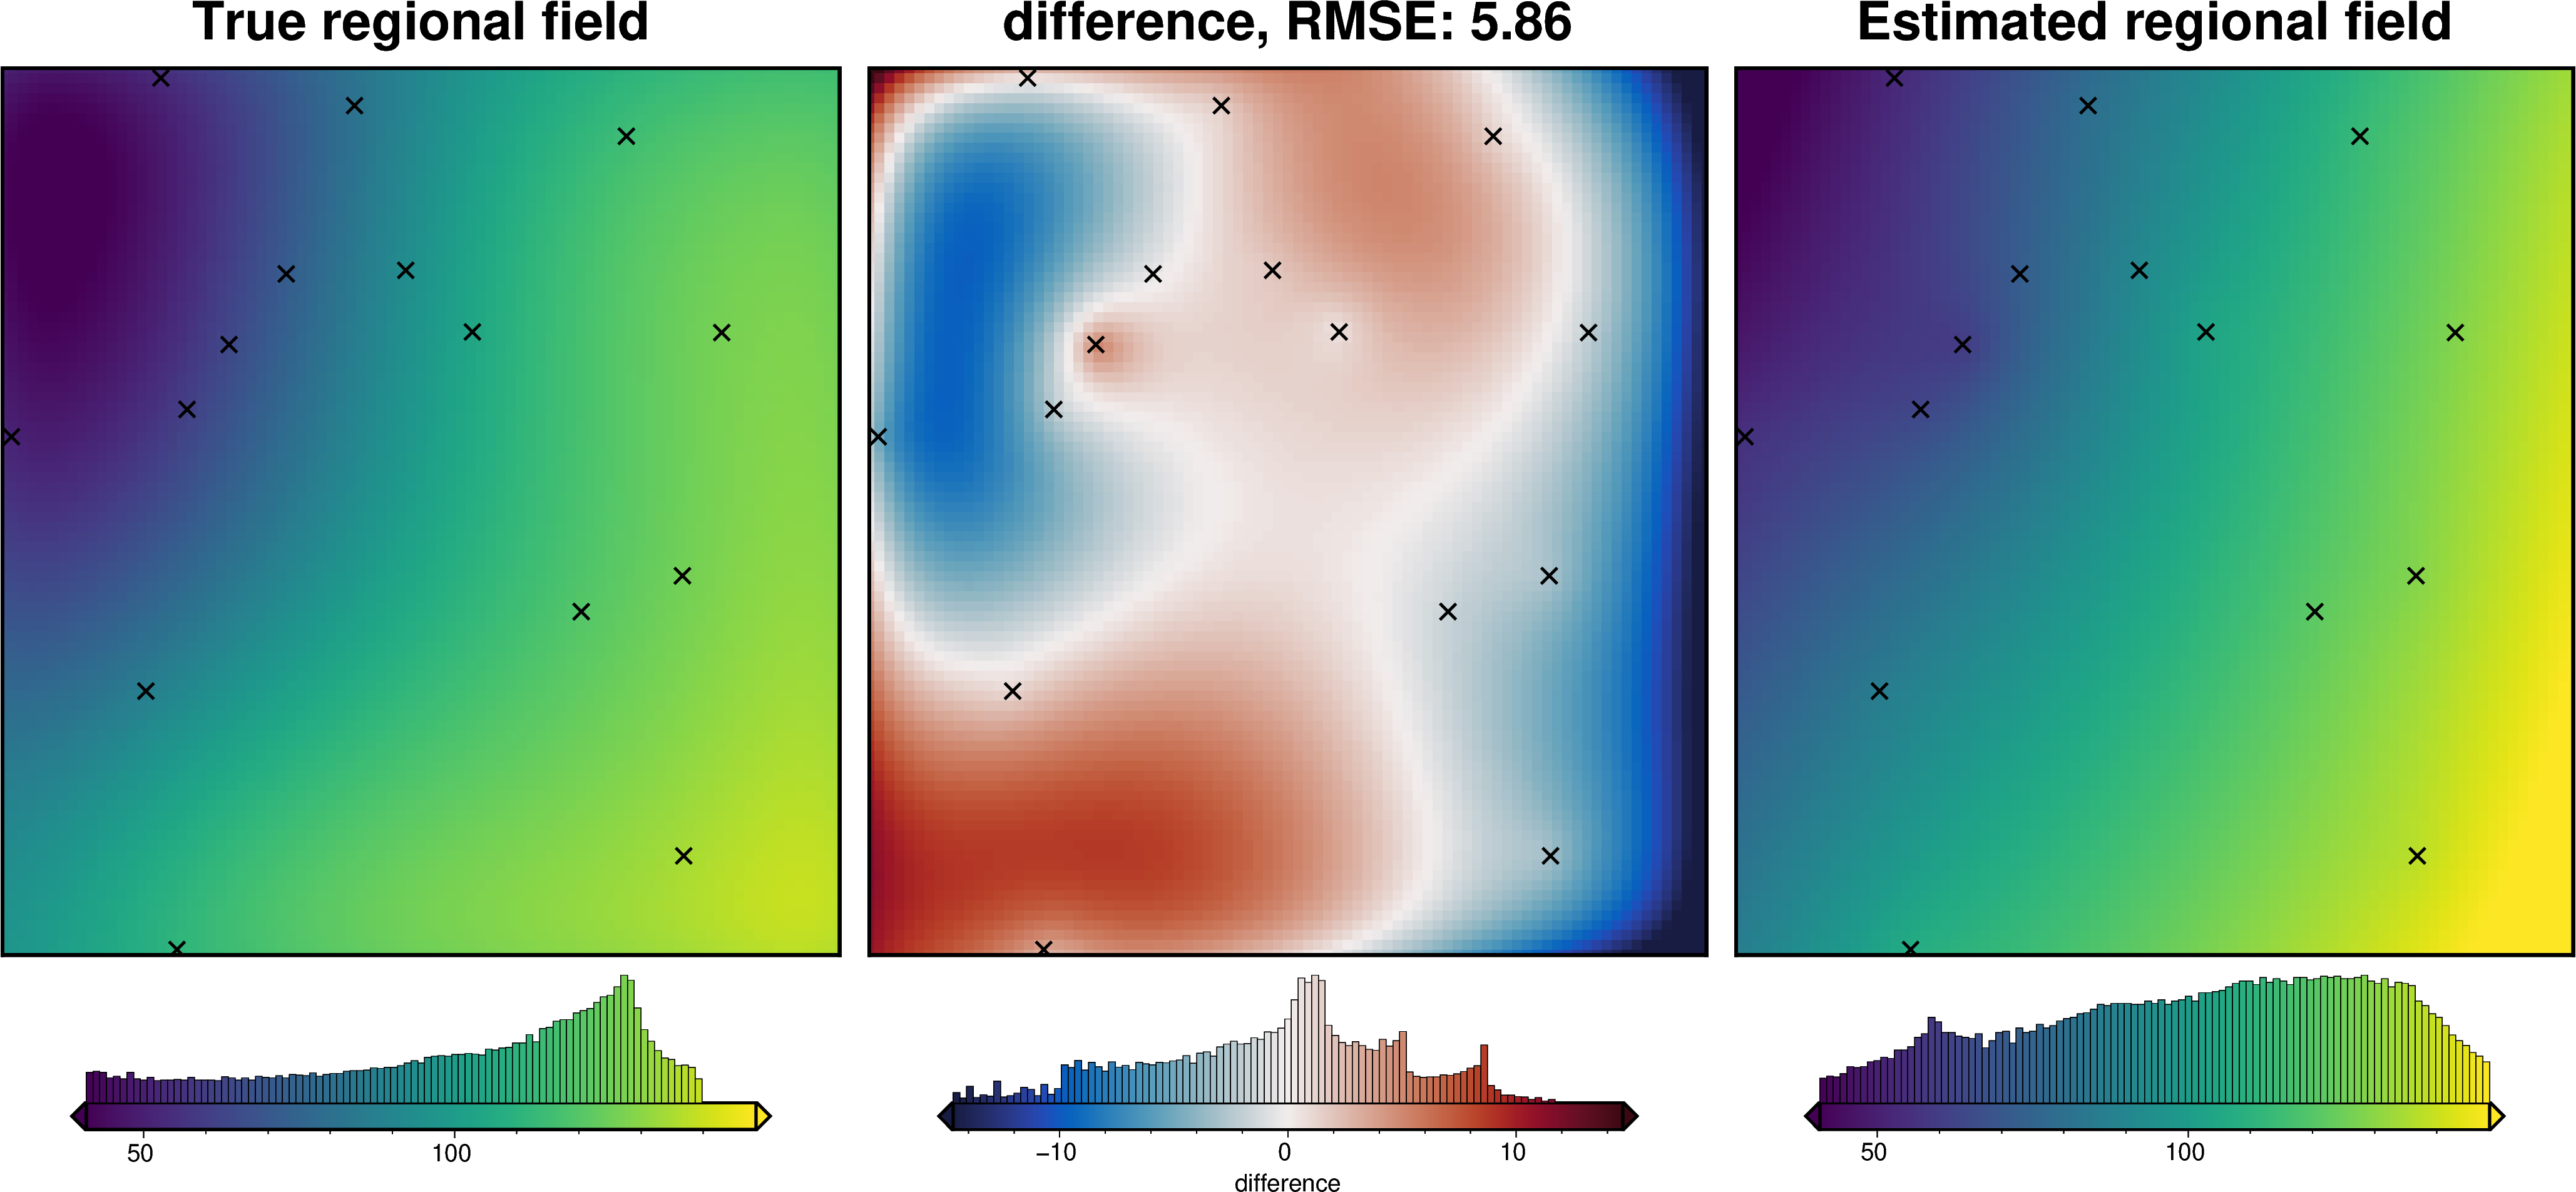

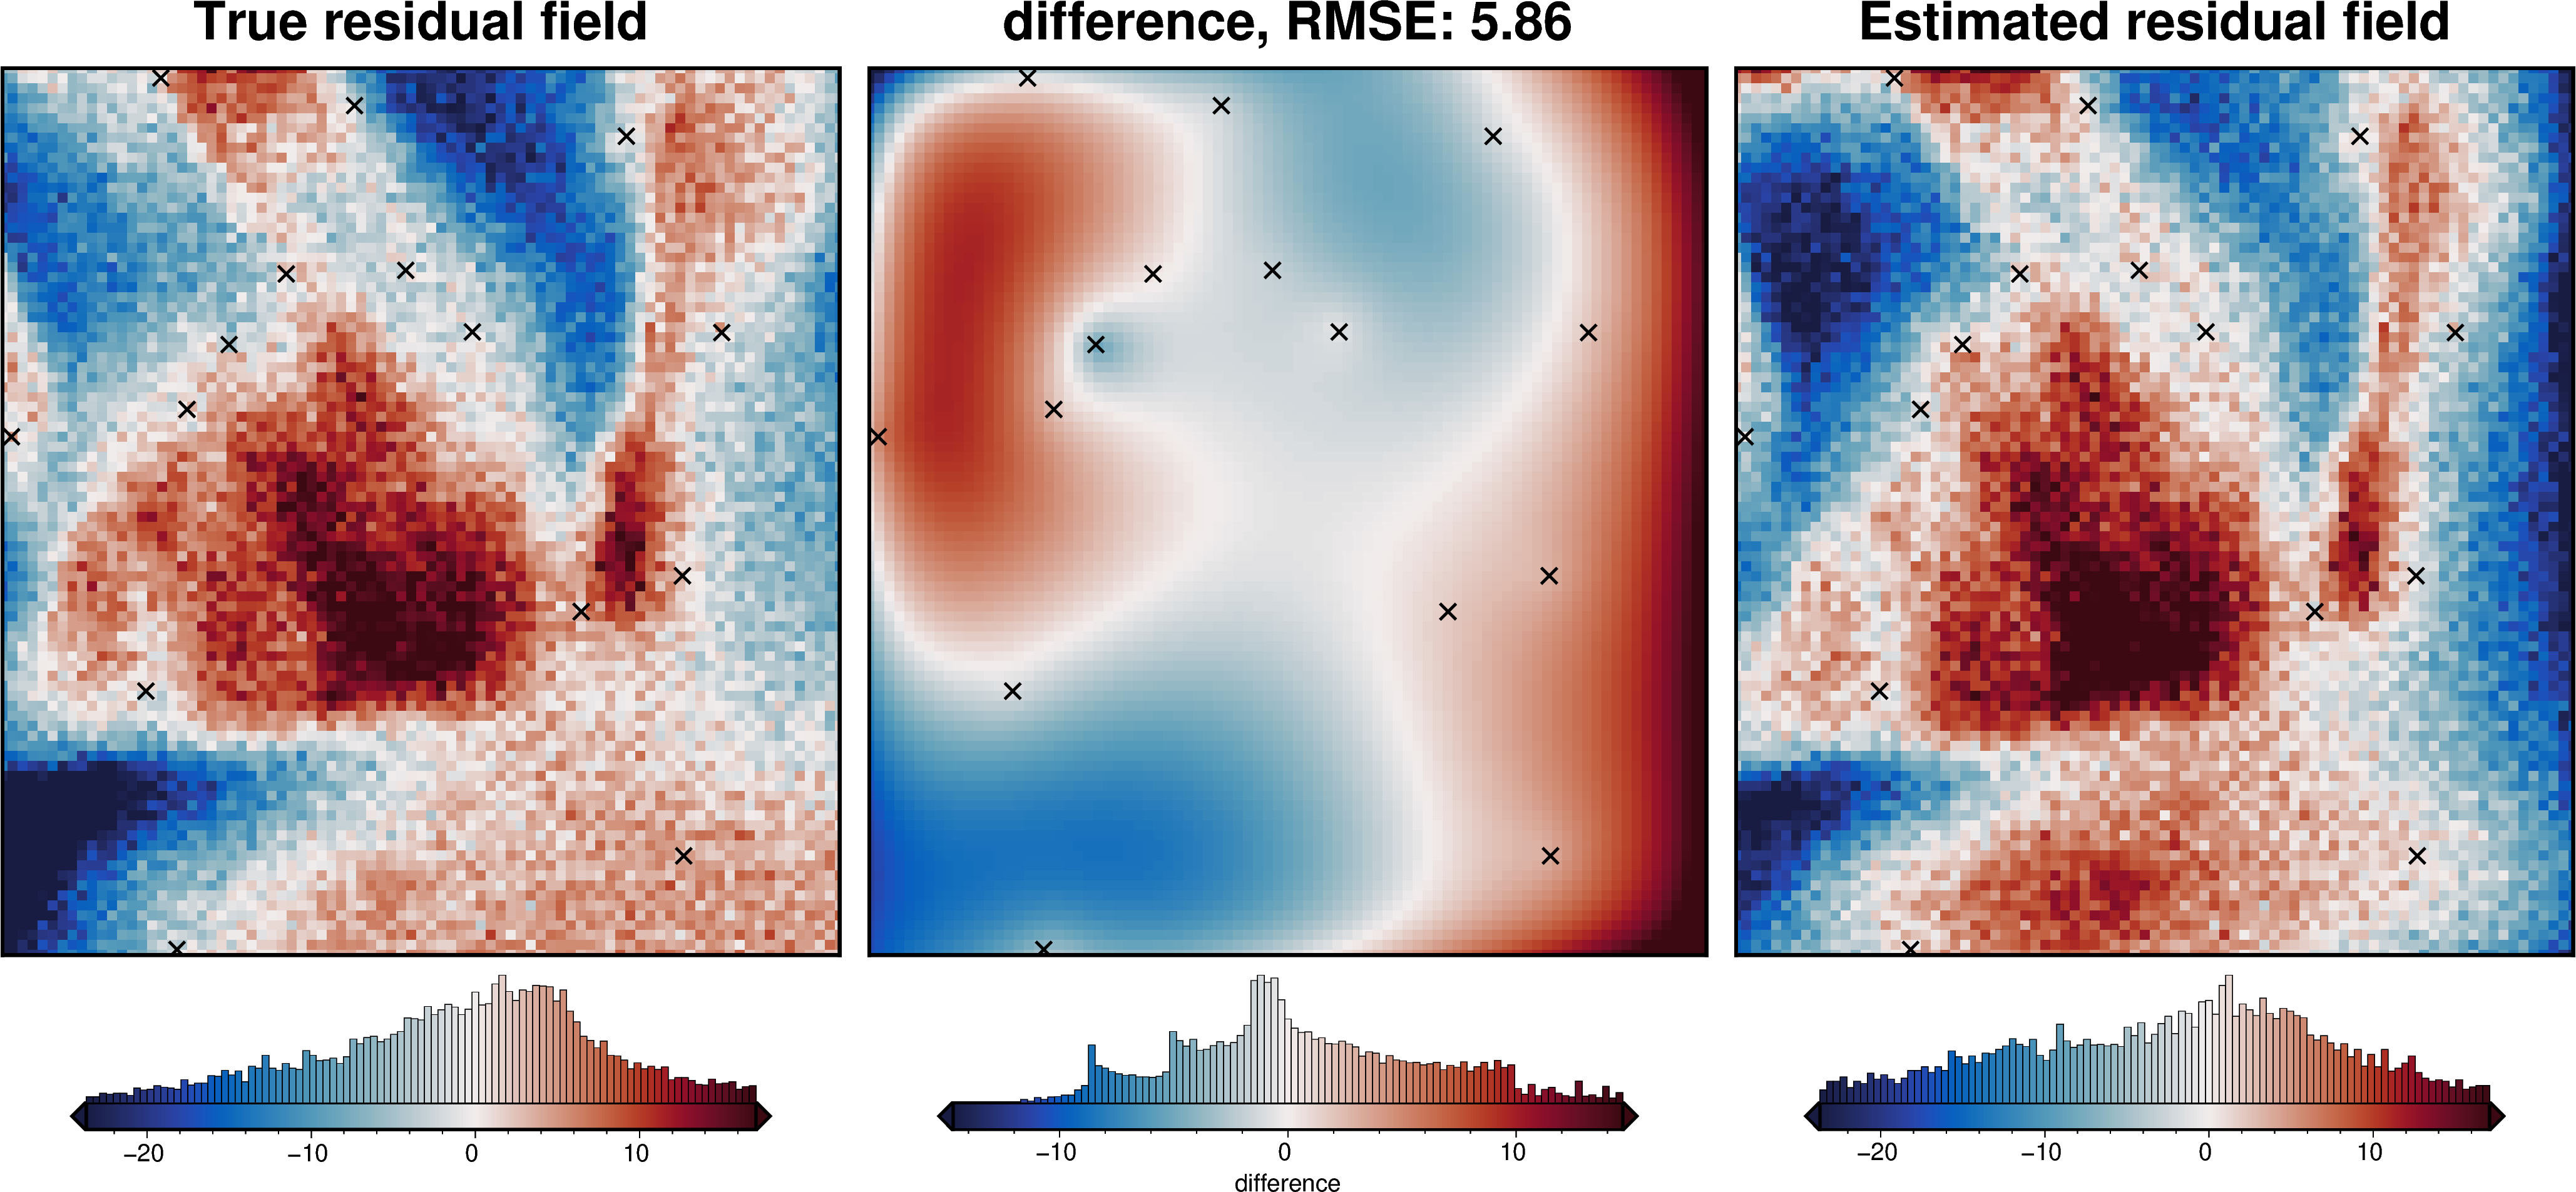

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...  constant_custom_res   filter_reg   filter_res    trend_reg  \
count  ...          7650.000000  7650.000000  7650.000000  7650.000000   
mean   ...            24.608770   100.225716    -0.616946    99.608770   
std    ...            30.575680    23.000784    10.193347    29.762501   
min    ...           -57.042487    43.873104   -44.345125    16.436345   
25%    ...             3.148025    83.131474    -4.395330    78.406023   
50%    ...            32.148801   106.624451     0.805637   106.921763   
75%    ...            49.908087   119.661959     5.439712   123.768888   
max    ...            73.082017   132.913055    31.284771   138.956974   

          trend_res  eq_sources_reg  eq_sources_res          reg  \
count  7.650000e+03     7650.000000     7650.000000  7650.000000   
mean  -6.545984e-13       99.529962        0.078808   101.843126   
std    7.004693e+00       29.881479        5.607372    28.437521   
min   -2.015281e+01       22.421873      -18.291572    33.266273   
25%   -5.088947e+00       77.712625       -3.555232    80.633890   
50%   -3.260685e-02      108.692923        0.084635   105.068306   
75%    5.121365e+00      123.542196        3.731290   125.045092   
max    3.065063e+01      146.602455       22.278320   159.085037   

       constraints_pygmt_reg  constraints_pygmt_res  
count            7650.000000            7650.000000  
mean              101.843126              -2.234357  
std                28.437521              10.083937  
min                33.266273             -30.540843  
25%                80.633890              -9.447560  
50%               105.068306              -1.090535  
75%               125.045092               4.841097  
max               159.085037              24.797822  

[8 rows x 25 columns]

In [23]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="pygmt",
    tension_factor=0.3,
)
grav_df["constraints_pygmt_reg"] = grav_df.reg
grav_df["constraints_pygmt_res"] = grav_df.res

regional_comparison(grav_df, "constraints_pygmt_reg")

grav_df.describe()

#### gridding with Verde and biharmonic splines

INFO:invert4geom:Best SplineCV score: 0.9270952808343169
INFO:invert4geom:Best damping: 1.2915496650148826e-09


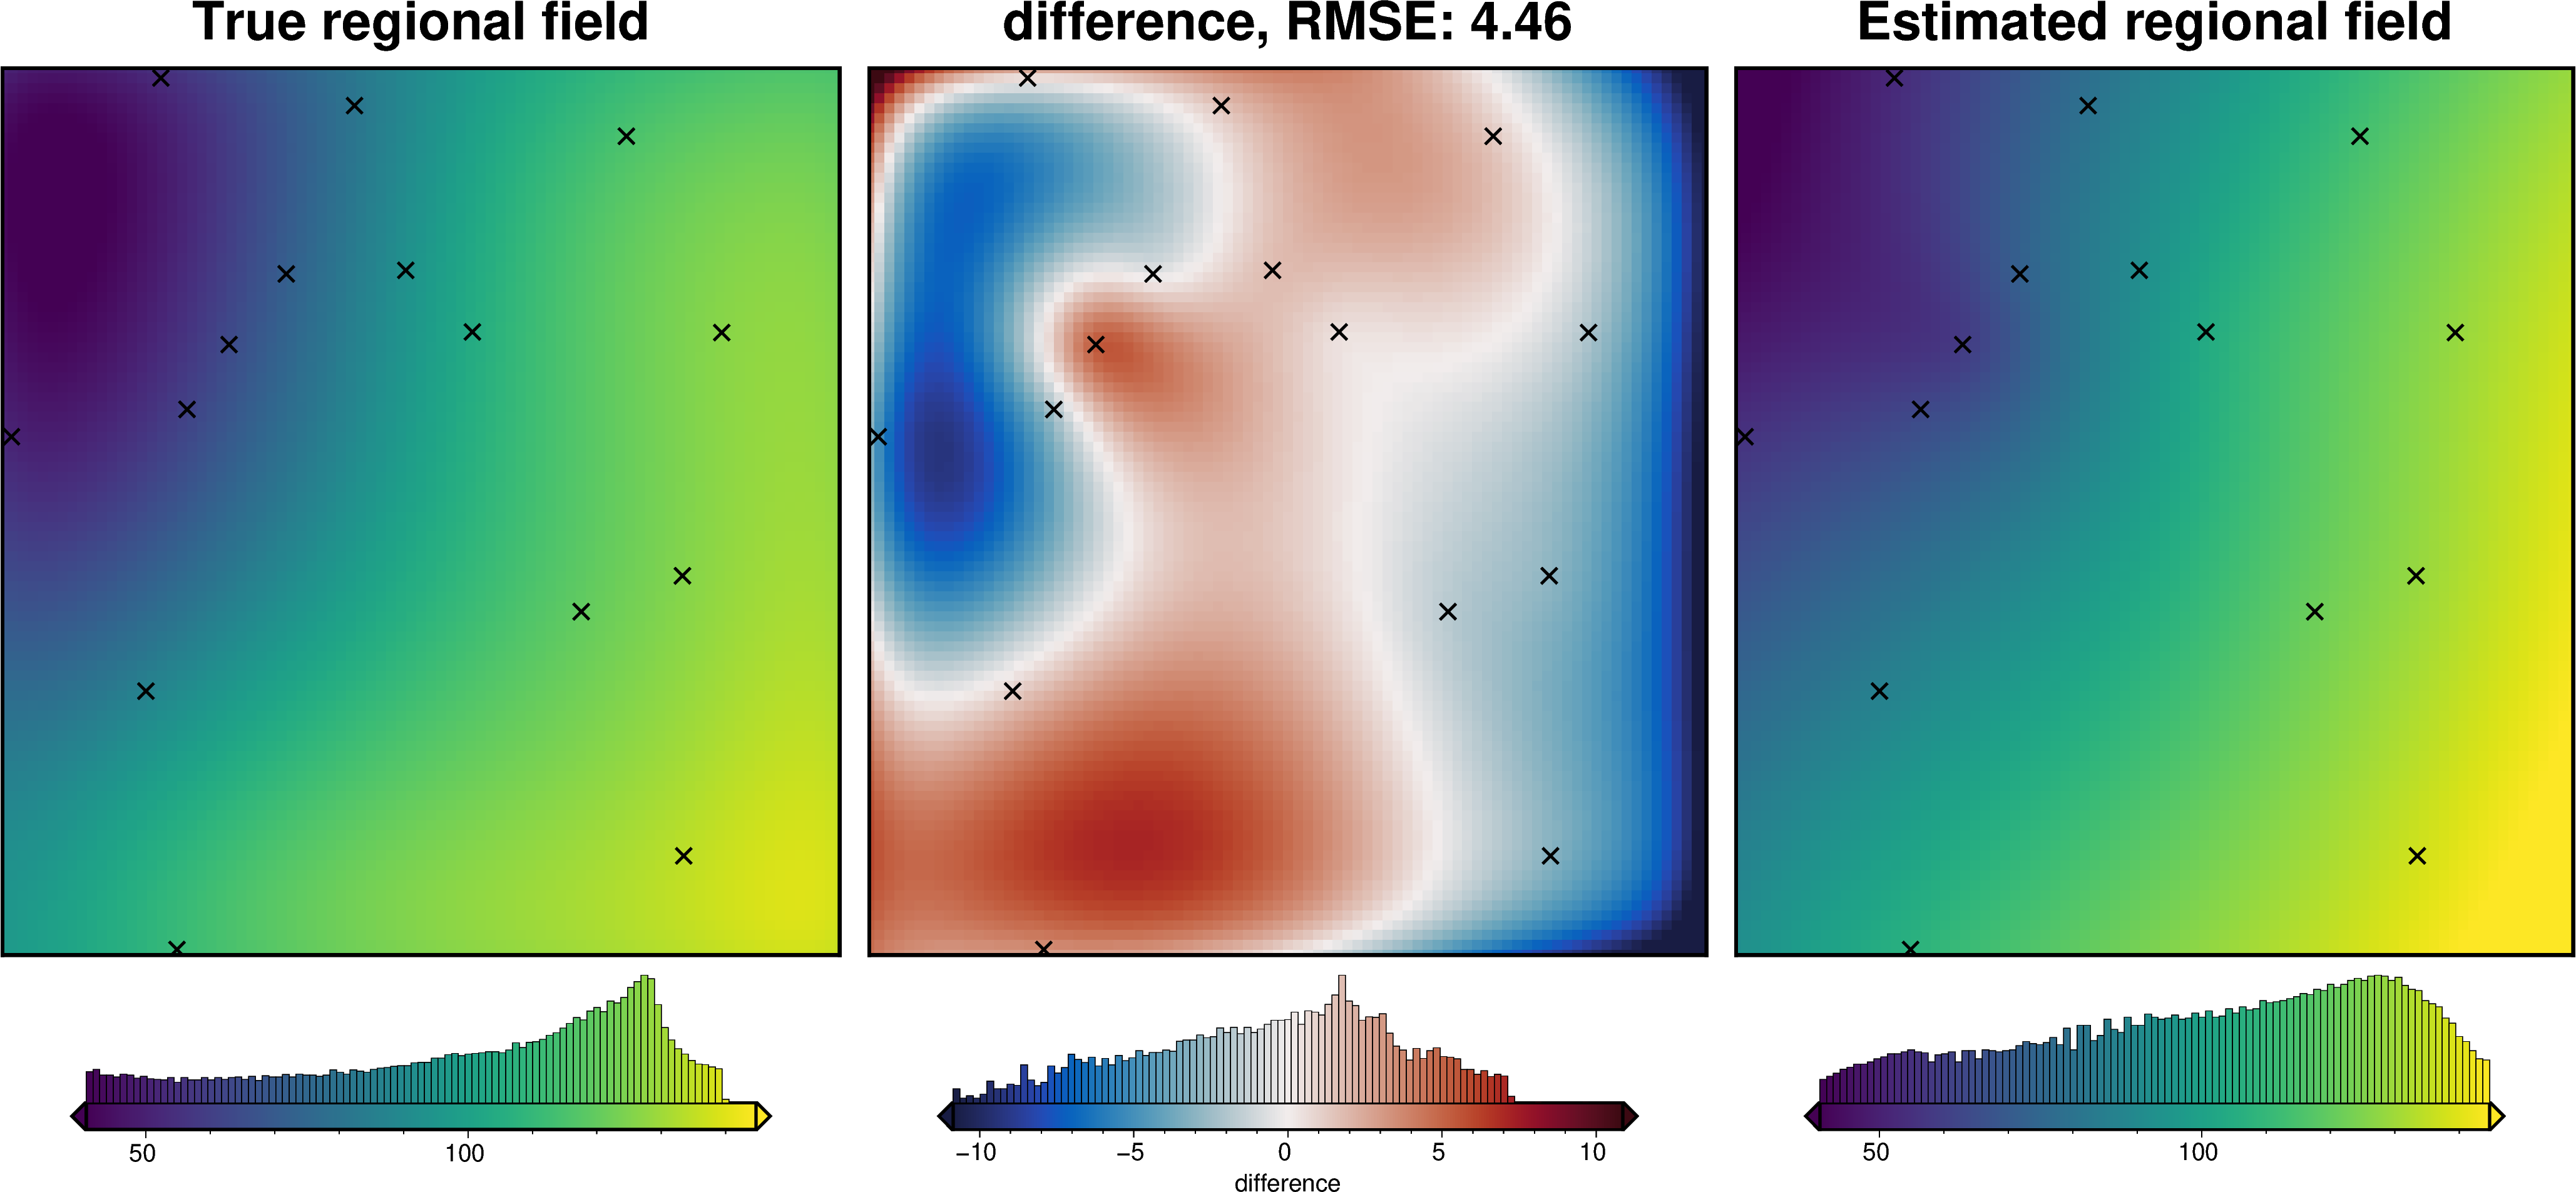

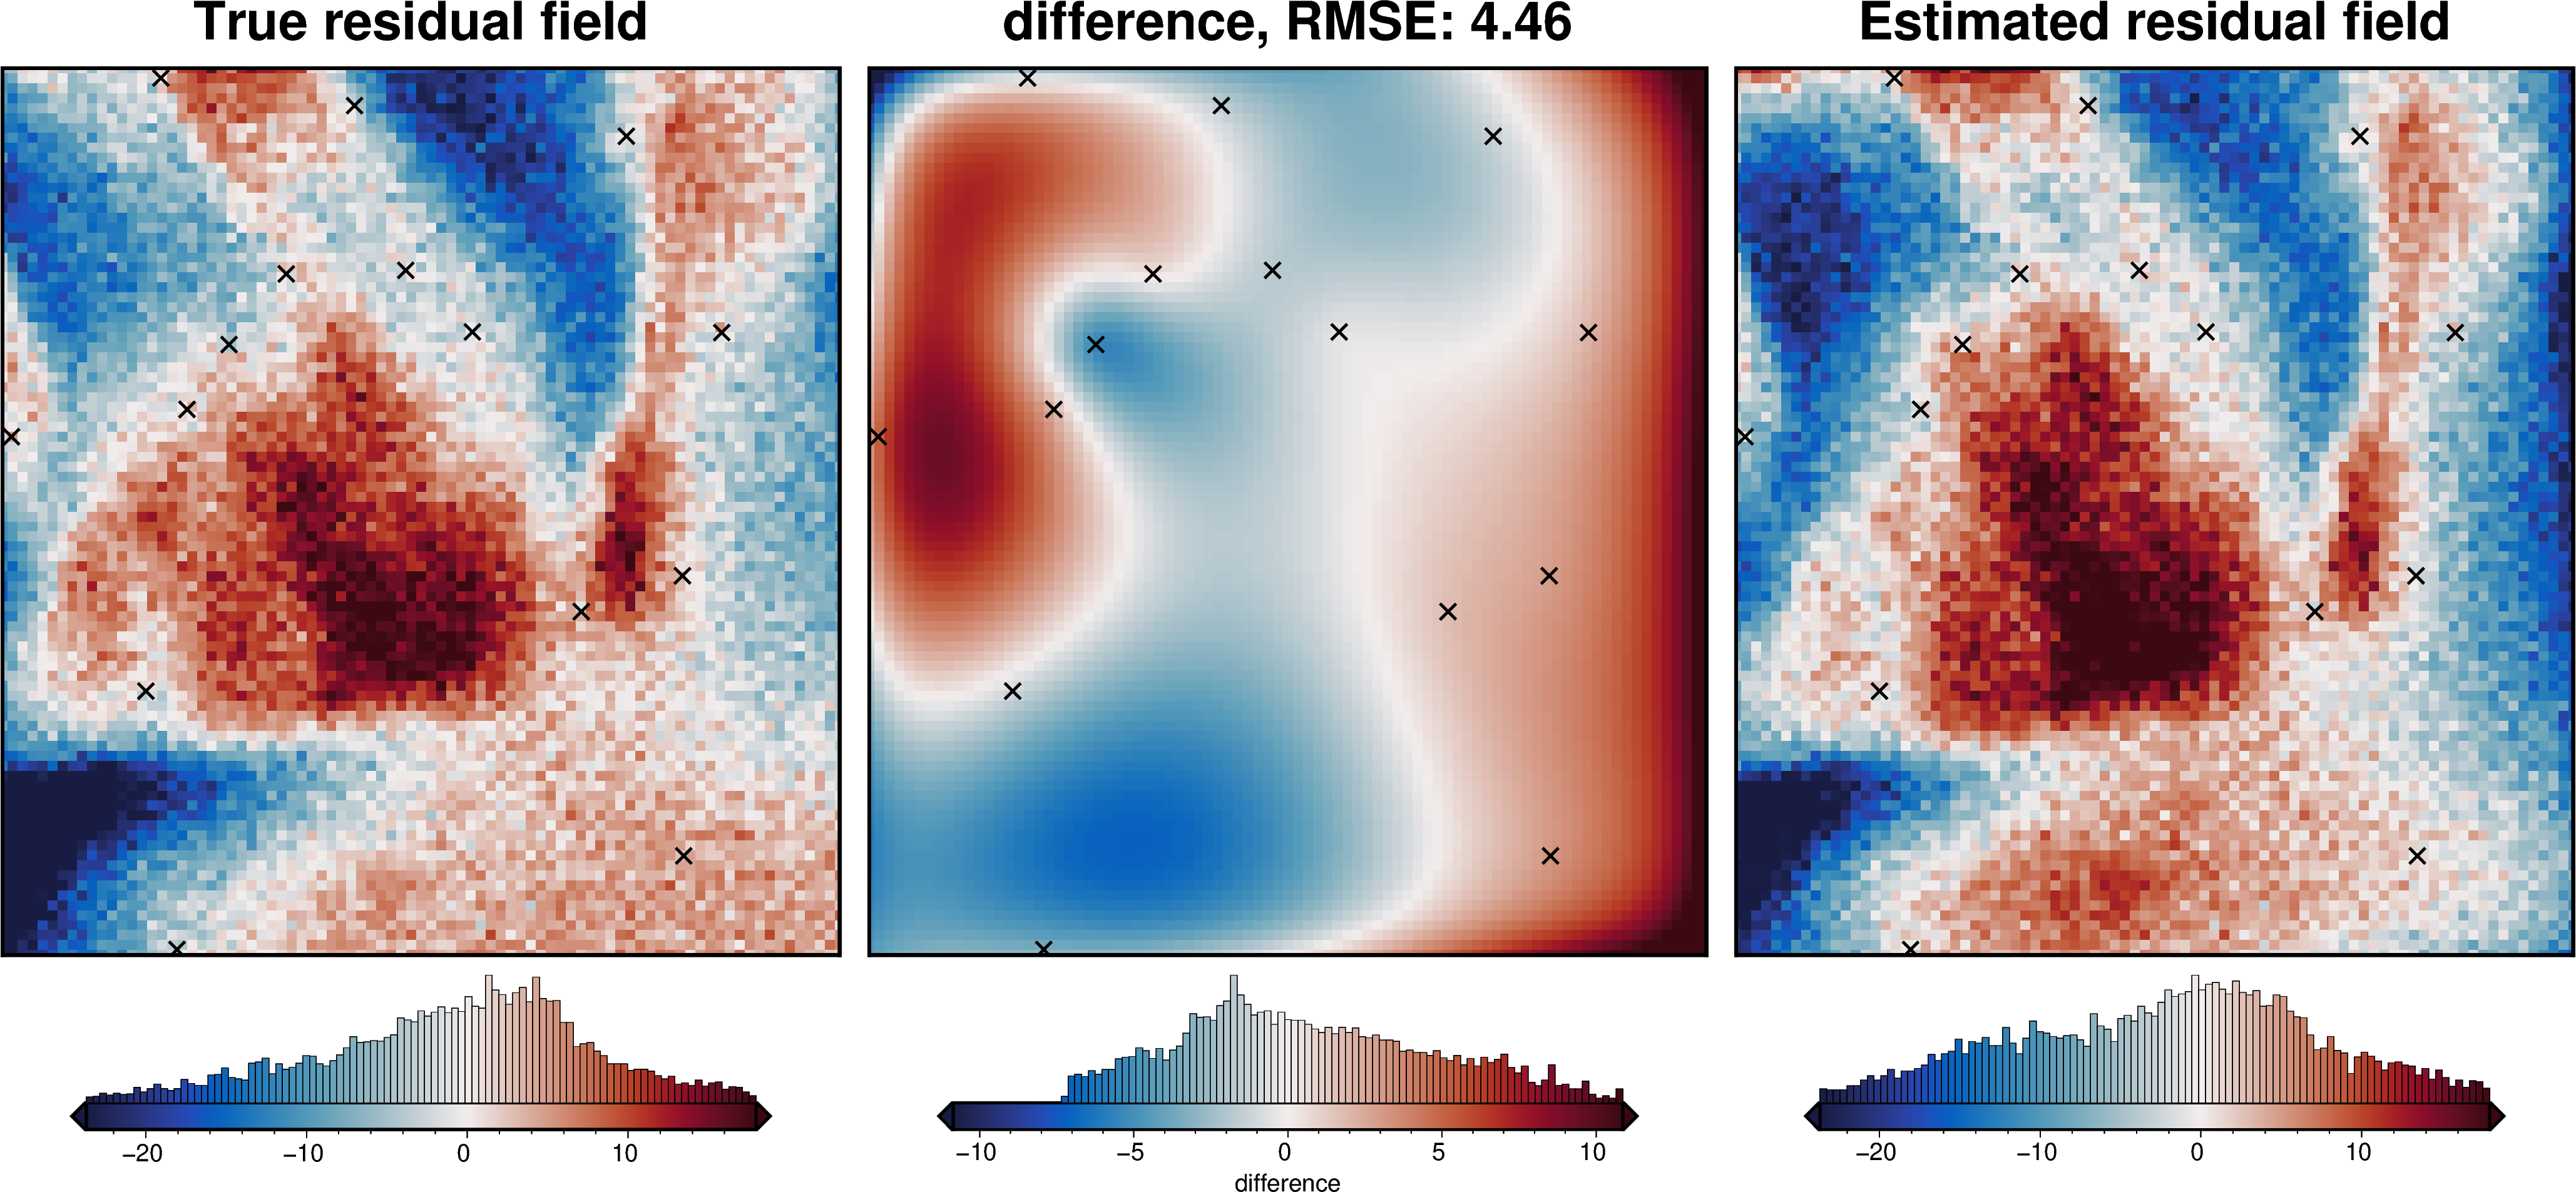

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...   filter_res    trend_reg     trend_res  eq_sources_reg  \
count  ...  7650.000000  7650.000000  7.650000e+03     7650.000000   
mean   ...    -0.616946    99.608770 -6.545984e-13       99.529962   
std    ...    10.193347    29.762501  7.004693e+00       29.881479   
min    ...   -44.345125    16.436345 -2.015281e+01       22.421873   
25%    ...    -4.395330    78.406023 -5.088947e+00       77.712625   
50%    ...     0.805637   106.921763 -3.260685e-02      108.692923   
75%    ...     5.439712   123.768888  5.121365e+00      123.542196   
max    ...    31.284771   138.956974  3.065063e+01      146.602455   

       eq_sources_res          reg  constraints_pygmt_reg  \
count     7650.000000  7650.000000            7650.000000   
mean         0.078808   101.687704             101.843126   
std          5.607372    28.034131              28.437521   
min        -18.291572    34.987861              33.266273   
25%         -3.555232    81.057422              80.633890   
50%          0.084635   106.003602             105.068306   
75%          3.731290   124.989962             125.045092   
max         22.278320   153.785055             159.085037   

       constraints_pygmt_res  constraints_verde_reg  constraints_verde_res  
count            7650.000000            7650.000000            7650.000000  
mean               -2.234357             101.687704              -2.078934  
std                10.083937              28.034131              10.009124  
min               -30.540843              34.987861             -34.415081  
25%                -9.447560              81.057422              -9.315571  
50%                -1.090535             106.003602              -1.220358  
75%                 4.841097             124.989962               4.661049  
max                24.797822             153.785055              25.242319  

[8 rows x 27 columns]

In [24]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="verde",
    spline_dampings=np.logspace(-20, 0, 10),
)
grav_df["constraints_verde_reg"] = grav_df.reg
grav_df["constraints_verde_res"] = grav_df.res

regional_comparison(grav_df, "constraints_verde_reg")

grav_df.describe()

#### gridding with Equivalent sources

  0%|          | 0/20 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 19
INFO:invert4geom:	parameter: {'damping': 0.0002654093551285742}
INFO:invert4geom:	scores: [0.8998036795721728]


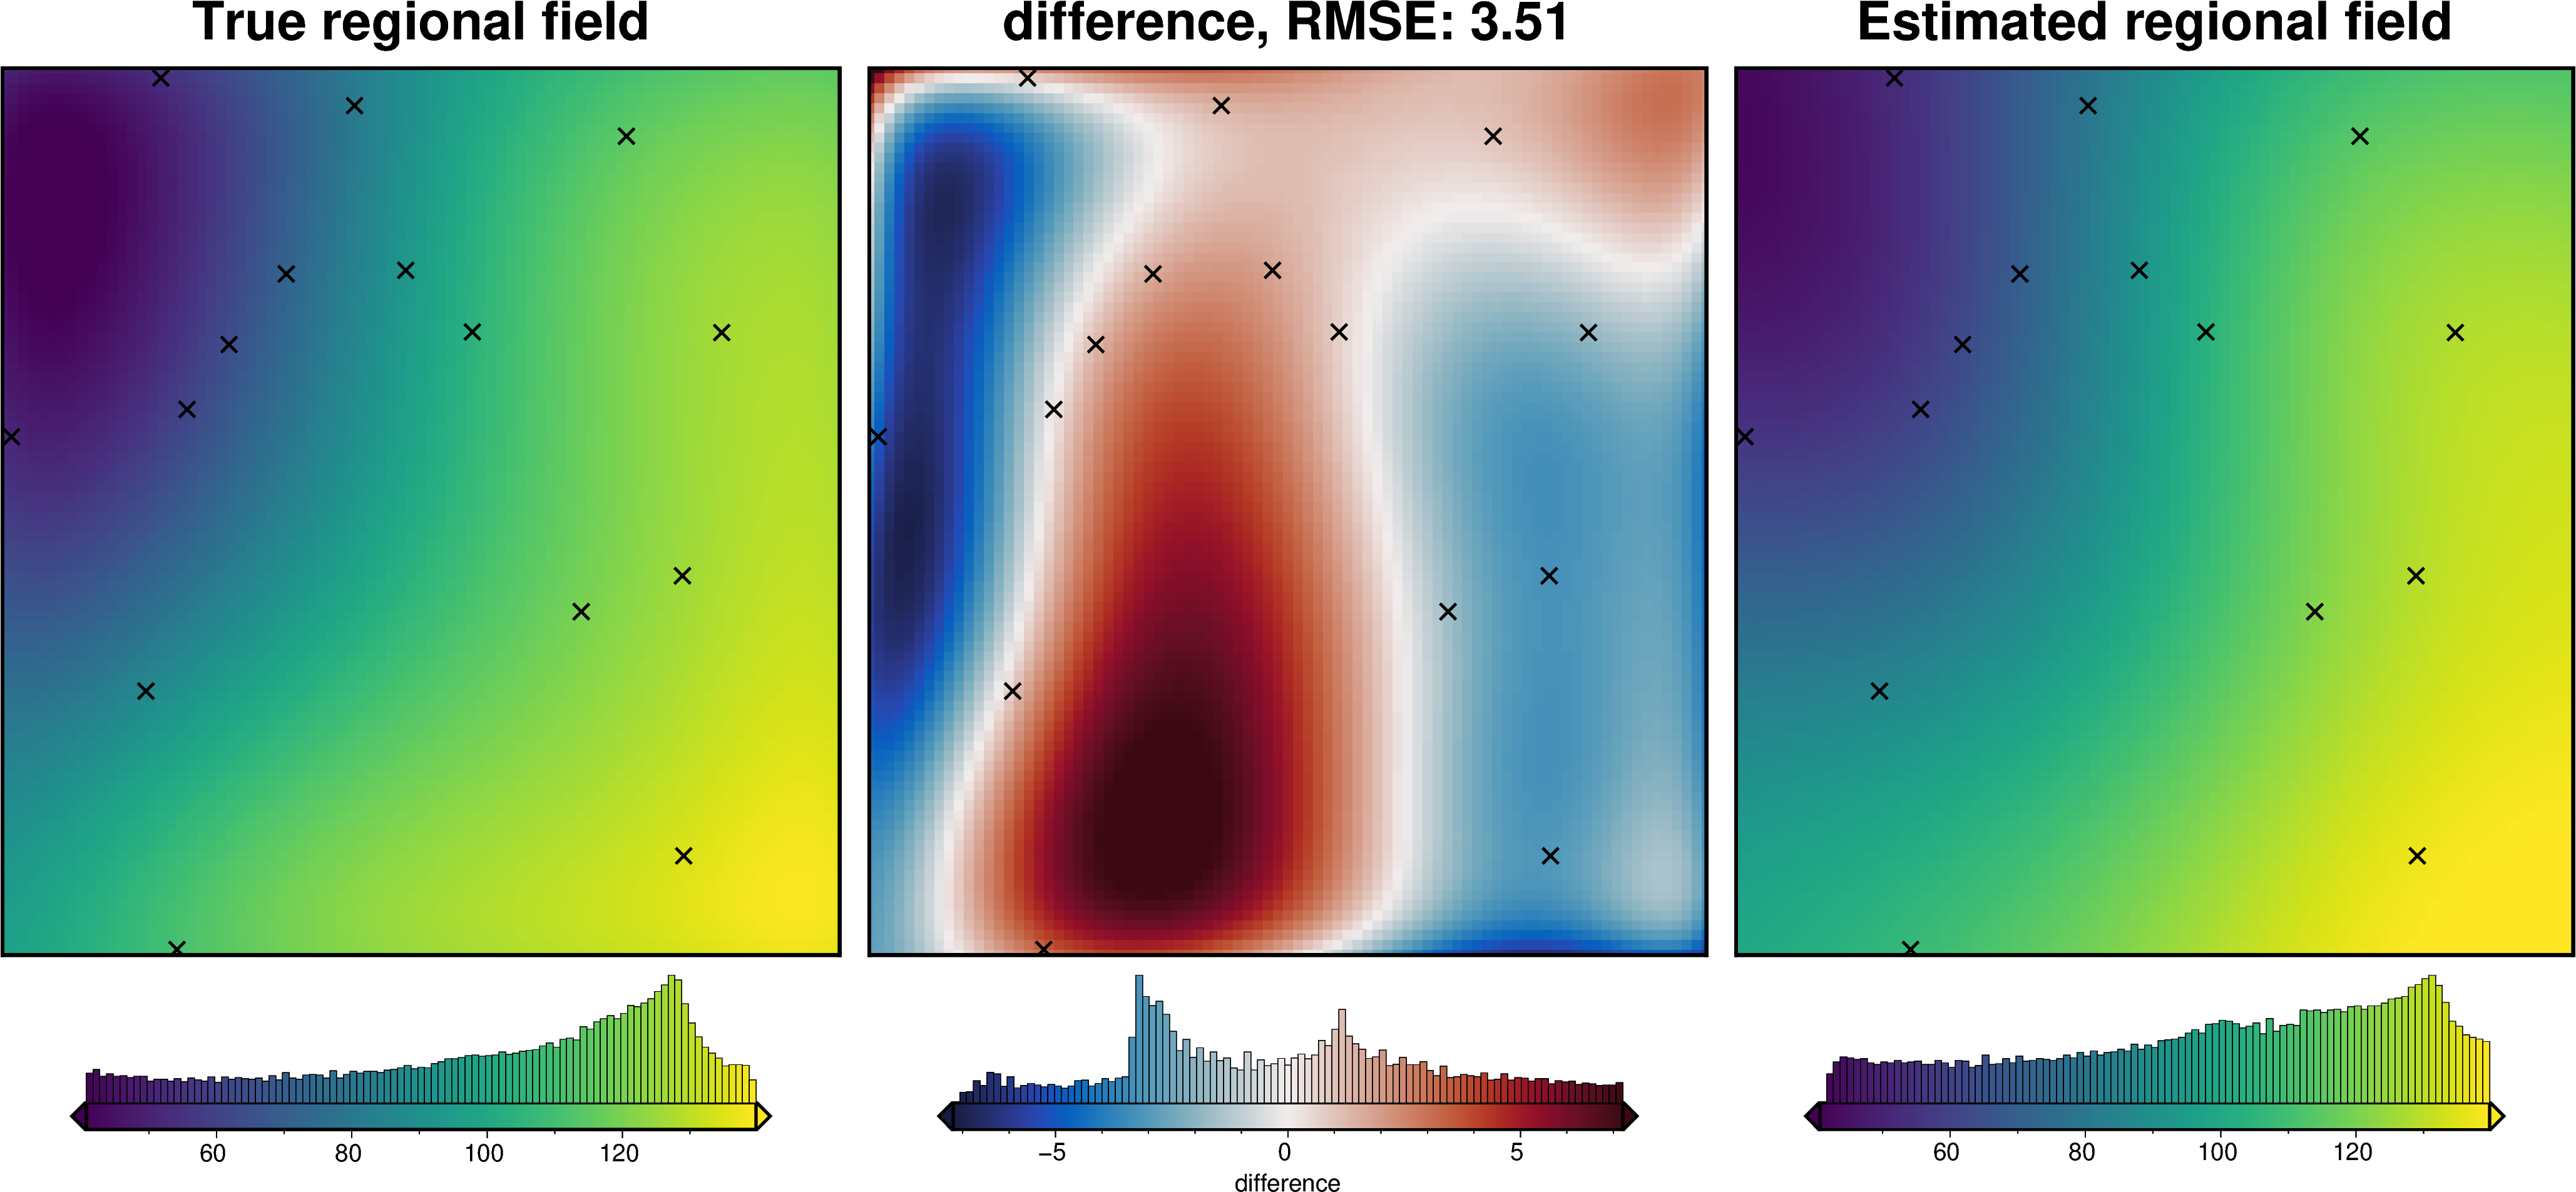

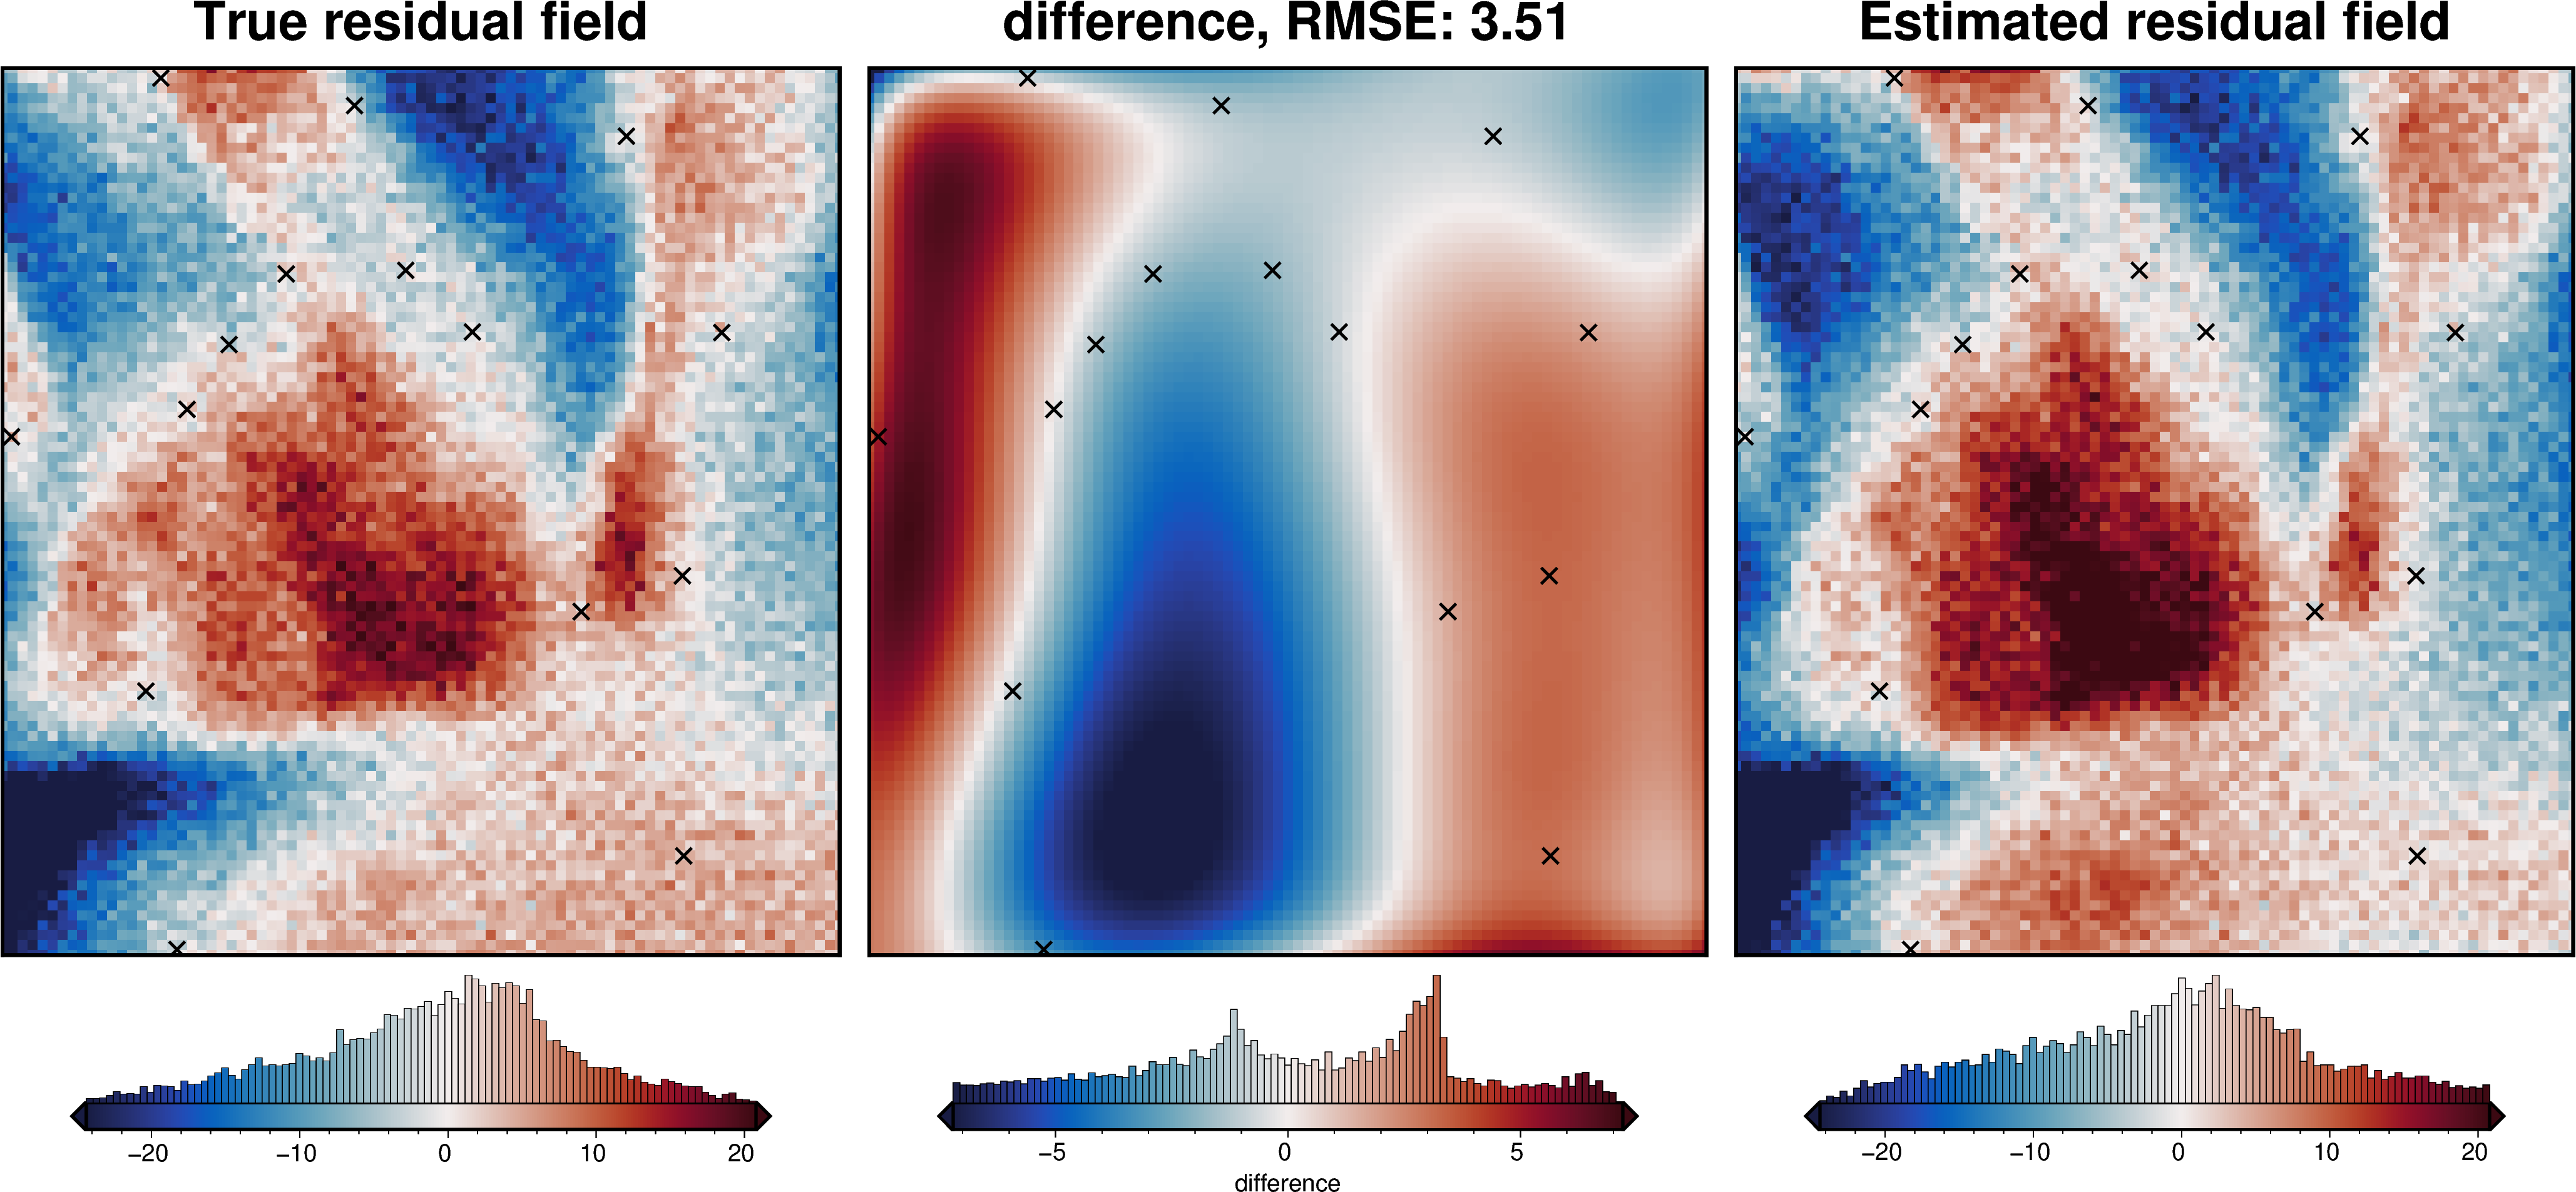

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...     trend_res  eq_sources_reg  eq_sources_res          reg  \
count  ...  7.650000e+03     7650.000000     7650.000000  7650.000000   
mean   ... -6.545984e-13       99.529962        0.078808   100.848860   
std    ...  7.004693e+00       29.881479        5.607372    27.307962   
min    ... -2.015281e+01       22.421873      -18.291572    42.115007   
25%    ... -5.088947e+00       77.712625       -3.555232    80.724627   
50%    ... -3.260685e-02      108.692923        0.084635   105.716324   
75%    ...  5.121365e+00      123.542196        3.731290   124.146131   
max    ...  3.065063e+01      146.602455       22.278320   141.596547   

       constraints_pygmt_reg  constraints_pygmt_res  constraints_verde_reg  \
count            7650.000000            7650.000000            7650.000000   
mean              101.843126              -2.234357             101.687704   
std                28.437521              10.083937              28.034131   
min                33.266273             -30.540843              34.987861   
25%                80.633890              -9.447560              81.057422   
50%               105.068306              -1.090535             106.003602   
75%               125.045092               4.841097             124.989962   
max               159.085037              24.797822             153.785055   

       constraints_verde_res  constraints_eqs_reg  constraints_eqs_res  
count            7650.000000          7650.000000          7650.000000  
mean               -2.078934           100.848860            -1.240091  
std                10.009124            27.307962            10.820212  
min               -34.415081            42.115007           -43.314183  
25%                -9.315571            80.724627            -8.142607  
50%                -1.220358           105.716324            -0.246665  
75%                 4.661049           124.146131             5.399315  
max                25.242319           141.596547            28.065648  

[8 rows x 29 columns]

In [25]:
# estimate regional with the constraints method
grav_df = regional.regional_constraints(
    grav_df=grav_df,
    constraints_df=constraint_points,
    grid_method="eq_sources",
    # either automatically determine best damping
    cv=True,
    cv_kwargs=dict(
        n_trials=20,
        damping_limits=(1e-20, 1e3),
        fname="tmp/tmp",
    ),
    # or provide a value
    # damping=1e-15,
    depth="default",
    block_size=None,
)
grav_df["constraints_eqs_reg"] = grav_df.reg
grav_df["constraints_eqs_res"] = grav_df.res

regional_comparison(grav_df, "constraints_eqs_reg")

grav_df.describe()

We can also use the function `regional.regional_separation()` and pass through the `method` and keyword args, combining all the above functions into one.

INFO:invert4geom:using median gravity misfit of constraint points for regional field: 91.19338822398358 mGal


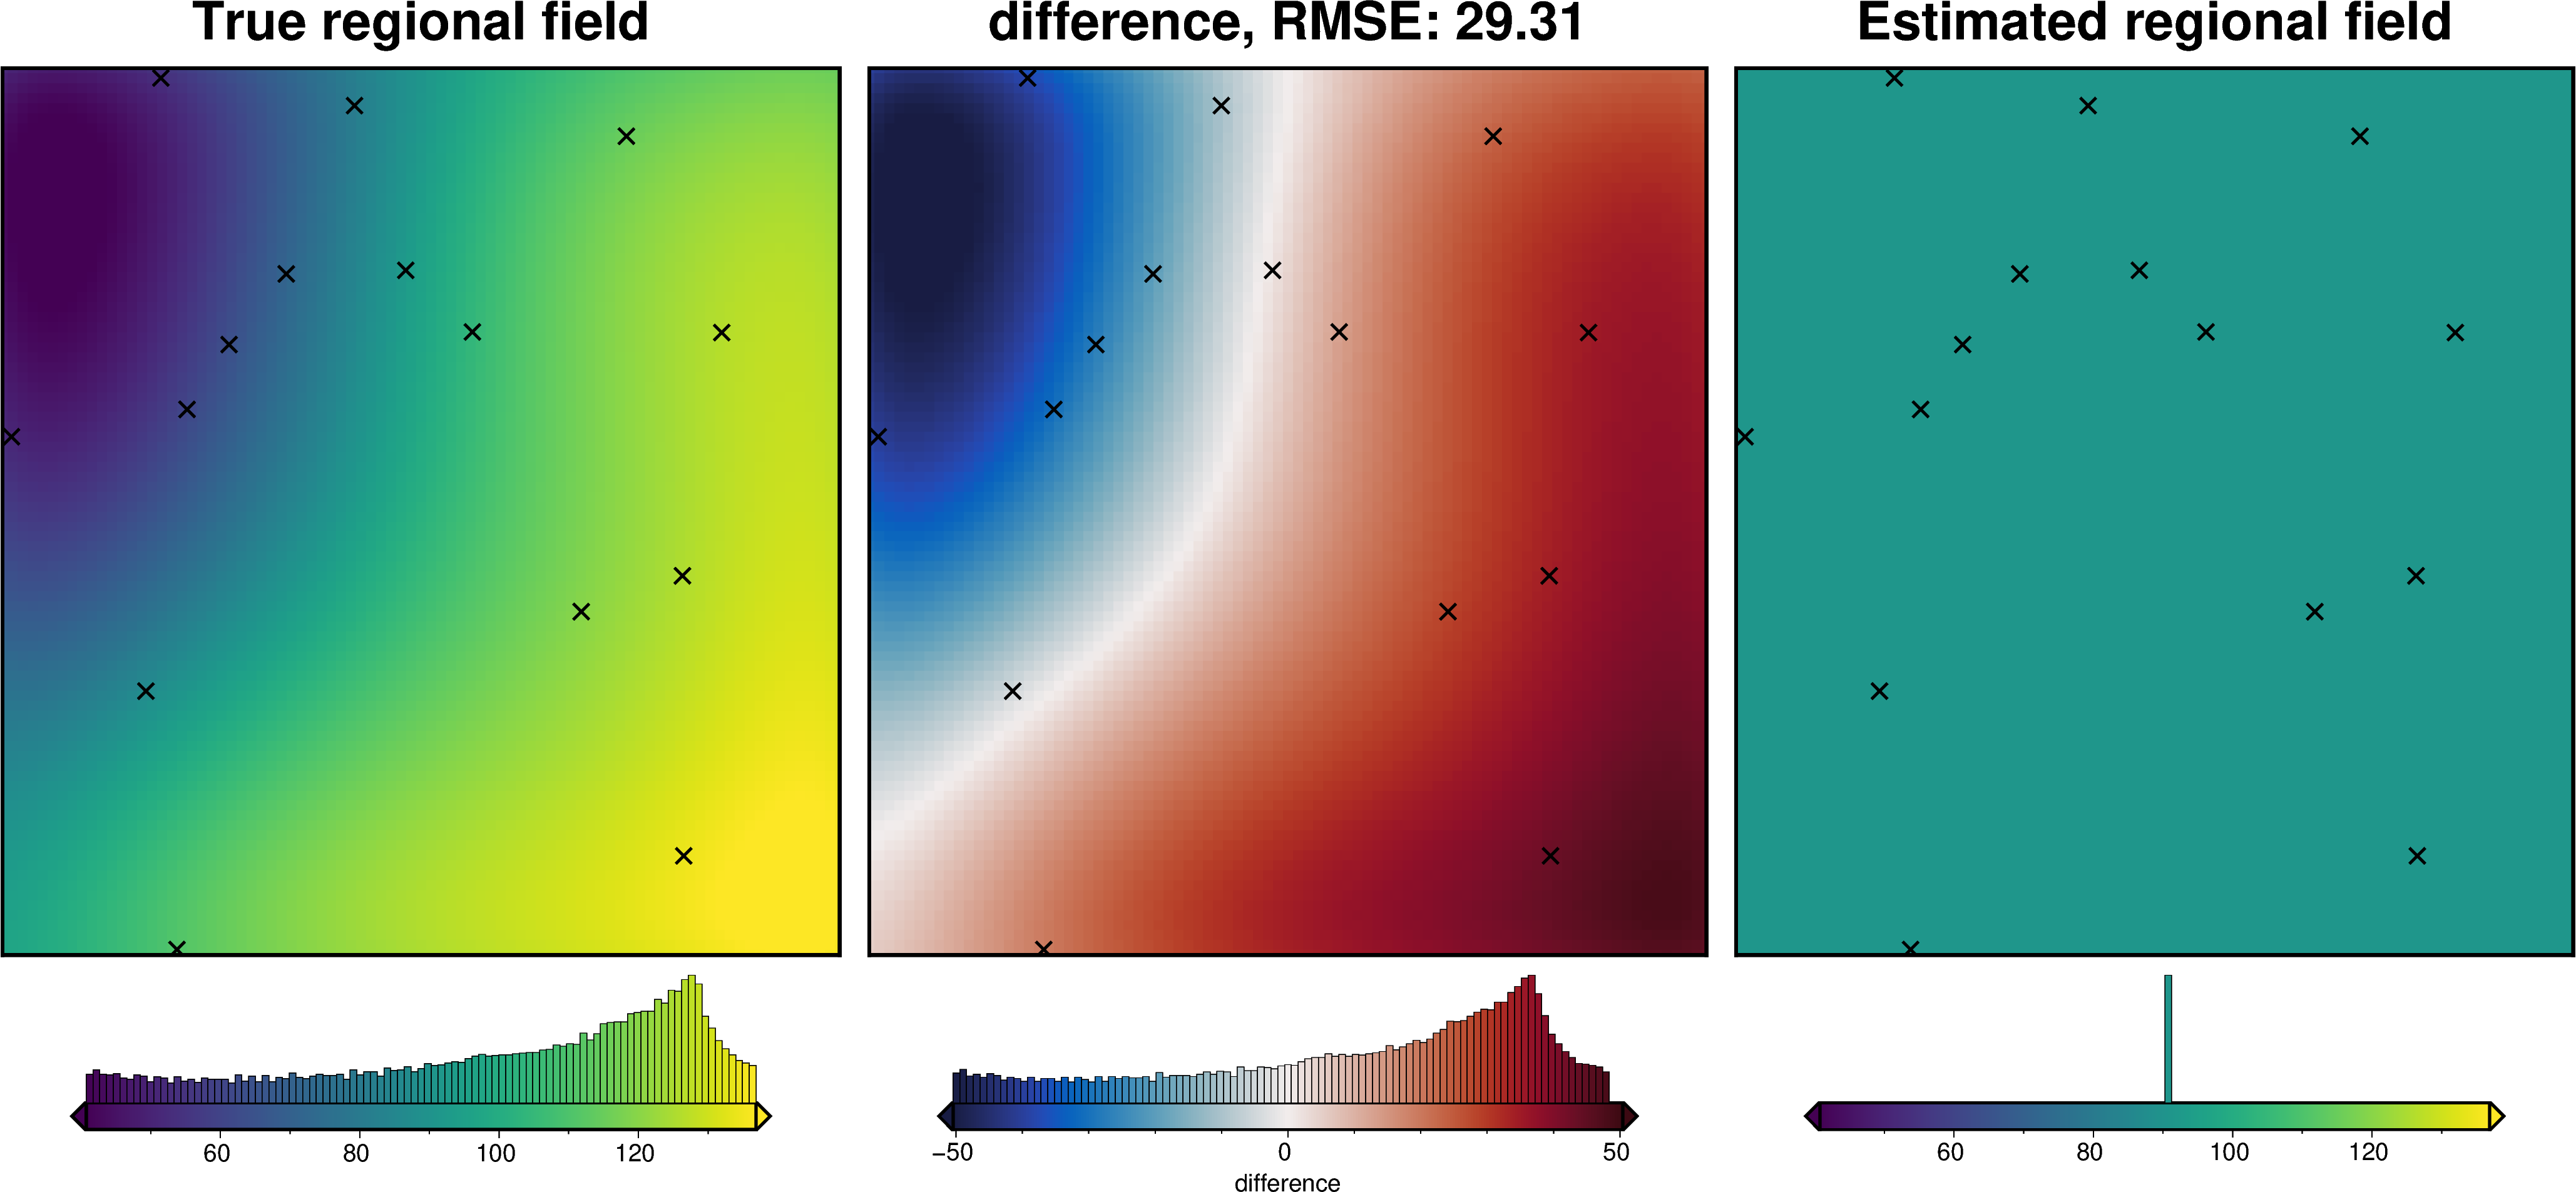

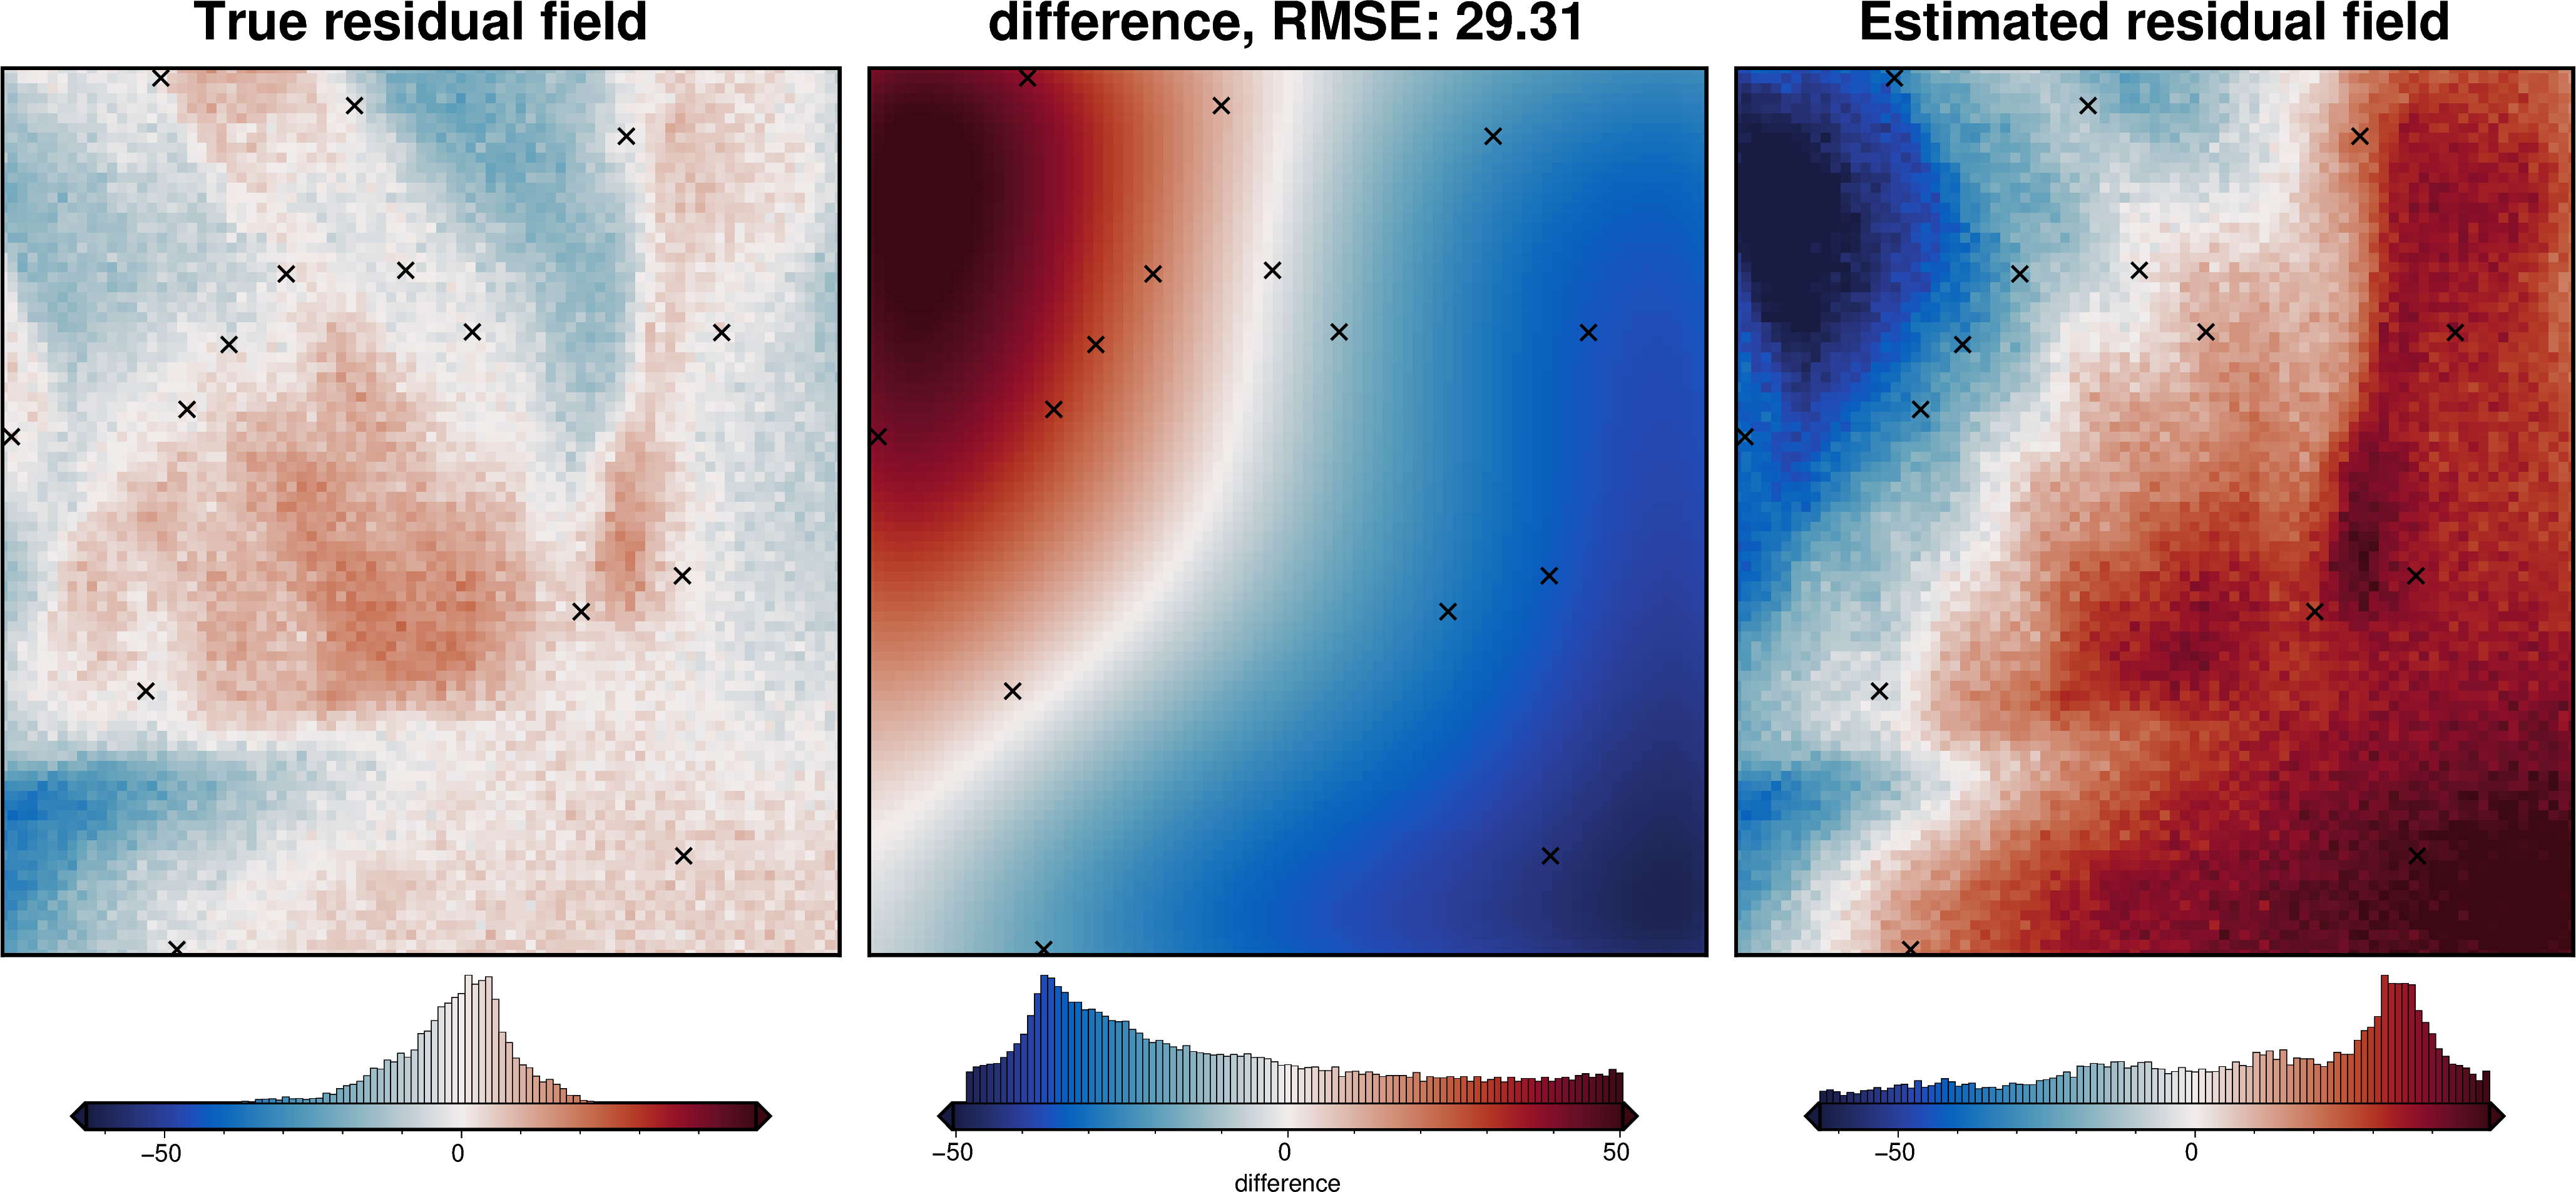

northing        easting  upward  basement_grav    moho_grav  \
count    7650.000000    7650.000000  7650.0    7650.000000  7650.000000   
mean   340900.000000  191900.000000  1000.0       0.302784   100.854261   
std    103923.425856   98149.168359     0.0      23.600390    27.678047   
min    162900.000000   23900.000000  1000.0     -33.022243    37.692492   
25%    250900.000000  107900.000000  1000.0     -18.374009    82.069724   
50%    340900.000000  191900.000000  1000.0      -4.926081   109.032927   
75%    430900.000000  275900.000000  1000.0      21.427205   123.713696   
max    518900.000000  359900.000000  1000.0      58.127097   139.552763   

              grav  gravity_anomaly  uncert  starting_gravity     true_res  \
count  7650.000000      7650.000000  7650.0       7650.000000  7650.000000   
mean    101.157045       101.157045     2.0          1.548275    -1.245492   
std       9.701881         9.918000     0.0         24.921606     9.332421   
min      75.622259        70.865584     2.0        -36.407174   -39.690986   
25%      96.219224        96.092694     2.0        -17.405060    -6.457196   
50%     102.149393       102.057121     2.0         -3.039717    -0.024313   
75%     106.786022       107.005035     2.0         19.819674     4.762689   
max     126.324788       129.731888     2.0         59.686931    23.112321   

       ...     trend_res  eq_sources_reg  eq_sources_res           reg  \
count  ...  7.650000e+03     7650.000000     7650.000000  7.650000e+03   
mean   ... -6.545984e-13       99.529962        0.078808  9.119339e+01   
std    ...  7.004693e+00       29.881479        5.607372  1.421178e-14   
min    ... -2.015281e+01       22.421873      -18.291572  9.119339e+01   
25%    ... -5.088947e+00       77.712625       -3.555232  9.119339e+01   
50%    ... -3.260685e-02      108.692923        0.084635  9.119339e+01   
75%    ...  5.121365e+00      123.542196        3.731290  9.119339e+01   
max    ...  3.065063e+01      146.602455       22.278320  9.119339e+01   

       constraints_pygmt_reg  constraints_pygmt_res  constraints_verde_reg  \
count            7650.000000            7650.000000            7650.000000   
mean              101.843126              -2.234357             101.687704   
std                28.437521              10.083937              28.034131   
min                33.266273             -30.540843              34.987861   
25%                80.633890              -9.447560              81.057422   
50%               105.068306              -1.090535             106.003602   
75%               125.045092               4.841097             124.989962   
max               159.085037              24.797822             153.785055   

       constraints_verde_res  constraints_eqs_reg  constraints_eqs_res  
count            7650.000000          7650.000000          7650.000000  
mean               -2.078934           100.848860            -1.240091  
std                10.009124            27.307962            10.820212  
min               -34.415081            42.115007           -43.314183  
25%                -9.315571            80.724627            -8.142607  
50%                -1.220358           105.716324            -0.246665  
75%                 4.661049           124.146131             5.399315  
max                25.242319           141.596547            28.065648  

[8 rows x 29 columns]

In [26]:
# estimate regional with the mean misfit at constraints
grav_df = regional.regional_separation(
    method="constant",
    grav_df=grav_df,
    constraints_df=constraint_points,
)

regional_comparison(grav_df, "reg")

grav_df.describe()

Above we just picked these hyperparameter values arbitrarily. The next [user guide](regional_field_hyperparameters.ipynb) shows a more informed technique for choosing each of these hyperparameter values.